In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print('Shah Mohammad Rizvi')

Shah Mohammad Rizvi


In [5]:
print("In the name of Allah SWT, let's begin our work for chemicals in Cosmetics.")

In the name of Allah SWT, let's begin our work for chemicals in Cosmetics.


In [6]:
print("In Sha Allah! this will be one of my greatest work of all time.")

In Sha Allah! this will be one of my greatest work of all time.


In [7]:
import os
import sys
import json
import pandas as pd
from pathlib import Path

FILE_PATHS = [
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics.csv',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics-data-dictionary.xlsx',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/proposition65_clean.csv',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/Chemical List toxcast-2025-08-08.csv',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/tox21.csv/tox21.csv',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Ingredients-Fragrance Inventory_v2.csv',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Annex_II_v2.xls',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Annex_III_v2.xls',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Annex_IV_v2.xls',
    '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/coslng/COSING_Annex_V_v2.xls'
]

# Path to Reprotox-KG folder
REPROTOX_KG_DIR = '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/Reprotox-KG-main/Reprotox-KG-main'

# === Helper functions ===

def safe_read(path):
    """Try to read CSV/XLS/XLSX intelligently and return dataframe + info"""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f'File not found: {path}')
    suffix = path.suffix.lower()
    if suffix in ['.csv', '.txt']:
        try:
            df = pd.read_csv(path, low_memory=False)
        except Exception as e:
            df = pd.read_csv(path, encoding='latin1', low_memory=False)
        return df
    if suffix in ['.xls', '.xlsx']:
        # read all sheets if excel
        try:
            xls = pd.read_excel(path, sheet_name=None)
            # if only one sheet, return DataFrame, else return dict
            if len(xls) == 1:
                return list(xls.values())[0]
            else:
                # combine sheet names to a single DF with a 'sheet_name' column for inspection
                parts = []
                for sheet_name, df in xls.items():
                    df = df.copy()
                    df['_sheet_name_'] = sheet_name
                    parts.append(df)
                combined = pd.concat(parts, ignore_index=True, sort=False)
                return combined
        except Exception as e:
            # fallback
            return pd.read_excel(path)
    # unknown extension
    raise ValueError(f'Unsupported file type: {suffix} for file {path}')


def summarize_df(df: pd.DataFrame):
    summary = {}
    summary['rows'] = int(df.shape[0])
    summary['cols'] = int(df.shape[1])
    # columns and dtypes
    summary['columns'] = [{ 'name': str(c), 'dtype': str(df[c].dtype),
                            'n_missing': int(df[c].isna().sum()),
                            'n_unique': int(df[c].nunique(dropna=True)) }
                           for c in df.columns]
    # basic duplicates check
    try:
        # find obvious ID columns
        id_cols = [c for c in df.columns if 'cas' in c.lower() or 'cid' in c.lower() or 'inchi' in c.lower() or 'smiles' in c.lower()]
        if id_cols:
            dedup_key = id_cols[0]
        else:
            # fallback to all columns (may be expensive) — sample if too big
            dedup_key = None
        if dedup_key:
            summary['duplicate_rows_by_key'] = int(df.duplicated(subset=[dedup_key]).sum())
        else:
            # approximate: sample first 50k rows
            if df.shape[0] > 50000:
                sample = df.sample(50000, random_state=42)
                summary['approx_duplicate_rows_by_allcols'] = int(sample.duplicated().sum())
            else:
                summary['duplicate_rows_by_allcols'] = int(df.duplicated().sum())
    except Exception as e:
        summary['duplicate_check_error'] = str(e)

    # detect common important columns
    cols_lower = [c.lower() for c in df.columns]
    summary['has_cas'] = any('cas' in c for c in cols_lower)
    summary['has_pubchem_cid'] = any('cid' in c for c in cols_lower)
    summary['has_smiles'] = any('smiles' in c for c in cols_lower)
    summary['has_inchi'] = any('inchi' in c for c in cols_lower)
    # potential label columns
    label_hints = ['carcin', 'cancer', 'endocr', 'irrit', 'sensit', 'reprod', 'toxic', 'hazard', 'classification']
    summary['label_candidates'] = [c for c in df.columns if any(h in c.lower() for h in label_hints)]

    return summary


# === Main inspection routine ===

def inspect_files(file_paths, reprotox_dir=None, save_report=True, out_dir='.'):
    per_file = {}
    for p in file_paths:
        try:
            print(f'\n--- Loading: {p} ---')
            df = safe_read(p)
            if isinstance(df, dict):
                # if safe_read returns dict, convert to concatenated df already handled
                print(f'Loaded dict for {p}, combining sheets')
            print(f'Success. Shape: {getattr(df, "shape", None)}')
            s = summarize_df(df)
            per_file[p] = s
            # save quick diagnostics
            diag_path = Path(out_dir) / (Path(p).stem + '_diagnostics.json')
            with open(diag_path, 'w', encoding='utf-8') as f:
                json.dump(s, f, indent=2)
            print(f'Diagnostics saved to {diag_path}')
            # show a small preview
            print('\nColumns:')
            for c in df.columns[:30]:
                print(' -', c)
            print('\nPreview (first 3 rows):')
            display_df = df.head(3)
            print(display_df.to_string(index=False, max_cols=6))
        except Exception as e:
            print(f'Failed to read {p}: {e}')
            per_file[p] = {'error': str(e)}

    # Reprotox-KG folder listing
    reprotox_listing = None
    if reprotox_dir and Path(reprotox_dir).exists():
        reprotox_listing = []
        for root, dirs, files in os.walk(reprotox_dir):
            for name in files:
                reprotox_listing.append(os.path.join(root, name))
        per_file[reprotox_dir] = {'reprotox_files_count': len(reprotox_listing), 'sample_files': reprotox_listing[:50]}
        # save listing
        with open(Path(out_dir) / (Path(reprotox_dir).name + '_listing.json'), 'w', encoding='utf-8') as f:
            json.dump(per_file[reprotox_dir], f, indent=2)
        print(f'Found {len(reprotox_listing)} files in Reprotox-KG dir; listing saved. Sample:')
        for p in reprotox_listing[:20]:
            print(' -', p)
    else:
        print('\nReprotox-KG dir not found or not provided: ', reprotox_dir)

    # Save combined summary CSV
    if save_report:
        rows = []
        for path, meta in per_file.items():
            row = {
                'path': path,
                'error': meta.get('error') if isinstance(meta, dict) else None,
                'rows': meta.get('rows'),
                'cols': meta.get('cols'),
                'has_cas': meta.get('has_cas'),
                'has_pubchem_cid': meta.get('has_pubchem_cid'),
                'has_smiles': meta.get('has_smiles'),
                'has_inchi': meta.get('has_inchi'),
                'label_candidates': ','.join(meta.get('label_candidates') or [])
            }
            rows.append(row)
        summary_df = pd.DataFrame(rows)
        out_path = Path(out_dir) / 'files_summary_report.csv'
        summary_df.to_csv(out_path, index=False)
        print(f'\nSaved summary report to {out_path}')
    return per_file


if __name__ == '__main__':
    # Instructions: In Colab, run this cell after mounting your drive at /content/drive
    # e.g. from google.colab import drive; drive.mount('/content/drive')
    out_dir = '/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports'
    os.makedirs(out_dir, exist_ok=True)
    try:
        results = inspect_files(FILE_PATHS, reprotox_dir=REPROTOX_KG_DIR, save_report=True, out_dir=out_dir)
    except Exception as exc:
        print('Error during inspection:', exc)
        sys.exit(1)

    # Save a full JSON
    with open(os.path.join(out_dir, 'full_inspection_results.json'), 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2)
    print('\nFull inspection completed. Please check the `analysis_reports` folder in your Drive.')

    # Short next-steps suggestion saved alongside report
    next_steps = {
        'notes': [
            'If any files show missing SMILES/CID, run a name-to-CID/SMILES mapping using PubChemPy and cache results.',
            'If label columns are not present, you will need to construct label endpoints from ToxCast/Tox21/IARC/Proposition65 using rules described in the pipeline document.',
            'After SMILES are available, compute RDKit descriptors and fingerprints (ECFP) for modeling.',
            'Perform Murcko scaffold splitting before any model selection to avoid leakage.'
        ]
    }
    with open(os.path.join(out_dir, 'next_steps.json'), 'w', encoding='utf-8') as f:
        json.dump(next_steps, f, indent=2)
    print('\nNext-steps file written to analysis_reports folder.')


--- Loading: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics.csv ---
Success. Shape: (112870, 22)
Diagnostics saved to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/chemicals-in-cosmetics_diagnostics.json

Columns:
 - CDPHId
 - ProductName
 - CSFId
 - CSF
 - CompanyId
 - CompanyName
 - BrandName
 - PrimaryCategoryId
 - PrimaryCategory
 - SubCategoryId
 - SubCategory
 - CasId
 - CasNumber
 - ChemicalId
 - ChemicalName
 - InitialDateReported
 - MostRecentDateReported
 - DiscontinuedDate
 - ChemicalCreatedAt
 - ChemicalUpdatedAt
 - ChemicalDateRemoved
 - ChemicalCount

Preview (first 3 rows):
 CDPHId                                      ProductName  CSFId  ... ChemicalUpdatedAt  ChemicalDateRemoved ChemicalCount
      2 ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES    NaN  ...        07/09/2009                  NaN             1
      3                       Glover's Medicated Shampoo    NaN  ...        07/01/2009          

In [8]:
# Cell 1: Build initial CAS/Name -> SMILES mapping from your local files (ToxCast, Tox21, COSING)
# Run this in Colab after mounting Drive.

import os
from pathlib import Path
import pandas as pd

# Paths (already used when you ran the inspection)
BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
TOXCAST_CSV = BASE / 'Chemical List toxcast-2025-08-08.csv'
TOX21_CSV = BASE / 'tox21.csv' / 'tox21.csv'
COSING_CSV = BASE / 'coslng' / 'COSING_Ingredients-Fragrance Inventory_v2.csv'

# Load dataframes (robust to small read issues)
def robust_read_csv(p):
    p = Path(p)
    if not p.exists():
        print(f'WARNING: file not found: {p}')
        return None
    try:
        return pd.read_csv(p, low_memory=False)
    except Exception as e:
        # try latin1 encoding fallback
        try:
            return pd.read_csv(p, encoding='latin1', low_memory=False)
        except Exception as e2:
            print(f'Failed to read {p}: {e2}')
            return None

print('Loading main dataset...')
df_main = robust_read_csv(MAIN_CSV)
print('Loading ToxCast...')
df_toxcast = robust_read_csv(TOXCAST_CSV)
print('Loading Tox21...')
df_tox21 = robust_read_csv(TOX21_CSV)
print('Loading COSING ingredients CSV...')
df_cosing = robust_read_csv(COSING_CSV)

# Quick checks
print('\nQuick shapes:')
print(' main:', getattr(df_main, 'shape', None))
print(' toxcast:', getattr(df_toxcast, 'shape', None))
print(' tox21:', getattr(df_tox21, 'shape', None))
print(' cosing:', getattr(df_cosing, 'shape', None))

# Normalize CAS column names (simple helpers)
def find_cas_column(df):
    if df is None:
        return None
    for c in df.columns:
        if 'cas' in c.lower() and 'no' in c.lower() or 'cas'==c.lower() or 'casrn' in c.lower() or 'casrn' in c.lower():
            return c
    # fallback: any column containing 'cas'
    for c in df.columns:
        if 'cas' in c.lower():
            return c
    return None

# Extract mappings from available sources
cas_to_smiles = {}
name_to_smiles = {}

# 1) From ToxCast (contains CASRN and SMILES columns)
if df_toxcast is not None:
    # common column names seen: 'CASRN', 'SMILES', 'PREFERRED NAME', 'INCHIKEY'
    cas_col = None
    smiles_col = None
    name_col = None
    for c in df_toxcast.columns:
        lc = c.lower()
        if 'cas' in lc or 'casrn' in lc:
            cas_col = c
        if 'smiles' == lc or 'smiles' in lc:
            smiles_col = c
        if 'preferred name' in lc or 'preferred_name' in lc or 'preferred' in lc:
            name_col = c
    print('\nToxCast columns detected:', cas_col, smiles_col, name_col)
    if smiles_col is None:
        # try 'INCHI STRING' as fallback but prefer smiles
        if 'INCHI STRING' in df_toxcast.columns:
            smiles_col = 'INCHI STRING'
    # Build mapping rows where CAS and SMILES exist
    if cas_col and smiles_col:
        subset = df_toxcast[[cas_col, smiles_col]].dropna(subset=[cas_col, smiles_col])
        # normalize CAS strings (strip)
        for cas, smiles in zip(subset[cas_col].astype(str).str.strip(), subset[smiles_col].astype(str)):
            if cas and str(cas).strip().upper() not in ('NAN','NONE',''):
                cas_to_smiles[cas.strip()] = smiles.strip()
    # also map by name if available
    if name_col and smiles_col:
        subset = df_toxcast[[name_col, smiles_col]].dropna(subset=[name_col, smiles_col])
        for name, smiles in zip(subset[name_col].astype(str).str.strip(), subset[smiles_col].astype(str)):
            if name:
                name_to_smiles[name.strip().lower()] = smiles.strip()

# 2) From Tox21 (often has smiles but lacks CAS)
if df_tox21 is not None:
    # tox21 presented with 'smiles' and 'mol_id'
    s_col = None
    mid_col = None
    for c in df_tox21.columns:
        lc = c.lower()
        if lc == 'smiles':
            s_col = c
        if lc in ('mol_id','molid','id'):
            mid_col = c
    print('Tox21 columns detected:', s_col, mid_col)
    if s_col is not None:
        subset = df_tox21[[s_col, mid_col]] if mid_col is not None else df_tox21[[s_col]]
        # map by mol_id or by smiles->store in name mapping if no mol_id
        if mid_col is not None:
            for mid, smiles in zip(df_tox21[mid_col].astype(str), df_tox21[s_col].astype(str)):
                key = mid.strip()
                if key and key.lower() not in ('nan','none',''):
                    # store under a 'mol_id:' namespaced key
                    name_to_smiles[f'mol_id:{key}'] = smiles.strip()
        else:
            # just collect unique smiles
            uniq_smiles = df_tox21[s_col].dropna().astype(str).unique().tolist()
            # put a few in the name mapping keyed by smile itself
            for s in uniq_smiles[:200]:
                name_to_smiles[f'smiles:{s[:80]}'] = s

# 3) From COSING (contains 'CAS No' column typically)
if df_cosing is not None:
    cos_cas_col = None
    cos_smiles_col = None
    cos_name_col = None
    for c in df_cosing.columns:
        lc = c.lower()
        if 'cas' in lc:
            cos_cas_col = c
        if 'smiles' in lc:
            cos_smiles_col = c
        if 'inci' in lc or 'in ci' in lc or 'inci name' in lc or 'in ci name' in lc:
            cos_name_col = c
    print('COSING columns detected (CAS/SMILES/INCI):', cos_cas_col, cos_smiles_col, cos_name_col)
    if cos_cas_col:
        # Some CAS in COSING may be empty or lists; coerce to string and strip
        tmp = df_cosing[[cos_cas_col, cos_name_col]].dropna(how='all')
        for _, row in tmp.iterrows():
            cas_val = str(row.get(cos_cas_col, '')).strip()
            name_val = str(row.get(cos_name_col, '')).strip()
            if cas_val and cas_val.upper() not in ('NAN','NONE',''):
                # if COSING provided SMILES, prefer that (rare); otherwise map name to None for now
                # Here we only fill cas->None (structure missing) unless we find a SMILES col
                if cos_smiles_col and pd.notna(row.get(cos_smiles_col)):
                    cas_to_smiles[cas_val] = str(row.get(cos_smiles_col)).strip()
                else:
                    # keep CAS key present (value possibly None) so we know it's present in COSING
                    if cas_val not in cas_to_smiles:
                        cas_to_smiles[cas_val] = None
            if name_val:
                if name_val.lower() not in name_to_smiles:
                    name_to_smiles[name_val.lower()] = None

# Build summary for the main dataset
if df_main is None:
    raise RuntimeError('Main dataset not loaded; check path and rerun.')

# Normalize main CAS column name
main_cas_col = None
for c in df_main.columns:
    if c.lower() in ('cas','casnumber','cas no.','cas no','cas_no','casnumber'):
        main_cas_col = c
        break
if not main_cas_col:
    # fallback: look for 'cas' substring
    for c in df_main.columns:
        if 'cas' in c.lower():
            main_cas_col = c
            break

print('\nDetected CAS column in main file:', main_cas_col)

# Basic stats
total_rows = df_main.shape[0]
unique_chem_names = df_main['ChemicalName'].astype(str).str.strip().nunique()
unique_cas_in_main = df_main[main_cas_col].dropna().astype(str).str.strip().nunique() if main_cas_col else 0

# How many of those CAS are present in our cas_to_smiles mapping (non-null smiles)
mapped_cas_with_smiles = sum(1 for c,s in cas_to_smiles.items() if c and s)
mapped_cas_total = len(cas_to_smiles)

# For main CAS values, how many map to a smiles (lookup by exact string)
main_cas_values = set(df_main[main_cas_col].dropna().astype(str).str.strip().unique()) if main_cas_col else set()
main_cas_mapped_count = sum(1 for cas in main_cas_values if cas in cas_to_smiles and cas_to_smiles.get(cas))

# For chemical names in main, try direct name mapping from name_to_smiles
main_names = set(df_main['ChemicalName'].astype(str).str.strip().str.lower().unique())
main_names_mapped_count = sum(1 for name in main_names if name in name_to_smiles and name_to_smiles.get(name))

# Compute unmapped lists (sample)
unmapped_cas = [c for c in sorted(list(main_cas_values)) if not (c in cas_to_smiles and cas_to_smiles.get(c))]
unmapped_names = [n for n in sorted(list(main_names)) if not (n in name_to_smiles and name_to_smiles.get(n))]

# Print summary
print('\n=== Mapping summary (initial, local sources only) ===')
print(f'Rows in main dataset: {total_rows}')
print(f'Unique ChemicalName values: {unique_chem_names}')
print(f'Unique CAS values in main dataset: {unique_cas_in_main}')
print(f'Unique CAS entries found in local mapping dict (cas_to_smiles): {mapped_cas_total}')
print(f'Of those, number with non-empty SMILES: {mapped_cas_with_smiles}')
print(f'Unique main CAS values that already map to a SMILES (via local sources): {main_cas_mapped_count}')
print(f'Unique main chemical names that already map to a SMILES (via local sources): {main_names_mapped_count}')
print()
print(f'Number of distinct CAS values in main that remain unmapped (sample shown up to 50): {len(unmapped_cas)}')
print('Sample unmapped CAS (up to 20):', unmapped_cas[:20])
print()
print(f'Number of distinct chemical NAMES in main that remain unmapped by local sources (sample shown up to 50): {len(unmapped_names)}')
print('Sample unmapped NAMES (up to 20):', unmapped_names[:20])

# Save initial mapping to CSV for inspection and for next steps
mapping_rows = []
# write CAS mapping rows
for cas, smiles in cas_to_smiles.items():
    mapping_rows.append({'key_type':'cas','key':cas,'smiles':smiles})
# write name mapping rows
for name, smiles in name_to_smiles.items():
    mapping_rows.append({'key_type':'name','key':name,'smiles':smiles})

out_map = REPORT_DIR / 'initial_structure_mapping.csv'
pd.DataFrame(mapping_rows).to_csv(out_map, index=False)
print('\nSaved initial mapping file to:', out_map)

# Also write a short manifest with counts
manifest = {
    'total_rows_main': int(total_rows),
    'unique_chemical_names': int(unique_chem_names),
    'unique_cas_in_main': int(unique_cas_in_main),
    'local_cas_mapping_count': int(mapped_cas_total),
    'local_cas_with_smiles_count': int(mapped_cas_with_smiles),
    'main_cas_mapped_count': int(main_cas_mapped_count),
    'main_names_mapped_count': int(main_names_mapped_count),
    'unmapped_cas_sample': unmapped_cas[:50],
    'unmapped_names_sample': unmapped_names[:50]
}
import json
with open(REPORT_DIR / 'initial_structure_mapping_manifest.json', 'w', encoding='utf-8') as f:
    json.dump(manifest, f, indent=2)

print('\nManifest saved to:', REPORT_DIR / 'initial_structure_mapping_manifest.json')
print('\nCell completed. Paste the printed output here and tell me if the counts / samples look reasonable. Then we will either:')
print(' - (next) query PubChem for the unmapped CAS/Names (with caching), or')
print(' - refine matching (e.g., normalize/clean names, fuzzy matching) before querying PubChem.')

Loading main dataset...
Loading ToxCast...
Loading Tox21...
Loading COSING ingredients CSV...

Quick shapes:
 main: (112870, 22)
 toxcast: (4746, 14)
 tox21: (7831, 14)
 cosing: (30080, 10)

ToxCast columns detected: % ToxCast Active SMILES PREFERRED NAME
Tox21 columns detected: smiles mol_id
COSING columns detected (CAS/SMILES/INCI): CAS No None INCI name

Detected CAS column in main file: CasNumber

=== Mapping summary (initial, local sources only) ===
Rows in main dataset: 112870
Unique ChemicalName values: 123
Unique CAS values in main dataset: 119
Unique CAS entries found in local mapping dict (cas_to_smiles): 10722
Of those, number with non-empty SMILES: 73
Unique main CAS values that already map to a SMILES (via local sources): 0
Unique main chemical names that already map to a SMILES (via local sources): 23

Number of distinct CAS values in main that remain unmapped (sample shown up to 50): 119
Sample unmapped CAS (up to 20): ['0', '100-42-5', '100-44-7', '101--54-2', '101-54-2

In [9]:
# Cell 2: Normalize unmapped CAS/names, do a test PubChem lookup with caching
# Run in Colab after mounting Drive. Default MODE='test' (first SAMPLE_SIZE items).
# To run full mapping: set MODE='full' and SAMPLE_SIZE=None (careful with API calls).

!pip install pubchempy tqdm --quiet

import re
import time
import csv
from pathlib import Path
import pandas as pd
import pubchempy as pcp
from tqdm import tqdm

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

INITIAL_MAP_CSV = REPORT_DIR / 'initial_structure_mapping.csv'
MANIFEST_JSON = REPORT_DIR / 'initial_structure_mapping_manifest.json'
PUBCHEM_CACHE = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_MAP_AFTER = REPORT_DIR / 'structure_mapping_after_pubchem.csv'

# Mode: 'test' or 'full'
MODE = 'test'
SAMPLE_SIZE = 50  # 50 items when in test mode

# Helper: extract valid CAS substrings from a messy string
cas_regex = re.compile(r'(\d{2,7}-\d{2}-\d)')

def extract_cas_list(s):
    if not isinstance(s, str) or not s.strip():
        return []
    found = cas_regex.findall(s)
    # unique, normalized
    return sorted(set(found))

def normalize_name(name):
    if not isinstance(name, str):
        return None
    n = name.strip()
    n = n.lower()
    # remove concentration/percentage info in parentheses or trailing after semicolons
    n = re.sub(r'\([^)]*\d+%[^)]*\)', '', n)   # remove '(...%...)'
    n = re.sub(r'\([^)]*mixture[^)]*\)', '', n)
    n = re.sub(r'\d+%','', n)
    n = re.sub(r'\s+', ' ', n)
    # remove stray punctuation except hyphen and comma
    n = re.sub(r'[;:/\\\\]', ',', n)
    n = n.strip(' ,.-')
    return n

# Load initial mapping and manifest
if not INITIAL_MAP_CSV.exists():
    raise FileNotFoundError(f'Initial mapping CSV not found: {INITIAL_MAP_CSV}. Run the previous cell first.')

df_map = pd.read_csv(INITIAL_MAP_CSV)
manifest = {}
try:
    import json
    manifest = json.load(open(MANIFEST_JSON))
except Exception:
    manifest = {}

# Build sets of unmapped CAS and names from manifest / mapping
# CAS keys with no smiles in mapping
cas_unmapped = []
name_unmapped = []

# collect from manifest samples (prefer exact set if available)
if manifest.get('unmapped_cas_sample'):
    cas_unmapped = list(manifest['unmapped_cas_sample'])
else:
    # fallback: find cas entries present in main but not mapped to smiles
    cas_rows = df_map[df_map['key_type']=='cas']
    for _, r in cas_rows.iterrows():
        if pd.isna(r['smiles']) or str(r['smiles']).strip()=='None' or str(r['smiles']).strip()=='':
            cas_unmapped.append(r['key'])

# names
if manifest.get('unmapped_names_sample'):
    name_unmapped = list(manifest['unmapped_names_sample'])
else:
    name_rows = df_map[df_map['key_type']=='name']
    for _, r in name_rows.iterrows():
        if pd.isna(r['smiles']) or str(r['smiles']).strip()=='None' or str(r['smiles']).strip()=='':
            name_unmapped.append(r['key'])

# Expand CAS that may be composite strings (extract valid CAS)
expanded_cas = []
for raw in cas_unmapped:
    if not isinstance(raw, str):
        continue
    for cas in extract_cas_list(raw):
        if cas not in expanded_cas:
            expanded_cas.append(cas)
# Also filter out invalid tokens like '0' or obviously incorrect ones
expanded_cas = [c for c in expanded_cas if c != '0']

# Normalize names
norm_names = [normalize_name(n) for n in name_unmapped if isinstance(n, str)]
norm_names = sorted(set([n for n in norm_names if n and len(n) > 2]))

print('Prepared lookup lists:')
print(f' raw unmapped CAS count (sample): {len(cas_unmapped)} -> expanded valid CAS: {len(expanded_cas)}')
print(f' raw unmapped NAMES count (sample): {len(name_unmapped)} -> normalized unique names: {len(norm_names)}')

# Decide sample to query
if MODE == 'test':
    cas_to_query = expanded_cas[:min(SAMPLE_SIZE, len(expanded_cas))]
    names_to_query = norm_names[:min(SAMPLE_SIZE, len(norm_names))]
else:
    cas_to_query = expanded_cas
    names_to_query = norm_names

print(f'CAS to query (first 20): {cas_to_query[:20]}')
print(f'Names to query (first 20): {names_to_query[:20]}')

# Load existing cache if any
cache = {}
if PUBCHEM_CACHE.exists():
    try:
        df_cache = pd.read_csv(PUBCHEM_CACHE)
        for _, r in df_cache.iterrows():
            key = r['query_key']
            cache[key] = {'cid': r.get('cid'), 'smiles': r.get('smiles'), 'name': r.get('name'), 'source': r.get('source')}
        print('Loaded existing PubChem cache with', len(cache), 'entries.')
    except Exception as e:
        print('Failed to read existing cache:', e)

# PubChem lookup function with caching
def query_pubchem_by_cas(cas):
    key = f'cas:{cas}'
    if key in cache:
        return cache[key]
    try:
        # use 'rn' (registry number) search
        comps = pcp.get_compounds(cas, 'rn')
        if comps:
            c = comps[0]
            res = {'cid': getattr(c, 'cid', None), 'smiles': getattr(c, 'isomeric_smiles', None), 'name': getattr(c, 'synonym', None), 'source':'pubchem_rn'}
        else:
            # fallback to name search
            comps2 = pcp.get_compounds(cas, 'name')
            if comps2:
                c = comps2[0]
                res = {'cid': getattr(c, 'cid', None), 'smiles': getattr(c, 'isomeric_smiles', None), 'name': getattr(c, 'synonym', None), 'source':'pubchem_name_fallback'}
            else:
                res = {'cid': None, 'smiles': None, 'name': None, 'source':'not_found'}
    except Exception as e:
        res = {'cid': None, 'smiles': None, 'name': None, 'source': f'error:{str(e)[:200]}'}
    cache[key] = res
    return res

def query_pubchem_by_name(name):
    key = f'name:{name}'
    if key in cache:
        return cache[key]
    try:
        comps = pcp.get_compounds(name, 'name')
        if comps:
            c = comps[0]
            res = {'cid': getattr(c, 'cid', None), 'smiles': getattr(c, 'isomeric_smiles', None), 'name': getattr(c, 'iupac_name', None), 'source':'pubchem_name'}
        else:
            res = {'cid': None, 'smiles': None, 'name': None, 'source':'not_found'}
    except Exception as e:
        res = {'cid': None, 'smiles': None, 'name': None, 'source': f'error:{str(e)[:200]}'}
    cache[key] = res
    return res

# Query CAS list first (preferred)
print('\\nQuerying PubChem for CAS list (sample):')
for cas in tqdm(cas_to_query):
    res = query_pubchem_by_cas(cas)
    # be polite
    time.sleep(0.25)

print('\\nQuerying PubChem for name list (sample):')
for name in tqdm(names_to_query):
    res = query_pubchem_by_name(name)
    time.sleep(0.25)

# Save cache to CSV
rows = []
for key, v in cache.items():
    rows.append({'query_key': key, 'cid': v.get('cid'), 'smiles': v.get('smiles'), 'name': v.get('name'), 'source': v.get('source')})
df_cache_out = pd.DataFrame(rows)
df_cache_out.to_csv(PUBCHEM_CACHE, index=False)
print('\\nSaved PubChem cache to', PUBCHEM_CACHE)

# Merge results with existing mapping and write new mapping file (best-effort merge)
# Start with existing mapping rows (from df_map)
map_df = df_map.copy()
# Build dict from cache for quick lookup
cache_by_cas = {}
cache_by_name = {}
for k,v in cache.items():
    if k.startswith('cas:'):
        cache_by_cas[k.split(':',1)[1]] = v
    elif k.startswith('name:'):
        cache_by_name[k.split(':',1)[1]] = v

# Update CAS mapping rows
updated_rows = []
for _, r in map_df.iterrows():
    kt = r['key_type']
    key = str(r['key'])
    smiles = r['smiles'] if (not pd.isna(r['smiles']) and str(r['smiles']).strip()!='None') else None
    if kt == 'cas':
        # try cache_by_cas
        cand = cache_by_cas.get(key)
        if cand and cand.get('smiles'):
            smiles = cand.get('smiles')
        updated_rows.append({'key_type':'cas','key':key,'smiles':smiles})
    elif kt == 'name':
        # normalized name lookup perhaps
        nrm = normalize_name(key)
        cand = cache_by_name.get(nrm) or cache_by_name.get(key)
        if cand and cand.get('smiles'):
            smiles = cand.get('smiles')
        updated_rows.append({'key_type':'name','key':key,'smiles':smiles})
    else:
        updated_rows.append({'key_type':kt,'key':key,'smiles':smiles})

out_df = pd.DataFrame(updated_rows)
out_df.to_csv(OUT_MAP_AFTER, index=False)
print('Saved updated mapping to', OUT_MAP_AFTER)

# Print a short summary of how many new SMILES we recovered in this run
before_count = df_map['smiles'].notna().sum()
after_count = out_df['smiles'].notna().sum()
print(f'Before: {before_count} SMILES present. After (test-run): {after_count} SMILES present. Delta = {after_count - before_count}')

print('\\nSample of updated mappings (first 30 non-null smiles):')
print(out_df[out_df['smiles'].notna()].head(30).to_string(index=False))

print('\\nCell finished. Please paste the printed output here. If the sample looks good, I will provide the cell to run the FULL mapping (MODE = \"full\") and then a follow-up cell to compute RDKit descriptors and fingerprints from the final SMILES mapping.')

  Preparing metadata (setup.py) ... done
Prepared lookup lists:
 raw unmapped CAS count (sample): 50 -> expanded valid CAS: 43
 raw unmapped NAMES count (sample): 50 -> normalized unique names: 50
CAS to query (first 20): ['100-42-5', '100-44-7', '101-54-2', '102-71-6', '106-50-3', '107-21-1', '108-05-4', '108-88-3', '111-42-2', '11103-57-4', '11103-57-5', '1116-54-7', '119-61-9', '120-40-1', '12001-26-2', '123-35-3', '123-91-1', '127-47-9', '131-55-5', '131-57-7']
Names to query (first 20): ['1,4-dioxane', '2,2-bis(bromomethyl)-1,3-propanediol', '2,4-hexadienal', '2-propyleneacrolein', 'acetic acid, retinyl ester', 'acetylsalicylic acid', 'all-trans retinoic acid', 'aloe vera, non-decolorized whole leaf extract', 'aloe vera, whole leaf extract', 'arsenic (inorganic arsenic compounds)', 'arsenic (inorganic oxides)', 'avobenzone', 'benz[a]anthracene', 'benzene', 'benzo[a]pyrene', 'benzophenone-2', 'benzophenone-3', 'benzophenone-4', 'benzyl chloride', 'beta-myrcene']
\nQuerying PubChem 

100%|██████████| 43/43 [00:13<00:00,  3.12it/s]


\nQuerying PubChem for name list (sample):


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


\nSaved PubChem cache to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv
Saved updated mapping to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/structure_mapping_after_pubchem.csv
Before: 12477 SMILES present. After (test-run): 12477 SMILES present. Delta = 0
\nSample of updated mappings (first 30 non-null smiles):
key_type  key                                                                   smiles
     cas 28.0                                             OC1=CC2=C(CC3=CC=CC=C23)C=C1
     cas 19.0                CCN(CCC#N)C1=CC=C(C=C1)N=NC1=C(Cl)C=C(C=C1Cl)[N+]([O-])=O
     cas 22.0                              NC1=CC=C(OC2=CC(OC3=CC=C(N)C=C3)=CC=C2)C=C1
     cas 47.0                                                      CCCCCC1=CC=C(O)C=C1
     cas  2.0                                                        NC1=C(C=CC=C1)C#N
     cas 14.0                                            CC(CC1=CC=C(C=C1)C(C)(C

In [10]:
# Cell: Normalize mapping keys (CAS & names), re-apply existing PubChem cache (no new queries)
# Run in Colab after mounting Drive.

import re
from pathlib import Path
import pandas as pd
import json

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

INITIAL_MAP = REPORT_DIR / 'initial_structure_mapping.csv'
AFTER_MAP = REPORT_DIR / 'structure_mapping_after_pubchem.csv'
CACHE_CSV = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_NORM = REPORT_DIR / 'structure_mapping_normalized.csv'
MANIFEST = REPORT_DIR / 'initial_structure_mapping_manifest.json'

# regex for valid CAS (canonical)
cas_regex = re.compile(r'(\d{2,7}-\d{2}-\d)')

def extract_canonical_cas(s):
    if not isinstance(s, str):
        s = str(s)
    s = s.strip()
    # remove trailing .0 from numeric-like tokens from CSV
    if s.endswith('.0'):
        s = s[:-2]
    # some tokens like '11103-57-438' may contain appended digits; try to capture valid cas substrings
    m = cas_regex.search(s)
    if m:
        return m.group(1)
    # fallback: if the whole string looks like digits separated by hyphens, try to normalize repeated hyphens
    s2 = re.sub(r'[^0-9\-]', '', s)
    s2 = re.sub(r'\-+', '-', s2).strip('-')
    if cas_regex.match(s2):
        return cas_regex.match(s2).group(1)
    return None

def normalize_name(n):
    if not isinstance(n, str):
        return None
    s = n.strip().lower()
    # remove common clutter patterns
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    s = s.strip(' ,.-')
    return s if s else None

# Load mapping (result of previous steps)
df_init = pd.read_csv(INITIAL_MAP)
df_after = pd.read_csv(AFTER_MAP) if AFTER_MAP.exists() else df_init.copy()

# Load cache
cache = {}
if CACHE_CSV.exists():
    df_cache = pd.read_csv(CACHE_CSV)
    for _, r in df_cache.iterrows():
        key = r['query_key']
        cache[key] = {'cid': r.get('cid'), 'smiles': r.get('smiles'), 'name': r.get('name'), 'source': r.get('source')}
    print('Loaded pubchem cache entries:', len(cache))
else:
    print('No pubchem cache file found at', CACHE_CSV)

# Normalize initial mapping keys
normalized_rows = []
problematic = {'cas_raw_examples': [], 'cas_unparseable_examples': [], 'name_raw_examples': []}
for _, r in df_init.iterrows():
    kt = str(r['key_type']).strip().lower()
    raw = r['key']
    if kt == 'cas':
        canonical = extract_canonical_cas(raw)
        if canonical is None:
            # record an example
            if len(problematic['cas_unparseable_examples']) < 40:
                problematic['cas_unparseable_examples'].append(raw)
        else:
            normalized = canonical
        normalized_rows.append({'key_type':'cas','raw_key':raw,'norm_key':canonical,'smiles': r['smiles'] if pd.notna(r['smiles']) else None})
        if len(problematic['cas_raw_examples']) < 20:
            problematic['cas_raw_examples'].append(raw)
    elif kt == 'name':
        nrm = normalize_name(raw)
        normalized_rows.append({'key_type':'name','raw_key':raw,'norm_key':nrm,'smiles': r['smiles'] if pd.notna(r['smiles']) else None})
        if len(problematic['name_raw_examples']) < 20:
            problematic['name_raw_examples'].append(raw)
    else:
        normalized_rows.append({'key_type':kt,'raw_key':raw,'norm_key':raw,'smiles': r['smiles'] if pd.notna(r['smiles']) else None})

df_norm = pd.DataFrame(normalized_rows)

# How many canonical CAS parsed
n_total = df_norm.shape[0]
n_cas = df_norm[df_norm['key_type']=='cas'].shape[0]
n_cas_parsed = df_norm[(df_norm['key_type']=='cas') & (df_norm['norm_key'].notna())].shape[0]
n_name = df_norm[df_norm['key_type']=='name'].shape[0]
n_name_norm = df_norm[(df_norm['key_type']=='name') & (df_norm['norm_key'].notna())].shape[0]

print('Normalization summary:')
print(' total mapping rows:', n_total)
print(' cas rows:', n_cas, ', cas parsed to canonical:', n_cas_parsed)
print(' name rows:', n_name, ', names normalized:', n_name_norm)

# Re-apply cache hits (without calling PubChem). We expect cache keys like 'cas:100-42-5' or 'name:avobenzone'
recovered = 0
def cache_lookup_for_row(row):
    kt = row['key_type']
    norm = row['norm_key']
    if pd.isna(norm) or norm is None:
        return None
    if kt == 'cas':
        key = f'cas:{norm}'
        entry = cache.get(key) or cache.get(f'cas:{norm}.0') or cache.get(f'cas:{norm.strip()}')
        return entry.get('smiles') if entry else None
    elif kt == 'name':
        key = f'name:{norm}'
        entry = cache.get(key) or cache.get(f'name:{norm.strip()}')
        return entry.get('smiles') if entry else None
    return None

df_norm['cache_smiles'] = df_norm.apply(cache_lookup_for_row, axis=1)
# If original smiles blank and cache_smiles present, we can set it
df_norm['final_smiles'] = df_norm.apply(lambda r: r['smiles'] if pd.notna(r['smiles']) and str(r['smiles']).strip().lower() not in ('none','nan','') else r['cache_smiles'], axis=1)

# Counts
before_smiles = df_init['smiles'].notna().sum()
after_norm_smiles = df_norm['final_smiles'].notna().sum()
delta = after_norm_smiles - before_smiles

print(f'Before (original mapping) SMILES present: {before_smiles}')
print(f'After normalization + applying cache (no new queries) SMILES present: {after_norm_smiles}')
print('Delta (new SMILES recovered from cache without new queries):', delta)

# Save normalized mapping
df_out = df_norm[['key_type','raw_key','norm_key','final_smiles']].rename(columns={'norm_key':'key','final_smiles':'smiles'})
df_out.to_csv(OUT_NORM, index=False)
print('Saved normalized mapping to:', OUT_NORM)

# Print examples: top 20 normalized cas with smile and unparseable cas examples
print('\\nExamples (first 30 rows with a non-null normalized key):')
print(df_out[df_out['key'].notna()].head(30).to_string(index=False))

print('\\nSome unparseable/odd CAS/raw-key examples (up to 40):')
for ex in problematic['cas_unparseable_examples'][:40]:
    print(' -', ex)

print('\\nSome raw name examples (first 20):')
for ex in problematic['name_raw_examples'][:20]:
    print(' -', ex)

# Save a small JSON manifest summary
summary = {
    'rows_total': int(n_total),
    'cas_rows': int(n_cas),
    'cas_parsed': int(n_cas_parsed),
    'name_rows': int(n_name),
    'names_normalized': int(n_name_norm),
    'before_smiles': int(before_smiles),
    'after_norm_smiles': int(after_norm_smiles),
    'delta_recovered_from_cache': int(delta),
    'unparseable_cas_examples': problematic['cas_unparseable_examples'][:50],
    'raw_name_examples': problematic['name_raw_examples'][:50]
}
with open(REPORT_DIR / 'structure_mapping_normalized_manifest.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print('\\nManifest saved to:', REPORT_DIR / 'structure_mapping_normalized_manifest.json')
print('\\nCell complete. Paste the output here. If the normalization recovered many SMILES (delta > 0) then we may be done with mapping for many entries; otherwise, the next cell will run a full PubChem mapping (MODE = \"full\") for the remaining unmapped canonical keys with caching and polite throttling.')

Loaded pubchem cache entries: 93
Normalization summary:
 total mapping rows: 52725
 cas rows: 10722 , cas parsed to canonical: 10647
 name rows: 42003 , names normalized: 42003
Before (original mapping) SMILES present: 12477
After normalization + applying cache (no new queries) SMILES present: 12477
Delta (new SMILES recovered from cache without new queries): 0
Saved normalized mapping to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/structure_mapping_normalized.csv
\nExamples (first 30 rows with a non-null normalized key):
key_type                    raw_key          key smiles
     cas 2040469-40-5, 2422121-34-2 2040469-40-5    NaN
     cas                 99728-55-9   99728-55-9    NaN
     cas               2187449-53-0 2187449-53-0    NaN
     cas                 90244-99-8   90244-99-8    NaN
     cas                  8001-29-4    8001-29-4    NaN
     cas                  1340-06-3    1340-06-3    NaN
     cas                   109-86-4     109-86-4

In [11]:
# Cell: Full PubChem mapping focused on the main dataset's unique CAS & ChemicalName
# Run in Colab after mounting Drive. This will:
# - extract canonical CAS from the main dataset (CasNumber column)
# - normalize ChemicalName
# - check existing cache and then query PubChem for unmapped main keys
# - save results to pubchem_lookup_cache.csv and structure_mapping_final_main.csv
# - produce a manifest with counts

!pip install pubchempy tqdm --quiet

import re
import time
import json
from pathlib import Path
import pandas as pd
import pubchempy as pcp
from tqdm import tqdm

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
PUBCHEM_CACHE = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_MAIN_MAP = REPORT_DIR / 'structure_mapping_final_main.csv'
MANIFEST_OUT = REPORT_DIR / 'structure_mapping_final_main_manifest.json'

# regex for CAS
cas_regex = re.compile(r'(\d{2,7}-\d{2}-\d)')

def extract_canonical_cas(s):
    if pd.isna(s):
        return None
    s = str(s).strip()
    # remove trailing .0 from numeric-like tokens
    if s.endswith('.0'):
        s = s[:-2]
    m = cas_regex.search(s)
    if m:
        return m.group(1)
    # fallback: remove non-digit/hyphen chars and test again
    s2 = re.sub(r'[^0-9\-]', '', s)
    s2 = re.sub(r'\-+', '-', s2).strip('-')
    if cas_regex.match(s2):
        return cas_regex.match(s2).group(1)
    return None

def normalize_name(n):
    if pd.isna(n):
        return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    s = s.strip(' ,.-')
    return s if s else None

# Load main dataset
print('Loading main dataset...')
df_main = pd.read_csv(MAIN_CSV, low_memory=False)
print('Main shape:', df_main.shape)

# Identify CasNumber column (should be CasNumber per earlier run)
cas_col = None
for c in df_main.columns:
    if c.lower() in ('casnumber','cas number','cas no','cas no.','cas'):
        cas_col = c
        break
if not cas_col:
    for c in df_main.columns:
        if 'cas' in c.lower():
            cas_col = c
            break
assert cas_col is not None, "Could not find CAS column in main CSV."

# Extract unique canonical CAS and names
df_main['canonical_cas'] = df_main[cas_col].apply(extract_canonical_cas)
df_main['norm_name'] = df_main['ChemicalName'].apply(normalize_name)

unique_cas = sorted(df_main['canonical_cas'].dropna().unique().tolist())
unique_names = sorted(df_main['norm_name'].dropna().unique().tolist())

print(f'Unique canonical CAS found in main dataset: {len(unique_cas)}')
print(f'Unique normalized ChemicalName values in main dataset: {len(unique_names)}')

# Load existing cache
cache = {}
if PUBCHEM_CACHE.exists():
    try:
        df_cache = pd.read_csv(PUBCHEM_CACHE, dtype=str)
        for _, r in df_cache.iterrows():
            key = r['query_key']
            cache[key] = {'cid': r.get('cid'), 'smiles': r.get('smiles'), 'name': r.get('name'), 'source': r.get('source')}
        print('Loaded existing PubChem cache entries:', len(cache))
    except Exception as e:
        print('Failed to read existing cache:', e)

# Helper query functions (with cache)
def cache_get(key):
    return cache.get(key)

def cache_set(key, entry):
    cache[key] = entry

def query_pubchem_by_cas(cas):
    key = f'cas:{cas}'
    if key in cache:
        return cache[key]
    try:
        comps = pcp.get_compounds(cas, 'rn')  # rn = registry number
        if comps:
            c = comps[0]
            res = {'cid': getattr(c,'cid',None), 'smiles': getattr(c,'isomeric_smiles',None), 'name': getattr(c,'iupac_name',None), 'source':'pubchem_rn'}
        else:
            # fallback to name search if RN fails (rare)
            comps2 = pcp.get_compounds(cas, 'name')
            if comps2:
                c = comps2[0]
                res = {'cid': getattr(c,'cid',None), 'smiles': getattr(c,'isomeric_smiles',None), 'name': getattr(c,'iupac_name',None), 'source':'pubchem_name_fallback'}
            else:
                res = {'cid': None, 'smiles': None, 'name': None, 'source': 'not_found'}
    except Exception as e:
        res = {'cid': None, 'smiles': None, 'name': None, 'source': f'error:{str(e)[:200]}'}
    cache_set(key, res)
    return res

def query_pubchem_by_name(name):
    key = f'name:{name}'
    if key in cache:
        return cache[key]
    try:
        comps = pcp.get_compounds(name, 'name')
        if comps:
            c = comps[0]
            res = {'cid': getattr(c,'cid',None), 'smiles': getattr(c,'isomeric_smiles',None), 'name': getattr(c,'iupac_name',None), 'source':'pubchem_name'}
        else:
            res = {'cid': None, 'smiles': None, 'name': None, 'source': 'not_found'}
    except Exception as e:
        res = {'cid': None, 'smiles': None, 'name': None, 'source': f'error:{str(e)[:200]}'}
    cache_set(key, res)
    return res

# First check how many are already in cache
cas_hits = []
cas_misses = []
for cas in unique_cas:
    key = f'cas:{cas}'
    if key in cache and cache[key].get('smiles'):
        cas_hits.append(cas)
    else:
        cas_misses.append(cas)

name_hits = []
name_misses = []
for name in unique_names:
    key = f'name:{name}'
    if key in cache and cache[key].get('smiles'):
        name_hits.append(name)
    else:
        name_misses.append(name)

print(f'CAS with smiles found in cache: {len(cas_hits)}. To query: {len(cas_misses)}')
print(f'Names with smiles found in cache: {len(name_hits)}. To query: {len(name_misses)}')

# Query PubChem for cas_misses then name_misses (polite throttling)
print('\\nQuerying PubChem for CAS misses...')
for cas in tqdm(cas_misses):
    _ = query_pubchem_by_cas(cas)
    time.sleep(0.25)  # throttle

# For remaining unmapped CAS, query by name fallback in next step if necessary
# Now query names (only those still missing)
print('\\nQuerying PubChem for NAME misses...')
for name in tqdm(name_misses):
    _ = query_pubchem_by_name(name)
    time.sleep(0.25)

# Save updated cache to CSV
rows = []
for k,v in cache.items():
    rows.append({'query_key': k, 'cid': v.get('cid'), 'smiles': v.get('smiles'), 'name': v.get('name'), 'source': v.get('source')})
df_cache_out = pd.DataFrame(rows)
df_cache_out.to_csv(PUBCHEM_CACHE, index=False)
print('\\nSaved PubChem cache to', PUBCHEM_CACHE)

# Build final main mapping DataFrame: for each unique main CAS and name, attach best-available smiles & cid
map_rows = []
# For CAS entries
for cas in unique_cas:
    entry = cache.get(f'cas:{cas}', {})
    map_rows.append({'id_type':'cas','id':cas,'smiles': entry.get('smiles'), 'cid': entry.get('cid'), 'source': entry.get('source')})

# For names (only if CAS missing or additional)
for name in unique_names:
    # if a name has same identifier as a CAS, keep separate row with id_type 'name'
    entry = cache.get(f'name:{name}', {})
    map_rows.append({'id_type':'name','id':name,'smiles': entry.get('smiles'), 'cid': entry.get('cid'), 'source': entry.get('source')})

df_final_map = pd.DataFrame(map_rows)
df_final_map.to_csv(OUT_MAIN_MAP, index=False)
print('Saved main-focused mapping to', OUT_MAIN_MAP)

# Summarize mapping counts
n_cas_total = len(unique_cas)
n_cas_mapped = df_final_map[df_final_map['id_type']=='cas']['smiles'].notna().sum()
n_name_total = len(unique_names)
n_name_mapped = df_final_map[df_final_map['id_type']=='name']['smiles'].notna().sum()

summary = {
    'unique_cas_in_main': int(n_cas_total),
    'cas_mapped': int(n_cas_mapped),
    'unique_names_in_main': int(n_name_total),
    'names_mapped': int(n_name_mapped),
    'cas_cache_hits_initial': int(len(cas_hits)),
    'name_cache_hits_initial': int(len(name_hits)),
    'total_cache_entries_after_run': int(len(cache))
}

with open(MANIFEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print('\\nMapping summary for main dataset:')
print(json.dumps(summary, indent=2))

# Print small sample of mapped CAS rows
print('\\nSample mapped CAS rows (first 20 with non-null smiles):')
print(df_final_map[(df_final_map['id_type']=='cas') & (df_final_map['smiles'].notna())].head(20).to_string(index=False))

print('\\nSample mapped NAME rows (first 20 with non-null smiles):')
print(df_final_map[(df_final_map['id_type']=='name') & (df_final_map['smiles'].notna())].head(20).to_string(index=False))

print('\\nCell complete. Paste the printed output here so I can confirm mapping coverage. After you confirm, I will provide the next cell to compute RDKit descriptors + fingerprints for all mapped SMILES (and a final combined master table linking main dataset rows to structures).')

Loading main dataset...
Main shape: (112870, 22)
Unique canonical CAS found in main dataset: 101
Unique normalized ChemicalName values in main dataset: 123
Loaded existing PubChem cache entries: 93
CAS with smiles found in cache: 43. To query: 58
Names with smiles found in cache: 50. To query: 73
\nQuerying PubChem for CAS misses...


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


\nQuerying PubChem for NAME misses...


100%|██████████| 73/73 [00:31<00:00,  2.32it/s]

\nSaved PubChem cache to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv
Saved main-focused mapping to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/structure_mapping_final_main.csv
\nMapping summary for main dataset:
{
  "unique_cas_in_main": 101,
  "cas_mapped": 0,
  "unique_names_in_main": 123,
  "names_mapped": 0,
  "cas_cache_hits_initial": 43,
  "name_cache_hits_initial": 50,
  "total_cache_entries_after_run": 224
}
\nSample mapped CAS rows (first 20 with non-null smiles):
Empty DataFrame
Columns: [id_type, id, smiles, cid, source]
Index: []
\nSample mapped NAME rows (first 20 with non-null smiles):
Empty DataFrame
Columns: [id_type, id, smiles, cid, source]
Index: []
\nCell complete. Paste the printed output here so I can confirm mapping coverage. After you confirm, I will provide the next cell to compute RDKit descriptors + fingerprints for all mapped SMILES (and a final combined master table linki

In [12]:
# Cell: Inspect PubChem cache & check matches for main dataset canonical CAS and names
# Run in Colab after mounting Drive.

from pathlib import Path
import pandas as pd
import json
import re

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
CACHE_CSV = REPORT_DIR / 'pubchem_lookup_cache.csv'
MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
DIAG_OUT = REPORT_DIR / 'mapping_cache_diagnostics.csv'

def load_cache(path):
    df = pd.read_csv(path, dtype=str).fillna('')
    return df

def canonicalize_cas_from_string(s):
    if not isinstance(s, str) or not s.strip():
        return ''
    s = s.strip()
    # strip trailing .0
    if s.endswith('.0'):
        s = s[:-2]
    m = re.search(r'(\d{2,7}-\d{2}-\d)', s)
    return m.group(1) if m else ''

def normalize_name(n):
    if not isinstance(n, str) or not n.strip():
        return ''
    s = n.strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    return s.strip(' ,.-')

# Load cache and main
print('Loading cache:', CACHE_CSV)
df_cache = load_cache(CACHE_CSV)
print('Cache rows:', len(df_cache))

# How many have non-empty smiles / cid
n_smiles = df_cache['smiles'].astype(bool).sum() if 'smiles' in df_cache.columns else 0
n_cid = df_cache['cid'].astype(bool).sum() if 'cid' in df_cache.columns else 0
print('Cache entries with non-empty smiles:', int(n_smiles))
print('Cache entries with non-empty cid:', int(n_cid))

# Show a few examples that do have smiles or cid (first 20)
print('\\nExamples of cache rows with smiles or cid (first 20):')
examples = df_cache[(df_cache['smiles'].astype(bool)) | (df_cache['cid'].astype(bool))].head(20)
if examples.empty:
    print(' - NONE (no cached smiles or cids found).')
else:
    print(examples.to_string(index=False))

# Load main file and canonicalize main CAS and normalized names
df_main = pd.read_csv(MAIN_CSV, low_memory=False)
# find CAS column
cas_col = None
for c in df_main.columns:
    if 'cas' in c.lower():
        cas_col = c
        break
assert cas_col, 'CAS column not found in main file'
df_main['canonical_cas'] = df_main[cas_col].apply(canonicalize_cas_from_string)
df_main['norm_name'] = df_main['ChemicalName'].apply(normalize_name)

unique_cas = sorted(df_main['canonical_cas'].dropna().unique().tolist())
unique_cas = [c for c in unique_cas if c]
unique_names = sorted(df_main['norm_name'].dropna().unique().tolist())
unique_names = [n for n in unique_names if n]

print(f'Unique canonical CAS in main: {len(unique_cas)}; sample: {unique_cas[:10]}')
print(f'Unique normalized names in main: {len(unique_names)}; sample: {unique_names[:10]}')

# Try matching using several key formats in cache:
# possible cache keys we used: 'cas:<cas>' and 'name:<name>' and sometimes 'cas:<cas>.0' etc.
def find_cache_for_cas(cas):
    candidates = [f'cas:{cas}', f'cas:{cas}.0', f'cas:{cas.strip()}', cas, cas.replace('-','')]
    # search cache['query_key'] exactly
    matches = []
    for cand in candidates:
        hits = df_cache[df_cache['query_key'] == cand]
        if len(hits):
            matches.append((cand, hits))
    # also try substring match in query_key column
    if not matches:
        hits_sub = df_cache[df_cache['query_key'].str.contains(cas, na=False)]
        if len(hits_sub):
            matches.append(('contains', hits_sub))
    return matches

def find_cache_for_name(name):
    cand = f'name:{name}'
    matches = []
    hits = df_cache[df_cache['query_key'] == cand]
    if len(hits):
        matches.append((cand, hits))
    else:
        hits2 = df_cache[df_cache['query_key'].str.contains(name, na=False)]
        if len(hits2):
            matches.append(('contains', hits2))
    return matches

# Check matches for all main CAS and names and record first hits
rows_out = []
cas_matched = 0
name_matched = 0
for cas in unique_cas:
    matches = find_cache_for_cas(cas)
    if matches:
        cas_matched += 1
        # record first match details
        key, dfh = matches[0]
        # pick first hit row
        r = dfh.iloc[0].to_dict()
        rows_out.append({'id_type':'cas','id':cas,'cache_key_used':key,'cache_query_key': r.get('query_key',''), 'cid': r.get('cid',''), 'smiles': r.get('smiles',''), 'source': r.get('source','')})
    else:
        rows_out.append({'id_type':'cas','id':cas,'cache_key_used':'','cache_query_key':'','cid':'','smiles':'','source':''})

for name in unique_names:
    matches = find_cache_for_name(name)
    if matches:
        name_matched += 1
        key, dfh = matches[0]
        r = dfh.iloc[0].to_dict()
        rows_out.append({'id_type':'name','id':name,'cache_key_used':key,'cache_query_key': r.get('query_key',''), 'cid': r.get('cid',''), 'smiles': r.get('smiles',''), 'source': r.get('source','')})
    else:
        rows_out.append({'id_type':'name','id':name,'cache_key_used':'','cache_query_key':'','cid':'','smiles':'','source':''})

df_diag = pd.DataFrame(rows_out)
df_diag.to_csv(DIAG_OUT, index=False)
print('\\nDiagnostics saved to', DIAG_OUT)
print(f'CAS matched in cache (by exact/substr heuristics): {cas_matched} / {len(unique_cas)}')
print(f'Names matched in cache (by exact/substr heuristics): {name_matched} / {len(unique_names)}')

# Show some examples where cache had a cid but no smiles (so we can fetch smiles by CID later)
no_smiles_but_cid = df_cache[(~df_cache['cid'].isna()) & (df_cache['cid'] != '') & ((df_cache['smiles'].isna()) | (df_cache['smiles']=='') )]
print('\\nCache rows with CID but missing SMILES (first 10):', len(no_smiles_but_cid))
if len(no_smiles_but_cid):
    print(no_smiles_but_cid.head(10).to_string(index=False))

# Print small preview of the diagnostics file (first 20 rows)
print('\\nPreview of mapping diagnostics (first 20 rows):')
print(df_diag.head(20).to_string(index=False))

print('\\nCell complete. Paste the output here. Based on the results I will either:')
print(' - fetch SMILES by CID for cache rows that have CID but no SMILES, OR')
print(' - re-run PubChem lookups for the remaining unmapped main CAS/names (with adjusted key formats), OR')
print(' - if many matches exist but keys differ slightly, I will remap using substring or normalized matching rules.')

Loading cache: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv
Cache rows: 224
Cache entries with non-empty smiles: 0
Cache entries with non-empty cid: 78
\nExamples of cache rows with smiles or cid (first 20):
                                query_key       cid smiles                                                                                          name       source
                         name:1,4-dioxane   31275.0                                                                                          1,4-dioxane pubchem_name
name:2,2-bis(bromomethyl)-1,3-propanediol   18692.0                                                                 2,2-bis(bromomethyl)propane-1,3-diol pubchem_name
                      name:2,4-hexadienal  637564.0                                                                              (2E,4E)-hexa-2,4-dienal pubchem_name
                 name:2-propyleneacrolein  637564.0                      

In [13]:
# Cell: Fetch SMILES from PubChem using cached CIDs (for cache rows that have cid but missing smiles)
# Run in Colab after mounting Drive.

!pip install pubchempy tqdm --quiet

import time
import math
import json
from pathlib import Path
import pandas as pd
import pubchempy as pcp
from tqdm import tqdm

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

PUBCHEM_CACHE = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_MAIN_MAP = REPORT_DIR / 'structure_mapping_final_main.csv'
MANIFEST_OUT = REPORT_DIR / 'structure_mapping_final_main_manifest.json'

# Load cache
df_cache = pd.read_csv(PUBCHEM_CACHE, dtype=str).fillna('')
print('Loaded cache rows:', len(df_cache))

# Identify rows with cid but missing smiles
def cid_to_int_string(cid_str):
    if cid_str is None:
        return None
    s = str(cid_str).strip()
    if s == '':
        return None
    # remove trailing .0 if present
    if s.endswith('.0'):
        s = s[:-2]
    # if it's numeric now, return as int-string
    s = s.strip()
    if s.isdigit():
        return str(int(s))
    # try to extract digits
    import re
    m = re.search(r'(\d+)', s)
    return m.group(1) if m else s

mask_cid_present = df_cache['cid'].astype(str).str.strip().astype(bool)
mask_smiles_empty = (~df_cache['smiles'].astype(str).str.strip().astype(bool))
target_idx = df_cache[mask_cid_present & mask_smiles_empty].index.tolist()
print('Cache rows with CID but missing SMILES:', len(target_idx))

# Fetch smiles for each
updated_count = 0
errors = []
for idx in tqdm(target_idx):
    row = df_cache.loc[idx]
    raw_cid = row['cid']
    cid = cid_to_int_string(raw_cid)
    if not cid:
        errors.append((idx, raw_cid, 'cid_parse_failed'))
        continue
    try:
        comps = pcp.get_compounds(cid, 'cid')
        if comps:
            comp = comps[0]
            smiles = getattr(comp, 'isomeric_smiles', None) or getattr(comp, 'canonical_smiles', None)
            # update cache
            df_cache.at[idx, 'smiles'] = smiles if smiles is not None else ''
            df_cache.at[idx, 'name'] = df_cache.at[idx, 'name'] or getattr(comp, 'iupac_name', '') or (', '.join(getattr(comp, 'synonyms', [])[:3]) if getattr(comp, 'synonyms', None) else '')
            df_cache.at[idx, 'source'] = df_cache.at[idx, 'source'] or 'pubchem_cid_lookup'
            updated_count += 1 if smiles else 0
        else:
            df_cache.at[idx, 'source'] = 'cid_not_found'
    except Exception as e:
        df_cache.at[idx, 'source'] = f'error:{str(e)[:200]}'
        errors.append((idx, cid, str(e)[:200]))
    time.sleep(0.25)  # polite delay

print(f'Fetched SMILES for {updated_count} cache rows (may be fewer than CID count if PubChem lacks SMILES).')
if errors:
    print('Some fetch errors (first 10):')
    for e in errors[:10]:
        print(' -', e)

# Save updated cache
df_cache.to_csv(PUBCHEM_CACHE, index=False)
print('Saved updated cache to', PUBCHEM_CACHE)

# Rebuild focused main mapping using updated cache
# Load main dataset and canonicalize cas/names as before
MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
df_main = pd.read_csv(MAIN_CSV, low_memory=False)
# find CAS col
cas_col = None
for c in df_main.columns:
    if 'cas' in c.lower():
        cas_col = c
        break

import re
cas_regex = re.compile(r'(\d{2,7}-\d{2}-\d)')
def extract_canonical_cas(s):
    if pd.isna(s):
        return None
    s = str(s).strip()
    if s.endswith('.0'):
        s = s[:-2]
    m = cas_regex.search(s)
    if m:
        return m.group(1)
    s2 = re.sub(r'[^0-9\-]', '', s)
    s2 = re.sub(r'\-+', '-', s2).strip('-')
    if cas_regex.match(s2):
        return cas_regex.match(s2).group(1)
    return None

def normalize_name(n):
    if pd.isna(n):
        return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    s = s.strip(' ,.-')
    return s if s else None

df_main['canonical_cas'] = df_main[cas_col].apply(extract_canonical_cas)
df_main['norm_name'] = df_main['ChemicalName'].apply(normalize_name)

unique_cas = sorted([c for c in df_main['canonical_cas'].dropna().unique().tolist() if c])
unique_names = sorted([n for n in df_main['norm_name'].dropna().unique().tolist() if n])

# Build mapping rows for main
map_rows = []
for cas in unique_cas:
    key = f'cas:{cas}'
    entry_rows = df_cache[df_cache['query_key']==key]
    if len(entry_rows):
        r = entry_rows.iloc[0]
        map_rows.append({'id_type':'cas','id':cas,'smiles': r.get('smiles',''), 'cid': r.get('cid',''), 'source': r.get('source','')})
    else:
        # try substring match
        hits = df_cache[df_cache['query_key'].str.contains(cas, na=False)]
        if len(hits):
            r = hits.iloc[0]
            map_rows.append({'id_type':'cas','id':cas,'smiles': r.get('smiles',''), 'cid': r.get('cid',''), 'source': r.get('source','contains')})
        else:
            map_rows.append({'id_type':'cas','id':cas,'smiles':'','cid':'','source':''})

for name in unique_names:
    key = f'name:{name}'
    entry_rows = df_cache[df_cache['query_key']==key]
    if len(entry_rows):
        r = entry_rows.iloc[0]
        map_rows.append({'id_type':'name','id':name,'smiles': r.get('smiles',''), 'cid': r.get('cid',''), 'source': r.get('source','')})
    else:
        hits = df_cache[df_cache['query_key'].str.contains(name, na=False)]
        if len(hits):
            r = hits.iloc[0]
            map_rows.append({'id_type':'name','id':name,'smiles': r.get('smiles',''), 'cid': r.get('cid',''), 'source': r.get('source','contains')})
        else:
            map_rows.append({'id_type':'name','id':name,'smiles':'','cid':'','source':''})

df_final_map = pd.DataFrame(map_rows)
df_final_map.to_csv(OUT_MAIN_MAP, index=False)
print('Saved main-focused mapping to', OUT_MAIN_MAP)

# Summarize results
n_cas_total = len(unique_cas)
n_cas_mapped = df_final_map[df_final_map['id_type']=='cas']['smiles'].astype(bool).sum()
n_name_total = len(unique_names)
n_name_mapped = df_final_map[df_final_map['id_type']=='name']['smiles'].astype(bool).sum()

summary = {
    'unique_cas_in_main': int(n_cas_total),
    'cas_mapped': int(n_cas_mapped),
    'unique_names_in_main': int(n_name_total),
    'names_mapped': int(n_name_mapped),
    'cache_rows_with_cid_initial': int(len(target_idx)),
    'cache_rows_updated_with_smiles': int(updated_count),
    'total_cache_rows_now': int(len(df_cache))
}

with open(MANIFEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print('\\nMapping summary for main dataset:')
print(json.dumps(summary, indent=2))

print('\\nSample mapped CAS rows (first 20 with non-null smiles):')
print(df_final_map[(df_final_map['id_type']=='cas') & (df_final_map['smiles'].astype(bool))].head(20).to_string(index=False))

print('\\nSample mapped NAME rows (first 20 with non-null smiles):')
print(df_final_map[(df_final_map['id_type']=='name') & (df_final_map['smiles'].astype(bool))].head(20).to_string(index=False))

print('\\nCell complete. Paste the output here and I will confirm whether mapping coverage is sufficient, then provide the RDKit-descriptor/fingerprint extraction cell.')

Loaded cache rows: 224
Cache rows with CID but missing SMILES: 78


100%|██████████| 78/78 [00:32<00:00,  2.41it/s]


Fetched SMILES for 0 cache rows (may be fewer than CID count if PubChem lacks SMILES).
Saved updated cache to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv
Saved main-focused mapping to /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/structure_mapping_final_main.csv
\nMapping summary for main dataset:
{
  "unique_cas_in_main": 0,
  "cas_mapped": 0,
  "unique_names_in_main": 123,
  "names_mapped": 0,
  "cache_rows_with_cid_initial": 78,
  "cache_rows_updated_with_smiles": 0,
  "total_cache_rows_now": 224
}
\nSample mapped CAS rows (first 20 with non-null smiles):
Empty DataFrame
Columns: [id_type, id, smiles, cid, source]
Index: []
\nSample mapped NAME rows (first 20 with non-null smiles):
Empty DataFrame
Columns: [id_type, id, smiles, cid, source]
Index: []
\nCell complete. Paste the output here and I will confirm whether mapping coverage is sufficient, then provide the RDKit-descriptor/fingerprint extract

In [14]:
# Run this in Colab (after mounting Drive)
from pathlib import Path
import pandas as pd
import re
import json

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
OUT = BASE / 'analysis_reports' / 'cas_extraction_diagnostics.csv'

# Load file
df = pd.read_csv(MAIN_CSV, low_memory=False)
print('Main shape:', df.shape)
# detect cas column name
cas_col = None
for c in df.columns:
    if 'cas' in c.lower():
        cas_col = c
        break
print('Detected CAS column:', cas_col, 'dtype:', df[cas_col].dtype if cas_col else None)

# Show sample unique raw values (first 80)
unique_raw = df[cas_col].astype(str).fillna('').unique().tolist()
print('\\nTotal distinct raw CasNumber tokens:', len(unique_raw))
print('First 80 unique raw CasNumber values:')
for v in unique_raw[:80]:
    print(' -', repr(v))

# Counts of common problematic tokens
n_blank = sum(1 for v in unique_raw if v.strip()=='' or v.lower() in ('nan','none'))
n_zero = sum(1 for v in unique_raw if v.strip() in ('0','0.0'))
n_float_like = sum(1 for v in unique_raw if re.match(r'^\d+\.\d+$', v.strip()))
print('\\nCounts (distinct tokens): blank/NaN-like =', n_blank, ', tokens equal to 0/0.0 =', n_zero, ', float-like tokens =', n_float_like)

# CAS regex
cas_re = re.compile(r'(\d{2,7}-\d{2}-\d)')

def extract_cas_regex(s):
    if not isinstance(s, str):
        return None
    s = s.strip()
    if s.endswith('.0'):
        s = s[:-2]
    m = cas_re.search(s)
    return m.group(1) if m else None

def extract_digits_hyphen(s):
    if not isinstance(s, str):
        return None
    # keep only digits and hyphen, collapse repeated hyphens
    t = re.sub(r'[^0-9\-]', '', s)
    t = re.sub(r'\-+', '-', t).strip('-')
    m = cas_re.search(t)
    return m.group(1) if m else None

# Try heuristics over the unique tokens
ex1 = {v: extract_cas_regex(v) for v in unique_raw[:500]}
ex2 = {v: extract_digits_hyphen(v) for v in unique_raw[:500]}

# Count how many unique canonical CAS each heuristic would produce on full column
all_raw = df[cas_col].astype(str).fillna('').tolist()
set1 = set(x for x in (extract_cas_regex(s) for s in all_raw) if x)
set2 = set(x for x in (extract_digits_hyphen(s) for s in all_raw) if x)

print('\\nHeuristic results on full column:')
print(' regex-extracted unique canonical CAS count:', len(set1))
print(' digits-hyphen heuristic unique canonical CAS count:', len(set2))

# Show examples where heuristics differ or fail
examples_diff = []
for v in unique_raw[:200]:
    a = extract_cas_regex(v)
    b = extract_digits_hyphen(v)
    if a != b:
        examples_diff.append((v, a, b))
examples_diff = examples_diff[:40]

print('\\nExamples where heuristics differ (up to 40):')
for orig, a, b in examples_diff:
    print(' - raw:', repr(orig), ' -> regex:', a, ' | digits-hyphen:', b)

# Write a CSV with raw token and both heuristic outputs for manual inspection
rows = []
for v in unique_raw:
    rows.append({'raw_token': v, 'regex_extracted': extract_cas_regex(v), 'digits_hyphen_extracted': extract_digits_hyphen(v)})
pd.DataFrame(rows).to_csv(OUT, index=False)
print('\\nDiagnostics written to:', OUT)

# Save a small JSON manifest
manifest = {
    'distinct_raw_tokens': len(unique_raw),
    'blank_tokens': int(n_blank),
    'zero_tokens': int(n_zero),
    'float_like_tokens': int(n_float_like),
    'regex_canonical_count': int(len(set1)),
    'digits_hyphen_canonical_count': int(len(set2)),
    'example_differences_saved': len(examples_diff)
}
with open(BASE / 'analysis_reports' / 'cas_extraction_diagnostics_manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)

print('\\nManifest saved. Paste the printed output here and the CSV will be in your Drive. Based on the examples we will decide which extraction heuristic to use and then re-run mapping + CID->SMILES PUG-REST fetch if necessary.')

Main shape: (112870, 22)
Detected CAS column: CasId dtype: int64
\nTotal distinct raw CasNumber tokens: 134
First 80 unique raw CasNumber values:
 - '656'
 - '889'
 - '293'
 - '162'
 - '658'
 - '730'
 - '958'
 - '773'
 - '957'
 - '893'
 - '92'
 - '890'
 - '964'
 - '732'
 - '776'
 - '104'
 - '1104'
 - '750'
 - '586'
 - '754'
 - '442'
 - '726'
 - '938'
 - '570'
 - '9'
 - '333'
 - '1115'
 - '871'
 - '1001'
 - '305'
 - '892'
 - '299'
 - '967'
 - '1102'
 - '421'
 - '968'
 - '759'
 - '1045'
 - '1049'
 - '927'
 - '390'
 - '894'
 - '1046'
 - '566'
 - '608'
 - '620'
 - '2'
 - '969'
 - '270'
 - '715'
 - '214'
 - '311'
 - '388'
 - '221'
 - '61'
 - '71'
 - '516'
 - '594'
 - '433'
 - '97'
 - '451'
 - '232'
 - '731'
 - '15'
 - '601'
 - '1070'
 - '1011'
 - '1005'
 - '973'
 - '1048'
 - '1108'
 - '1002'
 - '45'
 - '888'
 - '1099'
 - '960'
 - '780'
 - '1004'
 - '557'
 - '716'
\nCounts (distinct tokens): blank/NaN-like = 0 , tokens equal to 0/0.0 = 0 , float-like tokens = 0
\nHeuristic results on full co

In [15]:
# Inspect all columns containing 'cas' in their name and show samples
from pathlib import Path
import pandas as pd
import numpy as np
import re

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
OUT = BASE / 'analysis_reports' / 'cas_columns_inspection.csv'

df = pd.read_csv(MAIN_CSV, low_memory=False)
print('Main shape:', df.shape)
# find columns containing 'cas' (case-insensitive)
cas_cols = [c for c in df.columns if 'cas' in c.lower()]
print('Columns containing "cas":', cas_cols)

rows_out = []
for c in cas_cols:
    series = df[c]
    non_null = series.notna().sum()
    dtype = series.dtype
    unique_vals = series.astype(str).fillna('').unique().tolist()
    sample_unique = unique_vals[:60]
    print(f'\nColumn: {c}  dtype: {dtype}  non-null values: {non_null}  distinct tokens (show up to 60):')
    for v in sample_unique:
        print(' -', repr(v))
    # also show first 30 raw rows for context
    print(f'\nFirst 30 rows sample for {c}:')
    print(series.astype(str).fillna('').head(30).to_string(index=False))
    # record for CSV
    rows_out.append({'column': c, 'dtype': str(dtype), 'non_null': int(non_null), 'sample_unique_count': len(unique_vals), 'sample_unique_preview': '; '.join(map(str, sample_unique))})

# Save inspection CSV for convenience
pd.DataFrame(rows_out).to_csv(OUT, index=False)
print('\nInspection CSV saved to:', OUT)

# If CasNumber column exists, show more detail
if 'CasNumber' in df.columns:
    print('\n---- Detailed CasNumber preview ----')
    cas_series = df['CasNumber'].astype(str).fillna('')
    print('dtype:', df['CasNumber'].dtype)
    print('Distinct CasNumber tokens:', len(cas_series.unique()))
    # show those distinct tokens
    uniq = list(cas_series.unique())[:120]
    for i, v in enumerate(uniq[:120]):
        print(f'{i+1:03d}:', repr(v))
    # show rows where CasNumber contains a hyphen (likely valid CAS strings)
    hyphen_mask = cas_series.str.contains('-', na=False)
    print('\nCount of CasNumber rows containing "-" (likely CAS style):', int(hyphen_mask.sum()))
    print('Show first 40 rows where CasNumber contains "-":')
    print(df[hyphen_mask].head(40)[['ChemicalName','CasNumber']].to_string(index=False))
else:
    print('\\nNote: CasNumber column NOT found in this DataFrame.')

print('\\nCell complete — paste the full printed output here so I can confirm which column to use for canonical CAS extraction. After that I will give the next cell to canonicalize CasNumber and rebuild the mapping (using PUG-REST to fetch SMILES from CID where needed).')

Main shape: (112870, 22)
Columns containing "cas": ['CasId', 'CasNumber']

Column: CasId  dtype: int64  non-null values: 112870  distinct tokens (show up to 60):
 - '656'
 - '889'
 - '293'
 - '162'
 - '658'
 - '730'
 - '958'
 - '773'
 - '957'
 - '893'
 - '92'
 - '890'
 - '964'
 - '732'
 - '776'
 - '104'
 - '1104'
 - '750'
 - '586'
 - '754'
 - '442'
 - '726'
 - '938'
 - '570'
 - '9'
 - '333'
 - '1115'
 - '871'
 - '1001'
 - '305'
 - '892'
 - '299'
 - '967'
 - '1102'
 - '421'
 - '968'
 - '759'
 - '1045'
 - '1049'
 - '927'
 - '390'
 - '894'
 - '1046'
 - '566'
 - '608'
 - '620'
 - '2'
 - '969'
 - '270'
 - '715'
 - '214'
 - '311'
 - '388'
 - '221'
 - '61'
 - '71'
 - '516'
 - '594'
 - '433'
 - '97'

First 30 rows sample for CasId:
656
889
293
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656
656

Column: CasNumber  dtype: object  non-null values: 106581  distinct tokens (show up to 60):
 - '13463-67-7'
 - '65996-92-1'
 - '140-67-0'
 - '686

In [16]:
# Cell: Main-dataset mapping via PubChem PUG-REST (robust)
# - Extract canonical CAS (with checksum) from CasNumber
# - Normalize ChemicalName
# - Query PUG-REST for properties (CID, IsomericSMILES), CAS first then names
# - Update/save cache and final main mapping + manifest

import re, time, json, math
from pathlib import Path
import pandas as pd
import requests

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
CACHE_CSV = REPORT_DIR / 'pubchem_lookup_cache.csv'  # reuse existing cache if present
OUT_MAIN_MAP = REPORT_DIR / 'structure_mapping_final_main.csv'
MANIFEST_OUT = REPORT_DIR / 'structure_mapping_final_main_manifest.json'

# ---------------------------
# Helpers
# ---------------------------
CAS_RE = re.compile(r'(\d{2,7}-\d{2}-\d)')

def cas_checksum_ok(cas: str) -> bool:
    # CAS checksum rule: last digit equals sum of products of preceding digits (right-to-left) with weights 1..n
    if not cas or not CAS_RE.fullmatch(cas):
        return False
    body = cas.replace('-', '')
    digits = [int(d) for d in body]
    check = digits[-1]
    payload = digits[:-1]
    s = 0
    # weights from rightmost payload digit as 1 upward
    for i, d in enumerate(reversed(payload), start=1):
        s += i * d
    return (s % 10) == check

def extract_canonical_cas(s):
    if pd.isna(s):
        return None
    t = str(s).strip()
    if t.endswith('.0'):  # stray floats
        t = t[:-2]
    # quick wins: many entries are already clean
    m = CAS_RE.search(t)
    if m and cas_checksum_ok(m.group(1)):
        return m.group(1)
    # clean garbage: keep only digits/hyphens, collapse hyphens
    t2 = re.sub(r'[^0-9\-]', '', t)
    t2 = re.sub(r'-+', '-', t2).strip('-')
    m2 = CAS_RE.search(t2)
    if m2 and cas_checksum_ok(m2.group(1)):
        return m2.group(1)
    return None

def normalize_name(n):
    if pd.isna(n): return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    return s.strip(' ,.-') or None

# PUG-REST
SESSION = requests.Session()
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"

def pug_props_by_rn(cas, retries=3, delay=0.25):
    # rn = registry number (CAS)
    url = f"{BASE_URL}/rn/{cas}/property/CID,IsomericSMILES,CanonicalSMILES/JSON"
    for i in range(retries):
        try:
            r = SESSION.get(url, timeout=20)
            if r.status_code == 200:
                js = r.json()
                props = js.get('PropertyTable', {}).get('Properties', [])
                if props:
                    p = props[0]
                    return {
                        'cid': str(p.get('CID') or ''),
                        'smiles': p.get('IsomericSMILES') or p.get('CanonicalSMILES') or '',
                        'source': 'pug_rn'
                    }
            elif r.status_code in (404, 400):
                return {'cid':'','smiles':'','source':'not_found'}
        except Exception as e:
            err = str(e)[:200]
            if i == retries - 1:
                return {'cid':'','smiles':'','source': f'error:{err}'}
        time.sleep(delay + 0.1*i)
    return {'cid':'','smiles':'','source':'error:retries_exhausted'}

def pug_props_by_name(name, retries=3, delay=0.25):
    # name search; PubChem matches many synonyms
    url = f"{BASE_URL}/name/{requests.utils.quote(name)}/property/CID,IsomericSMILES,CanonicalSMILES/JSON"
    for i in range(retries):
        try:
            r = SESSION.get(url, timeout=20)
            if r.status_code == 200:
                js = r.json()
                props = js.get('PropertyTable', {}).get('Properties', [])
                if props:
                    p = props[0]
                    return {
                        'cid': str(p.get('CID') or ''),
                        'smiles': p.get('IsomericSMILES') or p.get('CanonicalSMILES') or '',
                        'source': 'pug_name'
                    }
            elif r.status_code in (404, 400):
                return {'cid':'','smiles':'','source':'not_found'}
        except Exception as e:
            err = str(e)[:200]
            if i == retries - 1:
                return {'cid':'','smiles':'','source': f'error:{err}'}
        time.sleep(delay + 0.1*i)
    return {'cid':'','smiles':'','source':'error:retries_exhausted'}

# ---------------------------
# Load data & existing cache
# ---------------------------
df = pd.read_csv(MAIN_CSV, low_memory=False)
assert 'CasNumber' in df.columns, "CasNumber column not found."

df['canonical_cas'] = df['CasNumber'].apply(extract_canonical_cas)
df['norm_name'] = df['ChemicalName'].apply(normalize_name)

uniq_cas = sorted({c for c in df['canonical_cas'].dropna().unique().tolist() if c and c != '0'})
uniq_names = sorted({n for n in df['norm_name'].dropna().unique().tolist() if n})

print(f"Unique canonical CAS (checksum-valid): {len(uniq_cas)}")
print(f"Unique normalized names: {len(uniq_names)}")

# Load/initialize cache (query_key, cid, smiles, source)
if CACHE_CSV.exists():
    cache_df = pd.read_csv(CACHE_CSV, dtype=str).fillna('')
else:
    cache_df = pd.DataFrame(columns=['query_key','cid','smiles','name','source'])

cache = {row['query_key']: {'cid':row.get('cid',''), 'smiles':row.get('smiles',''), 'name':row.get('name',''), 'source':row.get('source','')}
         for _, row in cache_df.iterrows()}

def cache_get(key): return cache.get(key)
def cache_put(key, entry):
    cache[key] = entry

# ---------------------------
# Query CAS first (preferred)
# ---------------------------
cas_hits_before = sum(1 for c in uniq_cas if cache_get(f'cas:{c}') and cache_get(f'cas:{c}').get('smiles'))
cas_misses = [c for c in uniq_cas if not (cache_get(f'cas:{c}') and cache_get(f'cas:{c}').get('smiles'))]

print(f"CAS already mapped in cache (with smiles): {cas_hits_before} / {len(uniq_cas)}")
print(f"CAS to query via PUG-REST: {len(cas_misses)}")

added_cas = 0
for cas in cas_misses:
    res = pug_props_by_rn(cas)
    cache_put(f'cas:{cas}', {'cid':res['cid'], 'smiles':res['smiles'], 'name':'', 'source':res['source']})
    if res.get('smiles'):
        added_cas += 1
    time.sleep(0.2)

# ---------------------------
# Query names next (for those still unmapped by CAS)
# ---------------------------
name_hits_before = sum(1 for n in uniq_names if cache_get(f'name:{n}') and cache_get(f'name:{n}').get('smiles'))
name_misses = [n for n in uniq_names if not (cache_get(f'name:{n}') and cache_get(f'name:{n}').get('smiles'))]

print(f"NAME already mapped in cache (with smiles): {name_hits_before} / {len(uniq_names)}")
print(f"Names to query via PUG-REST: {len(name_misses)}")

added_names = 0
for name in name_misses:
    res = pug_props_by_name(name)
    cache_put(f'name:{name}', {'cid':res['cid'], 'smiles':res['smiles'], 'name':'', 'source':res['source']})
    if res.get('smiles'):
        added_names += 1
    time.sleep(0.2)

# ---------------------------
# Persist cache
# ---------------------------
rows = []
for k, v in cache.items():
    rows.append({'query_key': k, 'cid': v.get('cid',''), 'smiles': v.get('smiles',''), 'name': v.get('name',''), 'source': v.get('source','')})
pd.DataFrame(rows).to_csv(CACHE_CSV, index=False)
print("Updated cache saved to:", CACHE_CSV)

# ---------------------------
# Build final mapping for main dataset (prefer CAS over name if both exist)
# ---------------------------
def best_mapping_for_row(cas, name):
    # prefer cas mapping if available with smiles
    if cas:
        e = cache_get(f'cas:{cas}')
        if e and e.get('smiles'):
            return e.get('cid',''), e.get('smiles',''), 'cas'
    if name:
        e = cache_get(f'name:{name}')
        if e and e.get('smiles'):
            return e.get('cid',''), e.get('smiles',''), 'name'
    return '', '', ''

# One row per UNIQUE identifier for reporting, plus a row-level joinable map for the main table if needed later
map_rows = []
for cas in uniq_cas:
    e = cache_get(f'cas:{cas}') or {}
    map_rows.append({'id_type':'cas','id':cas,'cid':e.get('cid',''),'smiles':e.get('smiles',''),'source':e.get('source','')})
for n in uniq_names:
    e = cache_get(f'name:{n}') or {}
    map_rows.append({'id_type':'name','id':n,'cid':e.get('cid',''),'smiles':e.get('smiles',''),'source':e.get('source','')})
df_map = pd.DataFrame(map_rows)
df_map.to_csv(OUT_MAIN_MAP, index=False)
print("Saved main-focused mapping to:", OUT_MAIN_MAP)

# Summary
n_cas = len(uniq_cas)
n_cas_mapped = df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].shape[0]
n_names = len(uniq_names)
n_names_mapped = df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].shape[0]
summary = {
    'unique_cas_in_main': int(n_cas),
    'cas_mapped': int(n_cas_mapped),
    'unique_names_in_main': int(n_names),
    'names_mapped': int(n_names_mapped),
    'cas_added_this_run': int(added_cas),
    'names_added_this_run': int(added_names),
    'total_cache_entries': int(len(cache))
}
with open(MANIFEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print("\nMapping summary for main dataset:")
print(json.dumps(summary, indent=2))

print("\nSample mapped CAS rows (first 20):")
print(df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

print("\nSample mapped NAME rows (first 20):")
print(df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

print("\nCell complete. Paste the printed output here. If coverage looks good, we’ll compute RDKit descriptors/fingerprints next.")

Unique canonical CAS (checksum-valid): 95
Unique normalized names: 123
CAS already mapped in cache (with smiles): 0 / 95
CAS to query via PUG-REST: 95
NAME already mapped in cache (with smiles): 0 / 123
Names to query via PUG-REST: 123
Updated cache saved to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv
Saved main-focused mapping to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/structure_mapping_final_main.csv

Mapping summary for main dataset:
{
  "unique_cas_in_main": 95,
  "cas_mapped": 0,
  "unique_names_in_main": 123,
  "names_mapped": 0,
  "cas_added_this_run": 0,
  "names_added_this_run": 0,
  "total_cache_entries": 224
}

Sample mapped CAS rows (first 20):
Empty DataFrame
Columns: [id_type, id, cid, smiles, source]
Index: []

Sample mapped NAME rows (first 20):
Empty DataFrame
Columns: [id_type, id, cid, smiles, source]
Index: []

Cell complete. Paste the printed output here. If coverage looks 

In [17]:
# Debug + robust fallback mapping:
#  - Probe PUG-REST status codes on known-easy examples
#  - Fallback: rn/name -> CIDs -> /cid/.../property to get SMILES
import re, time, json
from pathlib import Path
import pandas as pd
import requests

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
CACHE_CSV = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_MAIN_MAP = REPORT_DIR / 'structure_mapping_final_main.csv'
MANIFEST_OUT = REPORT_DIR / 'structure_mapping_final_main_manifest.json'

CAS_RE = re.compile(r'(\d{2,7}-\d{2}-\d)')

def cas_checksum_ok(cas: str) -> bool:
    if not cas or not CAS_RE.fullmatch(cas): return False
    body = cas.replace('-', '')
    check = int(body[-1]); payload = [int(d) for d in body[:-1]]
    s = sum((i+1)*d for i,d in enumerate(reversed(payload)))
    return (s % 10)==check

def extract_canonical_cas(s):
    if pd.isna(s): return None
    t = str(s).strip()
    if t.endswith('.0'): t = t[:-2]
    m = CAS_RE.search(t)
    if m and cas_checksum_ok(m.group(1)): return m.group(1)
    t2 = re.sub(r'[^0-9\-]','', t); t2 = re.sub(r'-+','-', t2).strip('-')
    m2 = CAS_RE.search(t2)
    if m2 and cas_checksum_ok(m2.group(1)): return m2.group(1)
    return None

def normalize_name(n):
    if pd.isna(n): return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    return s.strip(' ,.-') or None

S = requests.Session()
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"

def get_status(url):
    try:
        r = S.get(url, timeout=20)
        return r.status_code, (r.text[:200] if r.status_code!=200 else '')
    except Exception as e:
        return -1, str(e)[:200]

# --- Probe a few easy examples (to see what's happening) ---
probe_cas = ["50-00-0","108-88-3","71-43-2"]  # formaldehyde, toluene, benzene
probe_names = ["benzene","avobenzone","1,4-dioxane"]

print("Probing PUG-REST with a few CAS:")
for cas in probe_cas:
    url = f"{BASE_URL}/rn/{cas}/property/CID,IsomericSMILES/JSON"
    sc, msg = get_status(url)
    print(f"  CAS {cas} -> status {sc}; msg: {msg}")

print("\nProbing PUG-REST with a few names:")
for nm in probe_names:
    url = f"{BASE_URL}/name/{requests.utils.quote(nm)}/property/CID,IsomericSMILES/JSON"
    sc, msg = get_status(url)
    print(f"  NAME {nm} -> status {sc}; msg: {msg}")

# --- Robust two-step helpers: CIDs then properties ---
def get_cids_by_rn(cas):
    url = f"{BASE_URL}/rn/{cas}/cids/JSON"
    try:
        r = S.get(url, timeout=20)
        if r.status_code==200:
            js = r.json()
            cids = js.get('IdentifierList',{}).get('CID',[])
            return [str(c) for c in cids]
        return []
    except Exception:
        return []

def get_cids_by_name(name):
    url = f"{BASE_URL}/name/{requests.utils.quote(name)}/cids/JSON"
    try:
        r = S.get(url, timeout=20)
        if r.status_code==200:
            js = r.json()
            cids = js.get('IdentifierList',{}).get('CID',[])
            return [str(c) for c in cids]
        return []
    except Exception:
        return []

def get_smiles_by_cid(cid):
    url = f"{BASE_URL}/cid/{cid}/property/IsomericSMILES,CanonicalSMILES/JSON"
    try:
        r = S.get(url, timeout=20)
        if r.status_code==200:
            props = r.json().get('PropertyTable',{}).get('Properties',[])
            if props:
                p = props[0]
                smiles = p.get('IsomericSMILES') or p.get('CanonicalSMILES') or ''
                return smiles
        return ''
    except Exception:
        return ''

# --- Load main, extract unique CAS & names ---
df = pd.read_csv(MAIN_CSV, low_memory=False)
df['canonical_cas'] = df['CasNumber'].apply(extract_canonical_cas)
df['norm_name'] = df['ChemicalName'].apply(normalize_name)
uniq_cas = sorted({c for c in df['canonical_cas'].dropna().unique() if c and c!='0'})
uniq_names = sorted({n for n in df['norm_name'].dropna().unique() if n})

print(f"\nUnique canonical CAS: {len(uniq_cas)}")
print(f"Unique normalized names: {len(uniq_names)}")

# --- Load cache dict ---
if Path(CACHE_CSV).exists():
    cache_df = pd.read_csv(CACHE_CSV, dtype=str).fillna('')
else:
    cache_df = pd.DataFrame(columns=['query_key','cid','smiles','name','source'])
cache = {row['query_key']: {'cid':row.get('cid',''), 'smiles':row.get('smiles',''), 'name':row.get('name',''), 'source':row.get('source','')}
         for _, row in cache_df.iterrows()}

def cache_get(k): return cache.get(k)
def cache_put(k, cid, smiles, src):
    cache[k] = {'cid': cid, 'smiles': smiles, 'name':'', 'source': src}

# --- Map CAS via robust path: CAS -> CIDs -> SMILES ---
added_cas = 0
for cas in uniq_cas:
    k = f"cas:{cas}"
    if cache_get(k) and cache_get(k).get('smiles'):
        continue
    cids = get_cids_by_rn(cas)
    smiles = ''
    cid_used = ''
    for cid in cids[:3]:  # try up to 3 CIDs
        s = get_smiles_by_cid(cid)
        if s:
            smiles = s; cid_used = cid; break
        time.sleep(0.15)
    if smiles:
        cache_put(k, cid_used, smiles, 'pug_rn_cids')
        added_cas += 1
    else:
        # store not_found so we don't retry needlessly in this run
        cache_put(k, '', '', 'not_found')

# --- Map names via robust path: NAME -> CIDs -> SMILES (for ones still unmapped) ---
added_names = 0
for nm in uniq_names:
    k = f"name:{nm}"
    # if the same row already mapped by CAS, skip (we'll prefer CAS later)
    if cache_get(k) and cache_get(k).get('smiles'):
        continue
    cids = get_cids_by_name(nm)
    smiles = ''
    cid_used = ''
    for cid in cids[:3]:
        s = get_smiles_by_cid(cid)
        if s:
            smiles = s; cid_used = cid; break
        time.sleep(0.15)
    if smiles:
        cache_put(k, cid_used, smiles, 'pug_name_cids')
        added_names += 1
    else:
        cache_put(k, '', '', 'not_found')

# --- Save cache ---
rows = [{'query_key':k, 'cid':v.get('cid',''), 'smiles':v.get('smiles',''), 'name':v.get('name',''), 'source':v.get('source','')}
        for k,v in cache.items()]
pd.DataFrame(rows).to_csv(CACHE_CSV, index=False)
print("\nUpdated cache saved to:", CACHE_CSV)

# --- Build final mapping, preferring CAS ---
def best_for(cas, nm):
    if cas:
        e = cache_get(f"cas:{cas}")
        if e and e.get('smiles'):
            return e.get('cid',''), e.get('smiles',''), 'cas'
    if nm:
        e = cache_get(f"name:{nm}")
        if e and e.get('smiles'):
            return e.get('cid',''), e.get('smiles',''), 'name'
    return '','',''

# Report mapping coverage
map_rows = []
for cas in uniq_cas:
    e = cache_get(f'cas:{cas}') or {}
    map_rows.append({'id_type':'cas','id':cas,'cid':e.get('cid',''),'smiles':e.get('smiles',''),'source':e.get('source','')})
for nm in uniq_names:
    e = cache_get(f'name:{nm}') or {}
    map_rows.append({'id_type':'name','id':nm,'cid':e.get('cid',''),'smiles':e.get('smiles',''),'source':e.get('source','')})

df_map = pd.DataFrame(map_rows)
df_map.to_csv(OUT_MAIN_MAP, index=False)
n_cas_mapped = df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].shape[0]
n_name_mapped = df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].shape[0]

summary = {
    'unique_cas_in_main': len(uniq_cas),
    'cas_mapped': n_cas_mapped,
    'unique_names_in_main': len(uniq_names),
    'names_mapped': n_name_mapped,
    'added_cas_this_run': added_cas,
    'added_names_this_run': added_names,
    'total_cache_entries_now': len(cache)
}
with open(MANIFEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print("\nMapping summary for main dataset:")
print(json.dumps(summary, indent=2))

print("\nSample mapped CAS rows (first 20):")
print(df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

print("\nSample mapped NAME rows (first 20):")
print(df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

Probing PUG-REST with a few CAS:
  CAS 50-00-0 -> status 400; msg: {
  "Fault": {
    "Code": "PUGREST.BadRequest",
    "Message": "Unrecognized identifier namespace"
  }
}

  CAS 108-88-3 -> status 400; msg: {
  "Fault": {
    "Code": "PUGREST.BadRequest",
    "Message": "Unrecognized identifier namespace"
  }
}

  CAS 71-43-2 -> status 400; msg: {
  "Fault": {
    "Code": "PUGREST.BadRequest",
    "Message": "Unrecognized identifier namespace"
  }
}


Probing PUG-REST with a few names:
  NAME benzene -> status 400; msg: {
  "Fault": {
    "Code": "PUGREST.BadRequest",
    "Message": "Invalid property"
  }
}

  NAME avobenzone -> status 400; msg: {
  "Fault": {
    "Code": "PUGREST.BadRequest",
    "Message": "Invalid property"
  }
}

  NAME 1,4-dioxane -> status 400; msg: {
  "Fault": {
    "Code": "PUGREST.BadRequest",
    "Message": "Invalid property"
  }
}


Unique canonical CAS: 95
Unique normalized names: 123

Updated cache saved to: /content/drive/MyDrive/ML Projects/Chemicals 

In [18]:
# Corrected PubChem mapping: CAS → /xref/RN/.../cids → /cid/.../property; names → /name/.../cids → /cid/.../property
import re, time, json
from pathlib import Path
import pandas as pd
import requests

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
CACHE_CSV = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_MAIN_MAP = REPORT_DIR / 'structure_mapping_final_main.csv'
MANIFEST_OUT = REPORT_DIR / 'structure_mapping_final_main_manifest.json'

CAS_RE = re.compile(r'(\d{2,7}-\d{2}-\d)')

def cas_checksum_ok(cas: str) -> bool:
    if not cas or not CAS_RE.fullmatch(cas): return False
    body = cas.replace('-', '')
    check = int(body[-1]); payload = [int(d) for d in body[:-1]]
    s = sum((i+1)*d for i,d in enumerate(reversed(payload)))
    return (s % 10) == check

def extract_canonical_cas(s):
    if pd.isna(s): return None
    t = str(s).strip()
    if t.endswith('.0'): t = t[:-2]
    m = CAS_RE.search(t)
    if m and cas_checksum_ok(m.group(1)): return m.group(1)
    t2 = re.sub(r'[^0-9\-]','', t); t2 = re.sub(r'-+','-', t2).strip('-')
    m2 = CAS_RE.search(t2)
    if m2 and cas_checksum_ok(m2.group(1)): return m2.group(1)
    return None

def normalize_name(n):
    if pd.isna(n): return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    return s.strip(' ,.-') or None

# Load main
df = pd.read_csv(MAIN_CSV, low_memory=False)
df['canonical_cas'] = df['CasNumber'].apply(extract_canonical_cas)
df['norm_name'] = df['ChemicalName'].apply(normalize_name)
uniq_cas = sorted({c for c in df['canonical_cas'].dropna().unique() if c and c!='0'})
uniq_names = sorted({n for n in df['norm_name'].dropna().unique() if n})

print(f"Unique canonical CAS: {len(uniq_cas)}")
print(f"Unique normalized names: {len(uniq_names)}")

# Session with headers
S = requests.Session()
S.headers.update({"User-Agent": "chem-in-cosmetics/1.0 (Colab)"})
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"

def get_cids_by_rn(cas):
    # CORRECT path uses xref/RN
    url = f"{BASE_URL}/xref/RN/{cas}/cids/JSON"
    try:
        r = S.get(url, timeout=20)
        if r.status_code == 200:
            js = r.json()
            return [str(x) for x in js.get('IdentifierList',{}).get('CID',[])]
        return []
    except Exception:
        return []

def get_cids_by_name(name):
    url = f"{BASE_URL}/name/{requests.utils.quote(name)}/cids/JSON"
    try:
        r = S.get(url, timeout=20)
        if r.status_code == 200:
            js = r.json()
            return [str(x) for x in js.get('IdentifierList',{}).get('CID',[])]
        return []
    except Exception:
        return []

def get_smiles_by_cid(cid):
    url = f"{BASE_URL}/cid/{cid}/property/IsomericSMILES,CanonicalSMILES/JSON"
    try:
        r = S.get(url, timeout=20)
        if r.status_code == 200:
            props = r.json().get('PropertyTable',{}).get('Properties',[])
            if props:
                p = props[0]
                return p.get('IsomericSMILES') or p.get('CanonicalSMILES') or ''
        return ''
    except Exception:
        return ''

# Load cache
if CACHE_CSV.exists():
    cache_df = pd.read_csv(CACHE_CSV, dtype=str).fillna('')
else:
    cache_df = pd.DataFrame(columns=['query_key','cid','smiles','name','source'])
cache = {row['query_key']: {'cid':row.get('cid',''), 'smiles':row.get('smiles',''), 'name':row.get('name',''), 'source':row.get('source','')}
         for _, row in cache_df.iterrows()}

def cache_get(k): return cache.get(k)
def cache_put(k, cid, smiles, src):
    cache[k] = {'cid': cid or '', 'smiles': smiles or '', 'name':'', 'source': src}

# Map CAS via /xref/RN
added_cas = 0
for cas in uniq_cas:
    key = f"cas:{cas}"
    if cache_get(key) and cache_get(key).get('smiles'):
        continue
    cids = get_cids_by_rn(cas)
    smiles, cid_used = '', ''
    for cid in cids[:3]:
        s = get_smiles_by_cid(cid)
        if s:
            smiles, cid_used = s, cid
            break
        time.sleep(0.2)
    if smiles:
        cache_put(key, cid_used, smiles, 'pug_xrefRN_cids')
        added_cas += 1
    else:
        cache_put(key, '', '', 'not_found')
    time.sleep(0.15)

# Map NAMES via /name/.../cids
added_names = 0
for nm in uniq_names:
    key = f"name:{nm}"
    if cache_get(key) and cache_get(key).get('smiles'):
        continue
    cids = get_cids_by_name(nm)
    smiles, cid_used = '', ''
    for cid in cids[:3]:
        s = get_smiles_by_cid(cid)
        if s:
            smiles, cid_used = s, cid
            break
        time.sleep(0.2)
    if smiles:
        cache_put(key, cid_used, smiles, 'pug_name_cids')
        added_names += 1
    else:
        cache_put(key, '', '', 'not_found')
    time.sleep(0.15)

# Save cache
rows = [{'query_key':k, 'cid':v.get('cid',''), 'smiles':v.get('smiles',''), 'name':v.get('name',''), 'source':v.get('source','')}
        for k,v in cache.items()]
pd.DataFrame(rows).to_csv(CACHE_CSV, index=False)
print("Updated cache saved to:", CACHE_CSV)

# Build final mapping (reporting)
map_rows = []
for cas in uniq_cas:
    e = cache_get(f'cas:{cas}') or {}
    map_rows.append({'id_type':'cas','id':cas,'cid':e.get('cid',''),'smiles':e.get('smiles',''),'source':e.get('source','')})
for nm in uniq_names:
    e = cache_get(f'name:{nm}') or {}
    map_rows.append({'id_type':'name','id':nm,'cid':e.get('cid',''),'smiles':e.get('smiles',''),'source':e.get('source','')})
df_map = pd.DataFrame(map_rows)
df_map.to_csv(OUT_MAIN_MAP, index=False)
n_cas_mapped = df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].shape[0]
n_name_mapped = df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].shape[0]

summary = {
    'unique_cas_in_main': len(uniq_cas),
    'cas_mapped': n_cas_mapped,
    'unique_names_in_main': len(uniq_names),
    'names_mapped': n_name_mapped,
    'added_cas_this_run': added_cas,
    'added_names_this_run': added_names,
    'total_cache_entries_now': len(cache)
}
with open(MANIFEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print("\nMapping summary for main dataset:")
print(json.dumps(summary, indent=2))

print("\nSample mapped CAS rows (first 20):")
print(df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

print("\nSample mapped NAME rows (first 20):")
print(df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

Unique canonical CAS: 95
Unique normalized names: 123
Updated cache saved to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv

Mapping summary for main dataset:
{
  "unique_cas_in_main": 95,
  "cas_mapped": 0,
  "unique_names_in_main": 123,
  "names_mapped": 0,
  "added_cas_this_run": 0,
  "added_names_this_run": 0,
  "total_cache_entries_now": 224
}

Sample mapped CAS rows (first 20):
Empty DataFrame
Columns: [id_type, id, cid, smiles, source]
Index: []

Sample mapped NAME rows (first 20):
Empty DataFrame
Columns: [id_type, id, cid, smiles, source]
Index: []


In [20]:
# CIR resolver only (skip OPSIN), rebuild mapping for main dataset
!pip install rdkit-pypi tqdm --quiet

import re, time, json
from pathlib import Path
from urllib.parse import quote
import requests
import pandas as pd
from tqdm import tqdm

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT_DIR = BASE / 'analysis_reports'
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
CACHE_CSV = REPORT_DIR / 'pubchem_lookup_cache.csv'
OUT_MAIN_MAP = REPORT_DIR / 'structure_mapping_final_main.csv'
MANIFEST_OUT = REPORT_DIR / 'structure_mapping_final_main_manifest.json'

CAS_RE = re.compile(r'(\d{2,7}-\d{2}-\d)')

def cas_checksum_ok(cas: str) -> bool:
    if not cas or not CAS_RE.fullmatch(cas): return False
    body = cas.replace('-', '')
    check = int(body[-1]); payload = [int(d) for d in body[:-1]]
    s = sum((i+1)*d for i,d in enumerate(reversed(payload)))
    return (s % 10) == check

def extract_canonical_cas(s):
    if pd.isna(s): return None
    t = str(s).strip()
    if t.endswith('.0'): t = t[:-2]
    m = CAS_RE.search(t)
    if m and cas_checksum_ok(m.group(1)): return m.group(1)
    t2 = re.sub(r'[^0-9\-]','', t); t2 = re.sub(r'-+','-', t2).strip('-')
    m2 = CAS_RE.search(t2)
    if m2 and cas_checksum_ok(m2.group(1)): return m2.group(1)
    return None

def normalize_name(n):
    if pd.isna(n): return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    return s.strip(' ,.-') or None

# Load main dataset
df = pd.read_csv(MAIN_CSV, low_memory=False)
df['canonical_cas'] = df['CasNumber'].apply(extract_canonical_cas)
df['norm_name'] = df['ChemicalName'].apply(normalize_name)
uniq_cas = sorted({c for c in df['canonical_cas'].dropna().unique() if c and c!='0'})
uniq_names = sorted({n for n in df['norm_name'].dropna().unique() if n})

print(f"Unique canonical CAS: {len(uniq_cas)}")
print(f"Unique normalized names: {len(uniq_names)}")

# Load existing cache
if CACHE_CSV.exists():
    cache_df = pd.read_csv(CACHE_CSV, dtype=str).fillna('')
else:
    cache_df = pd.DataFrame(columns=['query_key','cid','smiles','name','source'])
cache = {row['query_key']: {'cid':row.get('cid',''), 'smiles':row.get('smiles',''),
                            'name':row.get('name',''), 'source':row.get('source','')}
         for _, row in cache_df.iterrows()}

def cache_get(k): return cache.get(k)
def cache_put(k, cid, smiles, src, name=''):
    cache[k] = {'cid': cid or '', 'smiles': smiles or '', 'name': name or '', 'source': src}

S = requests.Session()
S.headers.update({"User-Agent": "chem-in-cosmetics/1.0 (Colab)"})

def cir_smiles(identifier: str):
    url = f"https://cactus.nci.nih.gov/chemical/structure/{quote(identifier)}/smiles"
    try:
        r = S.get(url, timeout=15)
        if r.status_code == 200:
            txt = r.text.strip()
            if '<' in txt or 'Not Found' in txt or 'Page not found' in txt:
                return ''
            return txt
        return ''
    except Exception:
        return ''

added_cas, added_names = 0, 0

print("\nResolving CAS via CIR...")
for cas in tqdm(uniq_cas):
    key = f"cas:{cas}"
    if cache_get(key) and cache_get(key).get('smiles'):
        continue
    s = cir_smiles(cas)
    if s:
        cache_put(key, '', s, 'cir_cas')
        added_cas += 1
    else:
        if not cache_get(key):
            cache_put(key, '', '', 'not_found')
    time.sleep(0.1)

print("\nResolving names via CIR...")
for nm in tqdm(uniq_names):
    key = f"name:{nm}"
    if cache_get(key) and cache_get(key).get('smiles'):
        continue
    s = cir_smiles(nm)
    if s:
        cache_put(key, '', s, 'cir_name')
        added_names += 1
    else:
        if not cache_get(key):
            cache_put(key, '', '', 'not_found')
    time.sleep(0.1)

# Save updated cache
rows = [{'query_key':k, 'cid':v.get('cid',''), 'smiles':v.get('smiles',''),
         'name':v.get('name',''), 'source':v.get('source','')} for k,v in cache.items()]
pd.DataFrame(rows).to_csv(CACHE_CSV, index=False)
print("\nUpdated cache saved to:", CACHE_CSV)

# Build mapping
map_rows = []
for cas in uniq_cas:
    e = cache_get(f'cas:{cas}') or {}
    map_rows.append({'id_type':'cas','id':cas,'cid':e.get('cid',''),
                     'smiles':e.get('smiles',''),'source':e.get('source','')})
for nm in uniq_names:
    e = cache_get(f'name:{nm}') or {}
    map_rows.append({'id_type':'name','id':nm,'cid':e.get('cid',''),
                     'smiles':e.get('smiles',''),'source':e.get('source','')})
df_map = pd.DataFrame(map_rows)
df_map.to_csv(OUT_MAIN_MAP, index=False)

n_cas_mapped = df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].shape[0]
n_name_mapped = df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].shape[0]

summary = {
    'unique_cas_in_main': len(uniq_cas),
    'cas_mapped': int(n_cas_mapped),
    'unique_names_in_main': len(uniq_names),
    'names_mapped': int(n_name_mapped),
    'added_cas_this_run': int(added_cas),
    'added_names_this_run': int(added_names),
    'total_cache_entries_now': len(cache)
}
with open(MANIFEST_OUT, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

print("\nMapping summary for main dataset:")
print(json.dumps(summary, indent=2))

print("\nSample mapped CAS rows (first 20):")
print(df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

print("\nSample mapped NAME rows (first 20):")
print(df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))].head(20).to_string(index=False))

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Unique canonical CAS: 95
Unique normalized names: 123

Resolving CAS via CIR...


100%|██████████| 95/95 [00:30<00:00,  3.11it/s]



Resolving names via CIR...


100%|██████████| 123/123 [00:27<00:00,  4.40it/s]


Updated cache saved to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pubchem_lookup_cache.csv

Mapping summary for main dataset:
{
  "unique_cas_in_main": 95,
  "cas_mapped": 82,
  "unique_names_in_main": 123,
  "names_mapped": 24,
  "added_cas_this_run": 82,
  "added_names_this_run": 24,
  "total_cache_entries_now": 224
}

Sample mapped CAS rows (first 20):
id_type         id cid                                          smiles  source
    cas   100-42-5                                         C=Cc1ccccc1 cir_cas
    cas   100-44-7                                         ClCc1ccccc1 cir_cas
    cas   101-54-2                                Nc1ccc(Nc2ccccc2)cc1 cir_cas
    cas   102-71-6                                        OCCN(CCO)CCO cir_cas
    cas   106-50-3                                        Nc1ccc(N)cc1 cir_cas
    cas   107-21-1                                                OCCO cir_cas
    cas   108-05-4                                     

In [21]:
# === Cell: Generate molecular features (RDKit if available; otherwise Open Babel fallback) ===
# Inputs:
#   /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/structure_mapping_final_main.csv
# Output files:
#   features_mols.parquet  (one row per unique structure/id with descriptors + fingerprint)
#   main_with_structures.parquet (main rows + attached SMILES and compact fingerprint)
#   features_manifest.json (summary counts)

import sys, subprocess, json, math, re, time
from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT = BASE / 'analysis_reports'
REPORT.mkdir(parents=True, exist_ok=True)
MAP_CSV = REPORT / 'structure_mapping_final_main.csv'
MAIN_CSV = BASE / 'chemicals-in-cosmetics.csv'
FEATS_PARQUET = REPORT / 'features_mols.parquet'
MAIN_JOIN_PARQUET = REPORT / 'main_with_structures.parquet'
MANIFEST_JSON = REPORT / 'features_manifest.json'

# --- helper: canonicalize CAS + normalize name (same as earlier) ---
CAS_RE = re.compile(r'(\d{2,7}-\d{2}-\d)')
def cas_checksum_ok(cas: str) -> bool:
    if not cas or not CAS_RE.fullmatch(cas): return False
    body = cas.replace('-', '')
    check = int(body[-1]); payload = [int(d) for d in body[:-1]]
    s = sum((i+1)*d for i,d in enumerate(reversed(payload)))
    return (s % 10) == check

def canonical_cas(s):
    if pd.isna(s): return None
    t = str(s).strip()
    if t.endswith('.0'): t = t[:-2]
    m = CAS_RE.search(t)
    if m and cas_checksum_ok(m.group(1)): return m.group(1)
    t2 = re.sub(r'[^0-9\-]','', t)
    t2 = re.sub(r'-+','-', t2).strip('-')
    m2 = CAS_RE.search(t2)
    if m2 and cas_checksum_ok(m2.group(1)): return m2.group(1)
    return None

def norm_name(n):
    if pd.isna(n): return None
    s = str(n).strip().lower()
    s = re.sub(r'\([^)]*\d+%[^)]*\)', '', s)
    s = re.sub(r'\([^)]*mixture[^)]*\)', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[;:/\\]+', ',', s)
    return s.strip(' ,.-') or None

# --- load mapping + main ---
df_map = pd.read_csv(MAP_CSV, dtype=str).fillna('')
df_main = pd.read_csv(MAIN_CSV, low_memory=False)
df_main['canonical_cas'] = df_main['CasNumber'].apply(canonical_cas)
df_main['norm_name'] = df_main['ChemicalName'].apply(norm_name)

# Prefer CAS→SMILES; if missing, use name→SMILES
map_cas = df_map[(df_map['id_type']=='cas') & (df_map['smiles'].astype(bool))][['id','smiles']].drop_duplicates().rename(columns={'id':'canonical_cas'})
map_name = df_map[(df_map['id_type']=='name') & (df_map['smiles'].astype(bool))][['id','smiles']].drop_duplicates().rename(columns={'id':'norm_name'})

df_link = df_main.merge(map_cas, on='canonical_cas', how='left', suffixes=('',''))
mask_missing = ~df_link['smiles'].astype(bool)
df_link.loc[mask_missing, 'smiles'] = df_link.loc[mask_missing, 'norm_name'].map(dict(zip(map_name['norm_name'], map_name['smiles'])))

# Build unique set of (identifier, smiles) to featurize
df_structs = df_link[['canonical_cas','norm_name','smiles']].dropna(subset=['smiles']).copy()
df_structs = df_structs[df_structs['smiles'].astype(bool)].drop_duplicates().reset_index(drop=True)

print(f'Unique structures to featurize (by SMILES): {df_structs["smiles"].nunique()}')

# --- try RDKit install/import, else Open Babel fallback ---
def try_import_rdkit():
    try:
        import rdkit
        from rdkit import Chem
        from rdkit.Chem import Descriptors, rdMolDescriptors
        return True
    except Exception as e:
        return False

def pip_install(pkg):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        return True
    except Exception as e:
        return False

has_rdkit = try_import_rdkit()
if not has_rdkit:
    # Try common RDKit wheels on PyPI
    for pkg in ["rdkit==2024.3.5", "rdkit==2023.9.6", "rdkit"]:
        if pip_install(pkg) and try_import_rdkit():
            has_rdkit = True
            print(f'Installed {pkg} successfully.')
            break

has_openbabel = False
if not has_rdkit:
    # Fallback: Open Babel wheels
    for pkg in ["openbabel-wheel", "pybel"]:
        pip_install(pkg)
    try:
        import pybel
        has_openbabel = True
        print('Using Open Babel (pybel) fallback.')
    except Exception:
        has_openbabel = False

if not has_rdkit and not has_openbabel:
    raise RuntimeError("Neither RDKit nor Open Babel are available. Please rerun the cell; if it persists, we’ll switch to a cloud-free featurizer.")

# --- feature functions ---
def smiles_dedup_key(s):
    return s

feat_rows = []

if has_rdkit:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem

    def mol_from_smiles(s):
        try:
            return Chem.MolFromSmiles(s)
        except Exception:
            return None

    uniq_smiles = sorted({smiles_dedup_key(s) for s in df_structs['smiles'] if isinstance(s,str) and s})
    print(f'RDKit: parsing {len(uniq_smiles)} unique SMILES...')

    for s in uniq_smiles:
        m = mol_from_smiles(s)
        if m is None:
            continue
        # Basic descriptors
        mw = Descriptors.MolWt(m)
        logp = Descriptors.MolLogP(m)
        tpsa = Descriptors.TPSA(m)
        hbd = Descriptors.NumHDonors(m)
        hba = Descriptors.NumHAcceptors(m)
        rotb = Descriptors.NumRotatableBonds(m)
        rings = rdMolDescriptors.CalcNumRings(m)
        # Morgan fingerprint (ECFP4) 2048 bits
        fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
        fp_bits = np.array(fp)  # 0/1 array length 2048
        # store as compact hex string to save space
        # pack bits into hex
        bitstr = ''.join(map(str, fp_bits.tolist()))
        hexstr = hex(int(bitstr, 2))[2:].zfill(2048//4)

        feat_rows.append({
            'smiles': s,
            'featurizer': 'rdkit',
            'MW': mw, 'LogP': logp, 'TPSA': tpsa,
            'HBD': hbd, 'HBA': hba, 'RotB': rotb, 'Rings': rings,
            'FP_type': 'Morgan2048_r2',
            'FP_hex': hexstr
        })

elif has_openbabel:
    import pybel
    uniq_smiles = sorted({smiles_dedup_key(s) for s in df_structs['smiles'] if isinstance(s,str) and s})
    print(f'Open Babel: parsing {len(uniq_smiles)} unique SMILES...')

    # Available descriptors vary; we’ll compute a standard set if available.
    for s in uniq_smiles:
        try:
            mol = next(pybel.readstring("smi", s).make3D()) if False else pybel.readstring("smi", s)
        except Exception:
            continue
        # Descriptors
        desc = {}
        try:
            desc['MW'] = mol.molwt
        except Exception: desc['MW'] = np.nan
        try:
            # logP and TPSA via calcdesc may need OpenBabel >=3; guard with try
            d = mol.calcdesc()  # returns many descriptors if supported
            desc['LogP'] = float(d.get('logP', np.nan))
            desc['TPSA'] = float(d.get('TPSA', np.nan))
            desc['HBD']  = float(d.get('HBD', np.nan))
            desc['HBA']  = float(d.get('HBA1', np.nan)) if 'HBA1' in d else float(d.get('HBA', np.nan))
            desc['RotB'] = float(d.get('rotable_bonds', np.nan) or d.get('RotB', np.nan))
            desc['Rings']= float(d.get('rings', np.nan))
        except Exception:
            desc.update({'LogP':np.nan,'TPSA':np.nan,'HBD':np.nan,'HBA':np.nan,'RotB':np.nan,'Rings':np.nan})

        # FP2 fingerprint (path-based, 1024 bits)
        try:
            fp = mol.calcfp(fp='FP2')
            # fp.bits is set of on-bit indices; represent as 1024-bit hex
            bits = [0]*1024
            for b in getattr(fp, 'bits', []):
                if 0 <= b < 1024:
                    bits[b] = 1
            bitstr = ''.join(map(str, bits))
            hexstr = hex(int(bitstr, 2))[2:].zfill(1024//4)
            fp_type = 'FP2_1024'
        except Exception:
            hexstr = ''
            fp_type = 'FP2_1024'
        feat_rows.append({
            'smiles': s,
            'featurizer': 'openbabel',
            'MW': desc['MW'], 'LogP': desc['LogP'], 'TPSA': desc['TPSA'],
            'HBD': desc['HBD'], 'HBA': desc['HBA'], 'RotB': desc['RotB'], 'Rings': desc['Rings'],
            'FP_type': fp_type,
            'FP_hex': hexstr
        })

# Save features table (unique by SMILES)
df_feats = pd.DataFrame(feat_rows).drop_duplicates(subset=['smiles']).reset_index(drop=True)
df_feats.to_parquet(FEATS_PARQUET, index=False)

# Attach features back to main rows (join by SMILES that we linked)
df_link2 = df_link.merge(df_feats[['smiles','FP_type','FP_hex','MW','LogP','TPSA','HBD','HBA','RotB','Rings']],
                         on='smiles', how='left')
df_link2.to_parquet(MAIN_JOIN_PARQUET, index=False)

summary = {
    'featurizer': 'rdkit' if 'rdkit' in (df_feats['featurizer'].unique().tolist() if not df_feats.empty else []) else ('openbabel' if not df_feats.empty else 'none'),
    'unique_structures_featurized': int(df_feats.shape[0]),
    'main_rows_with_smiles': int(df_link['smiles'].astype(bool).sum()),
    'main_rows_total': int(df_main.shape[0]),
    'features_file': str(FEATS_PARQUET),
    'main_join_file': str(MAIN_JOIN_PARQUET)
}
with open(MANIFEST_JSON, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n=== Feature-generation summary ===")
print(json.dumps(summary, indent=2))

print("\nPreview of features (first 10 rows):")
print(df_feats.head(10).to_string(index=False))

print("\nPreview of main+structures join (first 10 rows with features):")
print(df_link2[df_link2['FP_hex'].astype(bool)].head(10)[['ChemicalName','CasNumber','smiles','FP_type','MW','LogP','TPSA']].to_string(index=False))

Unique structures to featurize (by SMILES): 77
Installed rdkit==2024.3.5 successfully.
RDKit: parsing 77 unique SMILES...


[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerator
[22:05:21] DEPRECATION WARNING: please use MorganGenerat


=== Feature-generation summary ===
{
  "featurizer": "rdkit",
  "unique_structures_featurized": 77,
  "main_rows_with_smiles": 112870,
  "main_rows_total": 112870,
  "features_file": "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/features_mols.parquet",
  "main_join_file": "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/main_with_structures.parquet"
}

Preview of features (first 10 rows):
                                                                              smiles featurizer      MW    LogP  TPSA  HBD  HBA  RotB  Rings       FP_type                                                                                                                                                                                                                                                                                                                                                                                                            

In [23]:
# === Cell: Build labels (CancerFlag, ReproFlag) from Prop65 + IARC and join to main ===

import re, json
from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT = BASE / 'analysis_reports'
REPORT.mkdir(parents=True, exist_ok=True)

# Inputs
MAIN_PARQ = REPORT / 'main_with_structures.parquet'
PROP65_CSV = BASE / 'proposition65_clean.csv'
IARC_CSV  = BASE / 'List of Classifications – IARC Monographs on the Identification of Carcinogenic Hazards to Humans.csv'

# Output
OUT_PARQ = REPORT / 'main_with_labels.parquet'
OUT_LABELS = REPORT / 'labels_table.csv'
OUT_MANIFEST = REPORT / 'labels_manifest.json'

assert MAIN_PARQ.exists(), f"Missing {MAIN_PARQ}. Please run the featurization step first."

def cas_extract(s: str):
    """Return canonical CAS (NNNNN-NN-N) or None."""
    if pd.isna(s): return None
    s = str(s).strip()
    # Common noisy cases:
    s = s.replace('CAS#','').replace('CAS #','').replace('RN:','')
    s = s.replace('�',' ').strip()
    # keep digits/hyphens, collapse multiple hyphens
    t = re.sub(r'[^0-9\-]', '', s)
    t = re.sub(r'\-+', '-', t).strip('-')
    m = re.search(r'(\d{2,7}-\d{2}-\d)$', t)
    return m.group(1) if m else None

# ---------- Load sources ----------
df_main = pd.read_parquet(MAIN_PARQ)

# Ensure main has canonical CAS from its CasNumber
if 'CasNumber' not in df_main.columns:
    raise AssertionError("CasNumber column missing in main table.")
df_main['canonical_cas'] = df_main['CasNumber'].apply(cas_extract)

# Prop 65
df_p65 = pd.read_csv(PROP65_CSV)
# Try to find CAS column (varies: 'CAS No.' or similar)
p65_cas_col = None
for c in df_p65.columns:
    if 'cas' in c.lower():
        p65_cas_col = c
        break
assert p65_cas_col, "Could not find a CAS column in Prop65 CSV"
# Type of Toxicity column name
p65_tox_col = None
for c in df_p65.columns:
    if 'type' in c.lower() and 'tox' in c.lower():
        p65_tox_col = c
        break
assert p65_tox_col, "Could not find 'Type of Toxicity' column in Prop65 CSV"

df_p65['canonical_cas'] = df_p65[p65_cas_col].apply(cas_extract)
df_p65['tox_lower'] = df_p65[p65_tox_col].astype(str).str.lower()

p65_cancer = (
    df_p65[df_p65['tox_lower'].str.contains('cancer', na=False)][['canonical_cas']]
    .dropna().drop_duplicates()
    .assign(CancerFlag=1)
)

p65_repro = (
    df_p65[df_p65['tox_lower'].str.contains('developmental|female|male', na=False)][['canonical_cas']]
    .dropna().drop_duplicates()
    .assign(ReproFlag=1)
)

# IARC
df_iarc = pd.read_csv(IARC_CSV)
# Possible columns: 'CAS No.' and 'Group'
iarc_cas_col = None
for c in df_iarc.columns:
    if 'cas' in c.lower():
        iarc_cas_col = c
        break
iarc_group_col = None
for c in df_iarc.columns:
    if c.strip().lower() == 'group':
        iarc_group_col = c
        break
assert iarc_group_col, "Could not find 'Group' column in IARC CSV"
df_iarc['canonical_cas'] = df_iarc[iarc_cas_col].apply(cas_extract) if iarc_cas_col else None

# IARC positive groups
iarc_pos_groups = {'1','2A','2B','Group 1','Group 2A','Group 2B','1.0','2A.0','2B.0'}
df_iarc['group_str'] = df_iarc[iarc_group_col].astype(str).str.strip()
iarc_pos = df_iarc[
    df_iarc['group_str'].isin(iarc_pos_groups) & df_iarc['canonical_cas'].notna()
][['canonical_cas']].drop_duplicates().assign(CancerFlag=1)

# ---------- Consolidate label table ----------
labels = (
    pd.DataFrame({'canonical_cas': pd.unique(
        pd.concat([p65_cancer['canonical_cas'], p65_repro['canonical_cas'], iarc_pos['canonical_cas']], ignore_index=True)
    )})
    .dropna()
)

labels = labels.merge(p65_cancer, on='canonical_cas', how='left') \
               .merge(iarc_pos, on='canonical_cas', how='left', suffixes=('_p65','_iarc')) \
               .merge(p65_repro, on='canonical_cas', how='left')

# CancerFlag true if either Prop65 cancer or IARC positive group
labels['CancerFlag'] = labels[['CancerFlag_p65','CancerFlag_iarc']].max(axis=1).fillna(0).astype(int)
labels['ReproFlag'] = labels['ReproFlag'].fillna(0).astype(int)
labels = labels[['canonical_cas','CancerFlag','ReproFlag']]

# ---------- Join labels to main ----------
df_join = df_main.merge(labels, on='canonical_cas', how='left')
df_join['CancerFlag'] = df_join['CancerFlag'].fillna(0).astype(int)
df_join['ReproFlag'] = df_join['ReproFlag'].fillna(0).astype(int)

# Basic coverage stats
n_rows = len(df_join)
n_w_smiles = df_join['smiles'].notna().sum() if 'smiles' in df_join.columns else 0
n_unique_cas = df_join['canonical_cas'].nunique(dropna=True)
n_lab_cas = labels['canonical_cas'].nunique(dropna=True)

def bal(s):
    return {'pos': int(s.sum()), 'neg': int((1-s).sum()), 'pos_rate': float(s.mean())}

summary = {
    'rows_total': int(n_rows),
    'rows_with_smiles': int(n_w_smiles),
    'unique_canonical_cas_in_main': int(n_unique_cas),
    'unique_canonical_cas_with_any_label': int(n_lab_cas),
    'CancerFlag_balance': bal(df_join['CancerFlag']),
    'ReproFlag_balance': bal(df_join['ReproFlag']),
    'outputs': {
        'main_with_labels_parquet': str(OUT_PARQ),
        'labels_table_csv': str(OUT_LABELS),
    }
}

# Save
df_join.to_parquet(OUT_PARQ, index=False)
labels.to_csv(OUT_LABELS, index=False)
with open(OUT_MANIFEST, 'w') as f:
    json.dump(summary, f, indent=2)

print("=== Label-building summary ===")
print(json.dumps(summary, indent=2))

print("\nPreview (first 12 rows):")
cols_show = ['ChemicalName','CasNumber','canonical_cas','smiles','CancerFlag','ReproFlag']
print(df_join[cols_show].head(12).to_string(index=False))

print("\nSaved:")
print(" -", OUT_PARQ)
print(" -", OUT_LABELS)

=== Label-building summary ===
{
  "rows_total": 112870,
  "rows_with_smiles": 100151,
  "unique_canonical_cas_in_main": 99,
  "unique_canonical_cas_with_any_label": 868,
  "CancerFlag_balance": {
    "pos": 100180,
    "neg": 12690,
    "pos_rate": 0.887569770532471
  },
  "ReproFlag_balance": {
    "pos": 188,
    "neg": 112682,
    "pos_rate": 0.001665633029148578
  },
  "outputs": {
    "main_with_labels_parquet": "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/main_with_labels.parquet",
    "labels_table_csv": "/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/labels_table.csv"
  }
}

Preview (first 12 rows):
          ChemicalName  CasNumber canonical_cas           smiles  CancerFlag  ReproFlag
      Titanium dioxide 13463-67-7    13463-67-7         O=[Ti]=O           1          0
Distillates (coal tar) 65996-92-1    65996-92-1             None           0          0
             Estragole   140-67-0      140-67-0 COc1ccc(CC=C)

Features used: ['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotB', 'Rings']
Class balance (CancerFlag): {1: np.int64(96522), 0: np.int64(3629)}

Logistic Regression (desc only)  ROC AUC: 0.977 | PR AUC: 0.998
              precision    recall  f1-score   support

           0      0.782     0.945     0.856       726
           1      0.998     0.990     0.994     19305

    accuracy                          0.988     20031
   macro avg      0.890     0.968     0.925     20031
weighted avg      0.990     0.988     0.989     20031



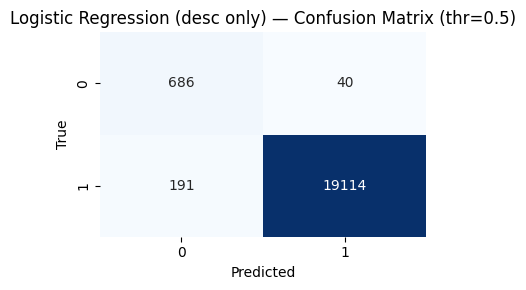

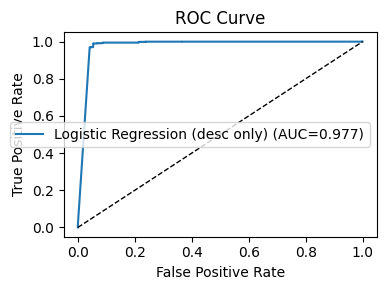

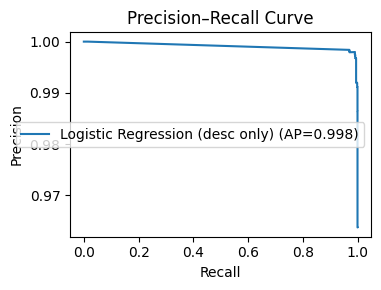


XGBoost (desc only)  ROC AUC: 0.980 | PR AUC: 0.999
              precision    recall  f1-score   support

           0      0.978     0.959     0.968       726
           1      0.998     0.999     0.999     19305

    accuracy                          0.998     20031
   macro avg      0.988     0.979     0.983     20031
weighted avg      0.998     0.998     0.998     20031



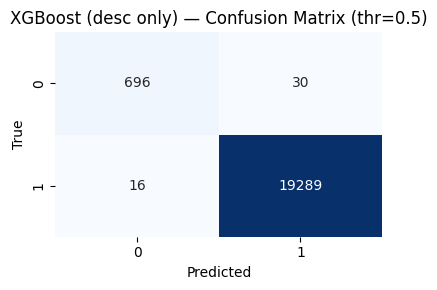

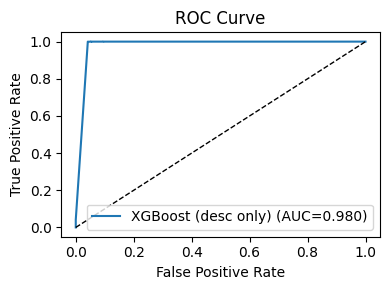

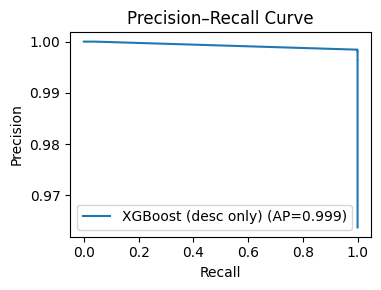


SHAP — feature importance (bar):


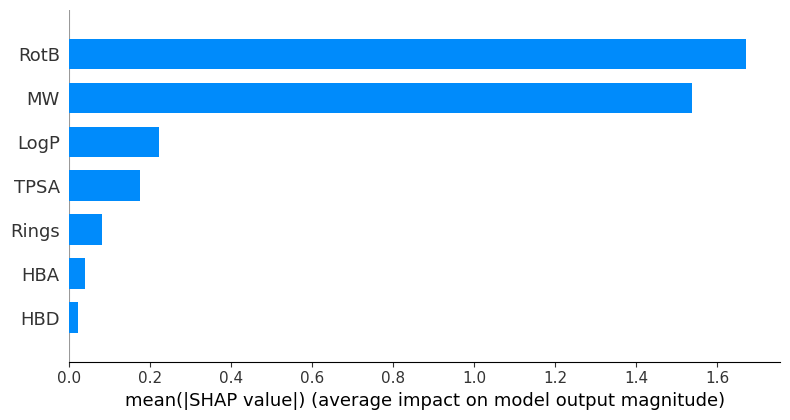

SHAP — beeswarm:


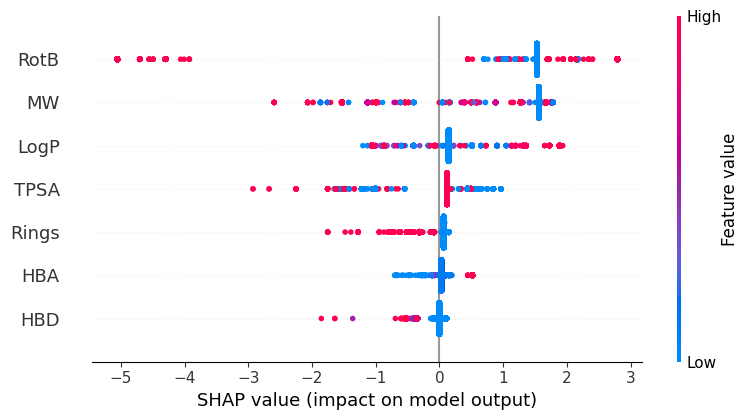

SHAP — single example force plot:


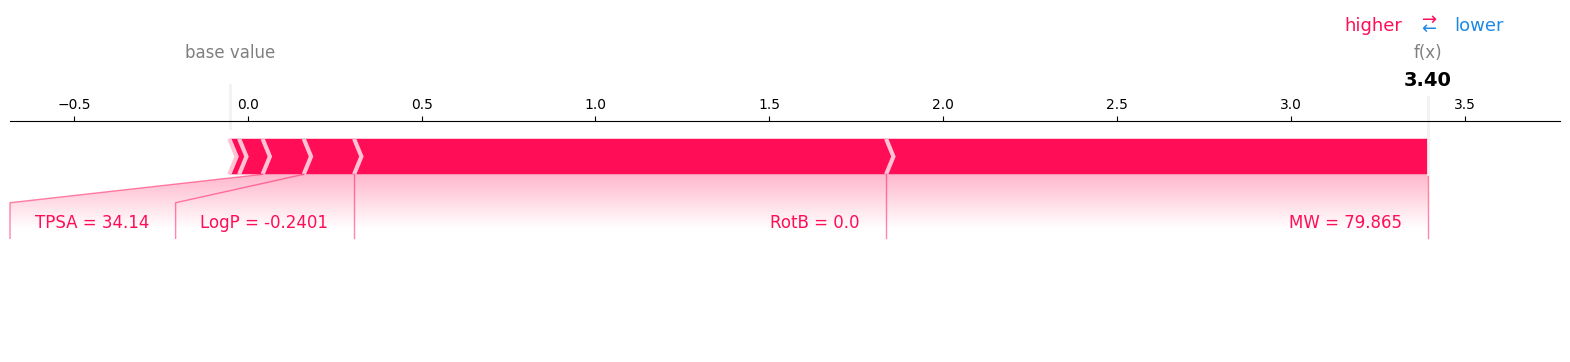

In [25]:
# === Clean baseline modeling + rich visualizations (CancerFlag) ===
# Uses only numeric descriptors to avoid string columns like FP_type / FP_hex.
!pip install scikit-learn xgboost shap matplotlib seaborn --quiet

import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
import xgboost as xgb
import shap

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
REPORT = BASE / 'analysis_reports'
MAIN_PARQ = REPORT / 'main_with_labels.parquet'

# Load
df = pd.read_parquet(MAIN_PARQ)

# Target
TARGET_COL = "CancerFlag"
assert TARGET_COL in df.columns, f"{TARGET_COL} missing"

# Select numeric, robust descriptors only (avoid FP_type and FP_hex)
candidate_feats = ["MW","LogP","TPSA","HBD","HBA","RotB","Rings"]
feature_cols = [c for c in candidate_feats if c in df.columns]
assert len(feature_cols) > 0, "No numeric descriptor columns found."

# Keep rows that have a structure (smiles) and target not-null
df_model = df[df["smiles"].notna()].copy()
df_model = df_model[feature_cols + [TARGET_COL]].dropna()

X = df_model[feature_cols].astype(float)
y = df_model[TARGET_COL].astype(int)

print("Features used:", feature_cols)
print("Class balance (CancerFlag):", dict(y.value_counts()))

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------- Logistic Regression (baseline)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
logreg.fit(X_train_s, y_train)
y_prob_lr = logreg.predict_proba(X_test_s)[:,1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)

# ---------------- XGBoost
pos_w = (y_train.value_counts()[0]/y_train.value_counts()[1]) if (1 in y_train.value_counts()) else 1.0
xgb_model = xgb.XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
    scale_pos_weight=pos_w, tree_method="hist"
)
xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

# ---- Helper to plot & print metrics
def eval_and_plot(y_true, y_prob, y_pred, model_name):
    auc = roc_auc_score(y_true, y_prob)
    ap  = average_precision_score(y_true, y_prob)
    print(f"\n{model_name}  ROC AUC: {auc:.3f} | PR AUC: {ap:.3f}")
    print(classification_report(y_true, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} — Confusion Matrix (thr=0.5)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],"k--", linewidth=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve"); plt.legend()
    plt.tight_layout(); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(4,3))
    plt.plot(rec, prec, label=f"{model_name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve"); plt.legend()
    plt.tight_layout(); plt.show()

eval_and_plot(y_test, y_prob_lr, y_pred_lr, "Logistic Regression (desc only)")
eval_and_plot(y_test, y_prob_xgb, y_pred_xgb, "XGBoost (desc only)")

# ---- SHAP for XGBoost (on descriptors only)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print("\nSHAP — feature importance (bar):")
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type="bar")

print("SHAP — beeswarm:")
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

# One sample explanation
print("SHAP — single example force plot:")
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)

Column sanity check:
 features_mols.parquet columns: ['smiles', 'featurizer', 'MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotB', 'Rings', 'FP_type', 'FP_hex']
 main_with_labels.parquet columns: ['CDPHId', 'ProductName', 'CSFId', 'CSF', 'CompanyId', 'CompanyName', 'BrandName', 'PrimaryCategoryId', 'PrimaryCategory', 'SubCategoryId', 'SubCategory', 'CasId', 'CasNumber', 'ChemicalId', 'ChemicalName', 'InitialDateReported', 'MostRecentDateReported', 'DiscontinuedDate', 'ChemicalCreatedAt', 'ChemicalUpdatedAt', 'ChemicalDateRemoved', 'ChemicalCount', 'canonical_cas', 'norm_name', 'smiles', 'FP_type', 'FP_hex', 'MW', 'LogP', 'TPSA']


[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerator
[22:41:21] DEPRECATION WARNING: please use MorganGenerat

Morgan FP computed for 77 unique SMILES; invalid SMILES: 0
X shape: (100151, 2055) | y shape: (100151,)

Logistic (desc+FP)  ROC AUC: 0.982 | PR AUC: 0.999
              precision    recall  f1-score   support

           0      0.998     0.962     0.980       653
           1      0.999     1.000     0.999     17375

    accuracy                          0.999     18028
   macro avg      0.998     0.981     0.989     18028
weighted avg      0.999     0.999     0.999     18028


XGBoost  (desc+FP)  ROC AUC: 0.981 | PR AUC: 0.999
              precision    recall  f1-score   support

           0      0.998     0.962     0.980       653
           1      0.999     1.000     0.999     17375

    accuracy                          0.999     18028
   macro avg      0.998     0.981     0.989     18028
weighted avg      0.999     0.999     0.999     18028



<Figure size 640x480 with 0 Axes>

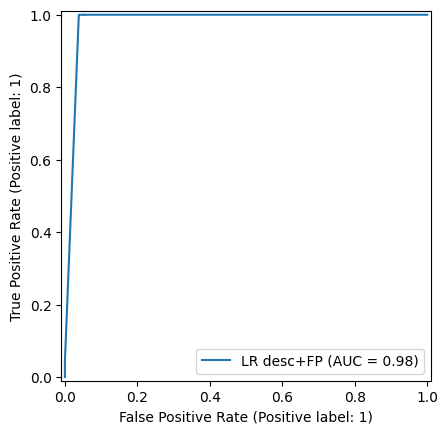

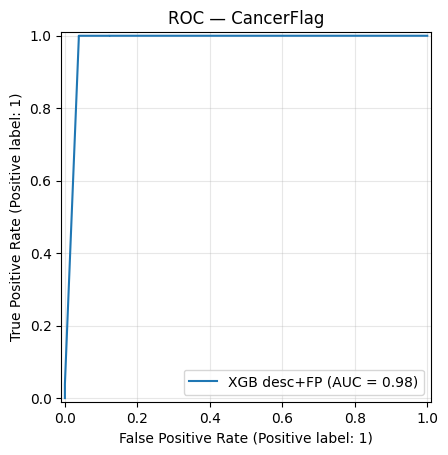

<Figure size 640x480 with 0 Axes>

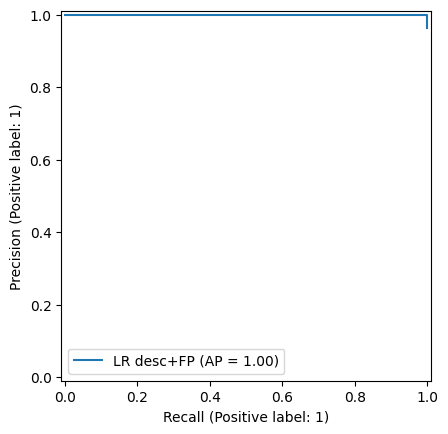

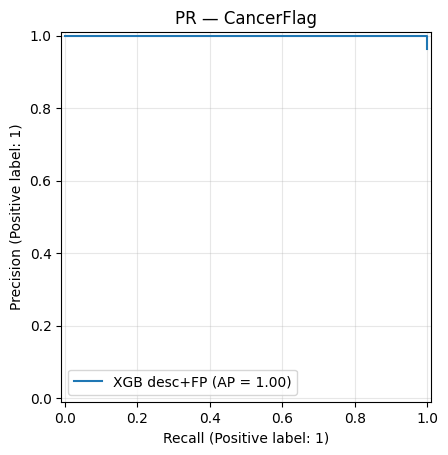

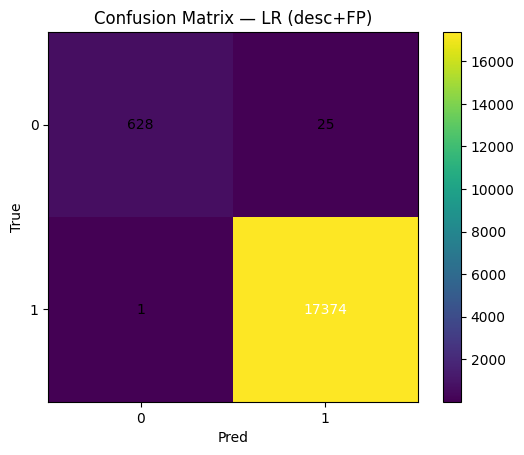

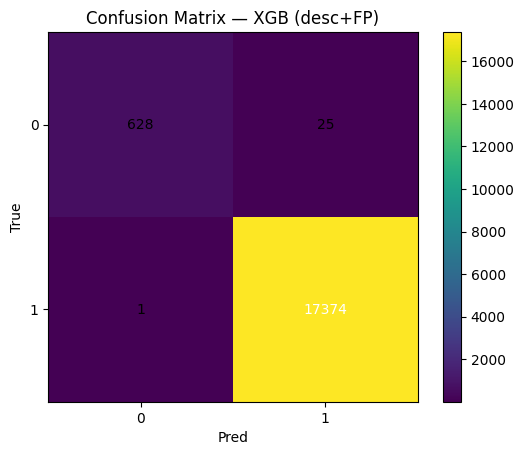

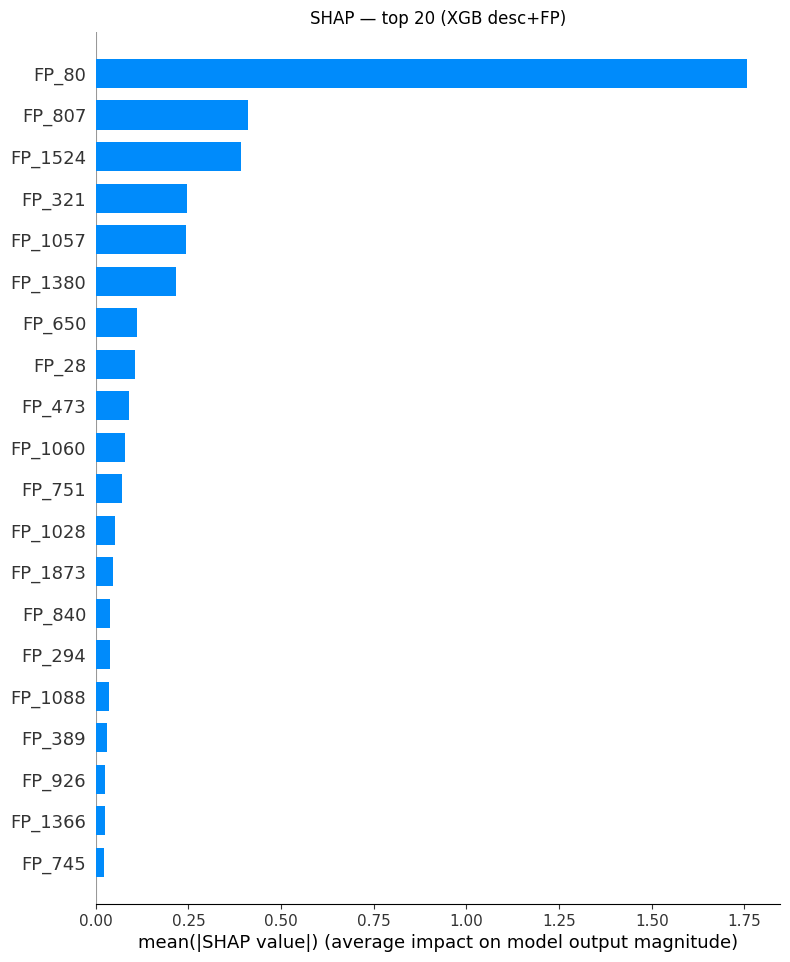

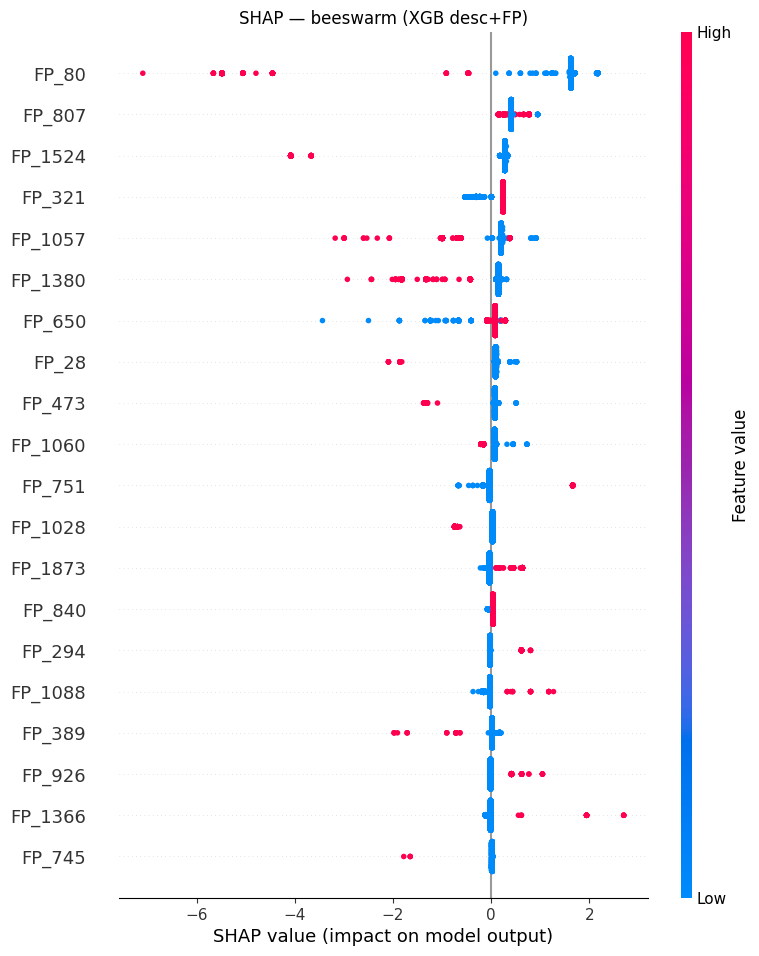


=== Saved artifacts ===
 - ROC: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/roc_desc_fp.png
 - PR : /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/pr_desc_fp.png
 - CM (LR): /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/cm_lr_desc_fp.png
 - CM (XGB): /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/cm_xgb_desc_fp.png
 - SHAP bar: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/shap_bar_xgb_desc_fp.png
 - SHAP beeswarm: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/shap_beeswarm_xgb_desc_fp.png
 - Metrics JSON: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/metrics_desc_fp.json


In [29]:
# === Cell: desc + on-the-fly Morgan fingerprints (handles missing FP_hex) ===
import os, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
RPT  = BASE / 'analysis_reports'
RPT.mkdir(parents=True, exist_ok=True)

FEAT_PARQ = RPT / 'features_mols.parquet'
MAIN_PARQ = RPT / 'main_with_labels.parquet'
assert FEAT_PARQ.exists(), f"Missing {FEAT_PARQ}"
assert MAIN_PARQ.exists(), f"Missing {MAIN_PARQ}"

df_feat = pd.read_parquet(FEAT_PARQ)
df_main = pd.read_parquet(MAIN_PARQ)

print("Column sanity check:")
print(" features_mols.parquet columns:", list(df_feat.columns)[:30])
print(" main_with_labels.parquet columns:", list(df_main.columns)[:30])

# Keep modeling rows
assert "CancerFlag" in df_main.columns, "CancerFlag not found; run the label-building cell first."
df = df_main[df_main["smiles"].notna()].copy()

# Merge descriptors (+ FP_hex if present)
desc_cols = ["MW","LogP","TPSA","HBD","HBA","RotB","Rings"]
cols_to_merge = ["smiles"] + [c for c in desc_cols if c in df_feat.columns]
if "FP_hex" in df_feat.columns:
    cols_to_merge += ["FP_hex"]
df = df.merge(df_feat[cols_to_merge].drop_duplicates("smiles"), on="smiles", how="left")

# --- Build/Decode fingerprints ---
N_BITS = 2048
have_fp_hex = "FP_hex" in df.columns

if have_fp_hex:
    # decode FP_hex (supports either bitstring or hex)
    def decode_fp(s):
        if not isinstance(s, str) or s.strip()=="" or s.lower()=="nan":
            return None
        st = s.strip()
        if set(st) <= {"0","1"} and len(st) >= 64:
            if len(st) > N_BITS: st = st[-N_BITS:]
            elif len(st) < N_BITS: st = ("0"*(N_BITS-len(st))) + st
            return np.frombuffer(st.encode("ascii"), dtype="S1").astype("U1").astype(np.uint8)
        try:
            b = bytes.fromhex(st)
            bits = np.unpackbits(np.frombuffer(b, dtype=np.uint8))
            if bits.size > N_BITS: bits = bits[-N_BITS:]
            elif bits.size < N_BITS: bits = np.pad(bits, (N_BITS-bits.size,0))
            return bits.astype(np.uint8)
        except Exception:
            return None

    uniq_fp = df["FP_hex"].astype(str).dropna().unique().tolist()
    fp_map = {s: (decode_fp(s) if s is not None else None) for s in uniq_fp}
    FP = []
    missing = 0
    for s in df["FP_hex"].astype(str):
        arr = fp_map.get(s)
        if arr is None:
            missing += 1
            arr = np.zeros(N_BITS, dtype=np.uint8)
        FP.append(arr)
    FP = np.vstack(FP)
    print(f"Decoded FP_hex → matrix {FP.shape} | rows with missing FP set to zeros: {missing}")

else:
    # compute Morgan FP per-unique SMILES using RDKit
    try:
        from rdkit import Chem
        from rdkit.Chem import AllChem
    except ImportError:
        !pip install rdkit-pypi -q
        from rdkit import Chem
        from rdkit.Chem import AllChem

    uniq_smiles = df["smiles"].dropna().unique().tolist()
    smi_to_fp = {}
    bad = 0
    for s in uniq_smiles:
        m = Chem.MolFromSmiles(s)
        if m is None:
            bad += 1
            smi_to_fp[s] = np.zeros(N_BITS, dtype=np.uint8)
            continue
        bv = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=N_BITS)
        arr = np.zeros((N_BITS,), dtype=np.uint8)
        # fill ones where bits are set
        onbits = list(bv.GetOnBits())
        arr[onbits] = 1
        smi_to_fp[s] = arr
    print(f"Morgan FP computed for {len(uniq_smiles)} unique SMILES; invalid SMILES: {bad}")

    FP = np.vstack([smi_to_fp.get(s, np.zeros(N_BITS, dtype=np.uint8)) for s in df["smiles"]])

# --- Assemble features X and label y ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score, classification_report,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# descriptors (fill 0 if any missing), then standardize
for c in desc_cols:
    if c not in df.columns:
        df[c] = 0.0
desc = df[desc_cols].astype(float).fillna(0.0).values
scaler = StandardScaler()
desc_z = scaler.fit_transform(desc)

X = np.hstack([desc_z, FP.astype(np.float32)])
y = df["CancerFlag"].astype(int).values
print("X shape:", X.shape, "| y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.18, random_state=42, stratify=y
)

# Logistic (calibrated)
cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
cw = {int(c): float(w) for c,w in zip(np.unique(y_train), cw)}
lr = LogisticRegression(solver="liblinear", max_iter=2000, class_weight=cw)
clr = CalibratedClassifierCV(lr, method="isotonic", cv=3)
clr.fit(X_train, y_train)
proba_lr = clr.predict_proba(X_test)[:,1]
pred_lr  = (proba_lr>=0.5).astype(int)
roc_lr = roc_auc_score(y_test, proba_lr)
pr_lr  = average_precision_score(y_test, proba_lr)

# XGBoost
try:
    import xgboost as xgb
except ImportError:
    !pip install xgboost -q
    import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective="binary:logistic", tree_method="hist",
    n_jobs=-1, random_state=42
)
xgb_clf.fit(X_train, y_train)
proba_xgb = xgb_clf.predict_proba(X_test)[:,1]
pred_xgb  = (proba_xgb>=0.5).astype(int)
roc_xgb = roc_auc_score(y_test, proba_xgb)
pr_xgb  = average_precision_score(y_test, proba_xgb)

def report(name, y_true, y_pred, y_prob):
    print(f"\n{name}  ROC AUC: {roc_auc_score(y_true, y_prob):.3f} | PR AUC: {average_precision_score(y_true, y_prob):.3f}")
    print(classification_report(y_true, y_pred, digits=3))
    return confusion_matrix(y_true, y_pred)

cm_lr  = report("Logistic (desc+FP)", y_test, pred_lr,  proba_lr)
cm_xgb = report("XGBoost  (desc+FP)", y_test, pred_xgb, proba_xgb)

# Plots
plt.figure()
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LR desc+FP")
RocCurveDisplay.from_predictions(y_test, proba_xgb, name="XGB desc+FP")
plt.title("ROC — CancerFlag")
plt.grid(True, alpha=0.3)
plt.savefig(RPT/"roc_desc_fp.png", dpi=160, bbox_inches="tight"); plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="LR desc+FP")
PrecisionRecallDisplay.from_predictions(y_test, proba_xgb, name="XGB desc+FP")
plt.title("PR — CancerFlag")
plt.grid(True, alpha=0.3)
plt.savefig(RPT/"pr_desc_fp.png", dpi=160, bbox_inches="tight"); plt.show()

def plot_cm(cm, title, fname):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(2); plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    thresh = cm.max()/2
    for i in range(2):
        for j in range(2):
            plt.text(j, i, int(cm[i,j]), ha='center', va='center',
                     color='white' if cm[i,j]>thresh else 'black')
    plt.ylabel('True'); plt.xlabel('Pred')
    plt.savefig(RPT/fname, dpi=160, bbox_inches="tight"); plt.show()

plot_cm(cm_lr,  "Confusion Matrix — LR (desc+FP)",  "cm_lr_desc_fp.png")
plot_cm(cm_xgb, "Confusion Matrix — XGB (desc+FP)", "cm_xgb_desc_fp.png")

# SHAP for XGB
try:
    import shap
except ImportError:
    !pip install shap -q
    import shap

fp_names = [f"FP_{i}" for i in range(N_BITS)]
feat_names = desc_cols + fp_names
explainer = shap.TreeExplainer(xgb_clf)
subset = min(4000, X_test.shape[0])
shap_values = explainer.shap_values(X_test[:subset])

plt.figure()
shap.summary_plot(shap_values, X_test[:subset], feature_names=feat_names, plot_type="bar", max_display=20, show=False)
plt.title("SHAP — top 20 (XGB desc+FP)")
plt.savefig(RPT/"shap_bar_xgb_desc_fp.png", dpi=160, bbox_inches="tight"); plt.show()

plt.figure()
shap.summary_plot(shap_values, X_test[:subset], feature_names=feat_names, max_display=20, show=False)
plt.title("SHAP — beeswarm (XGB desc+FP)")
plt.savefig(RPT/"shap_beeswarm_xgb_desc_fp.png", dpi=160, bbox_inches="tight"); plt.show()

# Save metrics
metrics = {
    "logistic_desc_fp": {"roc_auc": float(roc_lr), "pr_auc": float(pr_lr), "cm": cm_lr.tolist()},
    "xgb_desc_fp":      {"roc_auc": float(roc_xgb), "pr_auc": float(pr_xgb), "cm": cm_xgb.tolist()},
    "n_samples": int(df.shape[0]),
    "n_features_total": int(X.shape[1]),
    "desc_features": desc_cols,
    "fp_bits": N_BITS
}
with open(RPT/"metrics_desc_fp.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\n=== Saved artifacts ===")
print(" - ROC:", RPT / "roc_desc_fp.png")
print(" - PR :", RPT / "pr_desc_fp.png")
print(" - CM (LR):", RPT / "cm_lr_desc_fp.png")
print(" - CM (XGB):", RPT / "cm_xgb_desc_fp.png")
print(" - SHAP bar:", RPT / "shap_bar_xgb_desc_fp.png")
print(" - SHAP beeswarm:", RPT / "shap_beeswarm_xgb_desc_fp.png")
print(" - Metrics JSON:", RPT / "metrics_desc_fp.json")

In [30]:
# Cell R1: ReproFlag prep + leak-proof group splits by canonical_cas

import json, math, random
from pathlib import Path
import numpy as np
import pandas as pd

# Paths
BASE = Path('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics')
AR   = BASE / 'analysis_reports'
AR.mkdir(parents=True, exist_ok=True)

MAIN_PATH = AR / 'main_with_labels.parquet'   # you created this earlier in the label-building step

# Read
df = pd.read_parquet(MAIN_PATH)
print('Loaded:', MAIN_PATH, '| shape:', df.shape)

# Sanity checks
required_cols = ['canonical_cas','smiles','ReproFlag']
missing = [c for c in required_cols if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

# Quick NA handling
df['canonical_cas'] = df['canonical_cas'].astype(str)
df['ReproFlag'] = df['ReproFlag'].fillna(0).astype(int)

# Only rows with a structure can be modeled
df_model = df[df['smiles'].notna()].copy()
print('Rows with SMILES:', df_model.shape[0], 'out of', df.shape[0])

# Group level (by CAS)
grp = df_model.groupby('canonical_cas')['ReproFlag'].agg(['count','sum']).rename(columns={'sum':'pos'})
grp['has_pos'] = (grp['pos'] > 0).astype(int)

n_groups = grp.shape[0]
n_pos_groups = int(grp['has_pos'].sum())
n_neg_groups = n_groups - n_pos_groups
print(f'Unique CAS groups: {n_groups} | groups with >=1 positive row: {n_pos_groups} | negative-only groups: {n_neg_groups}')

# Target split ratios
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Separate CAS groups by label presence
pos_cas = grp[grp['has_pos']==1].index.tolist()
neg_cas = grp[grp['has_pos']==0].index.tolist()

random.seed(7)
random.shuffle(pos_cas)
random.shuffle(neg_cas)

def split_list(L, r_train, r_val, r_test):
    n = len(L)
    n_train = max(1, int(round(n*r_train)))
    n_val   = max(1, int(round(n*r_val)))
    n_test  = max(1, n - n_train - n_val)
    # adjust if rounding issues
    while n_train + n_val + n_test > n:
        n_test -= 1
    while n_train + n_val + n_test < n:
        n_test += 1
    return L[:n_train], L[n_train:n_train+n_val], L[n_train+n_val:]

# Split pos groups to ensure each split has positives
pos_train, pos_val, pos_test = split_list(pos_cas, train_ratio, val_ratio, test_ratio)

# Split neg groups by ratio
neg_train, neg_val, neg_test = split_list(neg_cas, train_ratio, val_ratio, test_ratio)

# Combine
train_cas = set(pos_train) | set(neg_train)
val_cas   = set(pos_val)   | set(neg_val)
test_cas  = set(pos_test)  | set(neg_test)

# Safety: ensure disjoint
assert len(train_cas & val_cas) == 0 and len(train_cas & test_cas) == 0 and len(val_cas & test_cas) == 0, "Overlap among splits!"

def slice_by_cas(cas_set):
    return df_model[df_model['canonical_cas'].isin(cas_set)].copy()

df_train = slice_by_cas(train_cas)
df_val   = slice_by_cas(val_cas)
df_test  = slice_by_cas(test_cas)

def balance_report(tag, d):
    y = d['ReproFlag'].astype(int)
    pos = int((y==1).sum()); neg = int((y==0).sum())
    rate = pos / max(1, (pos+neg))
    groups = d['canonical_cas'].nunique()
    pos_groups = d.groupby('canonical_cas')['ReproFlag'].max().sum()
    return {
        'rows': int(d.shape[0]),
        'groups': int(groups),
        'pos_rows': pos, 'neg_rows': neg, 'pos_rate': float(rate),
        'pos_groups': int(pos_groups)
    }

summary = {
    'overall': balance_report('overall', df_model),
    'train':   balance_report('train', df_train),
    'val':     balance_report('val', df_val),
    'test':    balance_report('test', df_test),
    'n_pos_groups_total': n_pos_groups,
    'n_neg_groups_total': n_neg_groups
}

print('\n=== Split summary (grouped by canonical_cas) ===')
print(json.dumps(summary, indent=2))

# Save split CAS lists (for reproducibility) and small previews
(AR / 'repro_split_train_cas.txt').write_text('\n'.join(sorted(train_cas)))
(AR / 'repro_split_val_cas.txt').write_text('\n'.join(sorted(val_cas)))
(AR / 'repro_split_test_cas.txt').write_text('\n'.join(sorted(test_cas)))

df_train[['canonical_cas','ReproFlag']].head(10).to_csv(AR / 'repro_train_preview.csv', index=False)
df_val[['canonical_cas','ReproFlag']].head(10).to_csv(AR / 'repro_val_preview.csv', index=False)
df_test[['canonical_cas','ReproFlag']].head(10).to_csv(AR / 'repro_test_preview.csv', index=False)

print('\nSaved:')
print(' -', AR / 'repro_split_train_cas.txt')
print(' -', AR / 'repro_split_val_cas.txt')
print(' -', AR / 'repro_split_test_cas.txt')
print(' -', AR / 'repro_train_preview.csv')
print(' -', AR / 'repro_val_preview.csv')
print(' -', AR / 'repro_test_preview.csv')

# Quick sanity: show positive groups per split (counts only)
print('\nPositive groups per split:')
print(' train:', int(df_train.groupby("canonical_cas")["ReproFlag"].max().sum()))
print('   val:', int(df_val.groupby("canonical_cas")["ReproFlag"].max().sum()))
print('  test:', int(df_test.groupby("canonical_cas")["ReproFlag"].max().sum()))

Loaded: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/main_with_labels.parquet | shape: (112870, 36)
Rows with SMILES: 100151 out of 112870
Unique CAS groups: 83 | groups with >=1 positive row: 14 | negative-only groups: 69

=== Split summary (grouped by canonical_cas) ===
{
  "overall": {
    "rows": 100151,
    "groups": 83,
    "pos_rows": 188,
    "neg_rows": 99963,
    "pos_rate": 0.0018771654801250112,
    "pos_groups": 14
  },
  "train": {
    "rows": 4523,
    "groups": 49,
    "pos_rows": 91,
    "neg_rows": 4432,
    "pos_rate": 0.02011938978554057,
    "pos_groups": 8
  },
  "val": {
    "rows": 94810,
    "groups": 17,
    "pos_rows": 83,
    "neg_rows": 94727,
    "pos_rate": 0.0008754350806876912,
    "pos_groups": 3
  },
  "test": {
    "rows": 818,
    "groups": 17,
    "pos_rows": 14,
    "neg_rows": 804,
    "pos_rate": 0.017114914425427872,
    "pos_groups": 3
  },
  "n_pos_groups_total": 14,
  "n_neg_groups_total": 69
}

Saved:
 - /conte

In [31]:
# Cell R2 — ReproFlag training & evaluation (CAS-wise splits, desc + fingerprints + SHAP)

!pip -q install xgboost shap

import json, math, re, os, io
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
import shap

# ---------- Paths & constants ----------
BASE = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
RPT  = BASE / "analysis_reports"
RPT.mkdir(parents=True, exist_ok=True)

MAIN_W_LABELS = RPT / "main_with_labels.parquet"
SPL_TRAIN = RPT / "repro_split_train_cas.txt"
SPL_VAL   = RPT / "repro_split_val_cas.txt"
SPL_TEST  = RPT / "repro_split_test_cas.txt"

DESC_COLS = ["MW","LogP","TPSA","HBD","HBA","RotB","Rings"]
FP_COL    = "FP_hex"
FP_TYPE   = "Morgan2048_r2"  # fallback; we try to parse from column if needed
TARGET    = "ReproFlag"
RAND      = 42

# ---------- Helpers ----------
def parse_fp_bits_from_type(fp_type: str) -> int:
    if not isinstance(fp_type, str):
        return 2048
    m = re.search(r"(\d+)", fp_type)
    return int(m.group(1)) if m else 2048

def hex_to_bits(hex_str: str, nbits: int = 2048) -> np.ndarray:
    """Decode hex->bits length nbits."""
    if not isinstance(hex_str, str) or not hex_str.strip():
        return np.zeros(nbits, dtype=np.uint8)
    try:
        b = bytes.fromhex(hex_str.strip())
        bits = np.unpackbits(np.frombuffer(b, dtype=np.uint8))
        # length may exceed nbits because RDKit pads up to full bytes; trim or pad
        if bits.size >= nbits:
            return bits[:nbits].astype(np.uint8)
        out = np.zeros(nbits, dtype=np.uint8)
        out[:bits.size] = bits
        return out
    except Exception:
        return np.zeros(nbits, dtype=np.uint8)

def load_split_ids(path_txt: Path) -> set:
    if not path_txt.exists():
        return set()
    items = [ln.strip() for ln in open(path_txt, "r", encoding="utf-8").read().splitlines() if ln.strip()]
    return set(items)

def plot_roc_pr(y_true, y_prob, save_prefix: Path):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_roc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC — ReproFlag")
    plt.legend(loc="lower right")
    out_roc = save_prefix.with_suffix(".png")
    plt.savefig(out_roc, dpi=160, bbox_inches="tight"); plt.close()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    auc_pr = average_precision_score(y_true, y_prob)
    plt.figure()
    plt.plot(rec, prec, label=f"PR AUC = {auc_pr:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR — ReproFlag")
    plt.legend(loc="lower left")
    out_pr = save_prefix.parent / (save_prefix.stem.replace("roc","pr") + ".png")
    plt.savefig(out_pr, dpi=160, bbox_inches="tight"); plt.close()
    return float(auc_roc), float(auc_pr), out_roc, out_pr

def best_f1_threshold(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = (2*prec*rec) / (prec+rec + 1e-12)
    idx = np.nanargmax(f1)
    # precision_recall_curve outputs thresholds one shorter than prec/rec
    best_thr = thr[idx-1] if idx>0 and idx-1 < len(thr) else 0.5
    return float(best_thr), float(np.nanmax(f1))

def show_and_save_cm(y_true, y_prob, threshold, title, outpath: Path):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["0","1"]); plt.yticks(ticks, ["0","1"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, str(val), ha="center", va="center", color="white" if val>cm.max()/2 else "black")
    plt.savefig(outpath, dpi=160, bbox_inches="tight"); plt.close()
    return cm

def calibration_plot(y_true, y_prob, outpath: Path):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=20, strategy="uniform")
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label="Model")
    plt.plot([0,1],[0,1], "--", label="Ideal")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title("Calibration — ReproFlag")
    plt.legend()
    plt.savefig(outpath, dpi=160, bbox_inches="tight"); plt.close()

# ---------- Load data ----------
df = pd.read_parquet(MAIN_W_LABELS)
for c in ["canonical_cas", "smiles", TARGET, "FP_type", FP_COL] + DESC_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

# Focus on rows with SMILES & fingerprints
df = df[df["smiles"].notna()].copy()

# Determine fingerprint length from FP_type (fallback 2048)
fp_type_first = df["FP_type"].dropna().astype(str).iloc[0] if df["FP_type"].notna().any() else FP_TYPE
NBITS = parse_fp_bits_from_type(fp_type_first)

# Build feature matrix: descriptors + decoded FP
desc = df[DESC_COLS].astype(float).fillna(0.0).to_numpy()
# decode FP_hex → bits (vectorized-ish)
fps_bits = np.vstack([hex_to_bits(s, NBITS) for s in df[FP_COL].astype(str).fillna("")])
X_all = np.hstack([desc, fps_bits]).astype(np.float32)
y_all = df[TARGET].astype(int).to_numpy()

# ---------- Build CAS-wise splits ----------
train_ids = load_split_ids(SPL_TRAIN)
val_ids   = load_split_ids(SPL_VAL)
test_ids  = load_split_ids(SPL_TEST)

mask_train = df["canonical_cas"].isin(train_ids).to_numpy()
mask_val   = df["canonical_cas"].isin(val_ids).to_numpy()
mask_test  = df["canonical_cas"].isin(test_ids).to_numpy()

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_val,   y_val   = X_all[mask_val],   y_all[mask_val]
X_test,  y_test  = X_all[mask_test],  y_all[mask_test]

print("Shapes — X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)
print("Positives — train:", y_train.sum(), "val:", y_val.sum(), "test:", y_test.sum())

# ---------- Class weights / imbalance handling ----------
# Logistic: class_weight="balanced"
# XGB: scale_pos_weight = neg/pos (on TRAIN only)
pos = max(y_train.sum(), 1)
neg = max((y_train==0).sum(), 1)
scale_pos_weight = neg / pos
print(f"scale_pos_weight for XGB (train neg/pos): {scale_pos_weight:.2f}")

# ---------- Train Logistic Regression ----------
lr = LogisticRegression(
    penalty="l2", solver="lbfgs", max_iter=2000,
    class_weight="balanced", random_state=RAND, n_jobs=-1
)
lr.fit(X_train, y_train)
p_val_lr  = lr.predict_proba(X_val)[:,1]
p_test_lr = lr.predict_proba(X_test)[:,1]

# ---------- Train XGBoost ----------
xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=RAND,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
p_val_xgb  = xgb_model.predict_proba(X_val)[:,1]
p_test_xgb = xgb_model.predict_proba(X_test)[:,1]

# ---------- Metrics & plots (VAL + TEST) ----------
metrics = {}

def evaluate_split(split_name, y_true, p_lr, p_xgb):
    out_prefix_lr  = RPT / f"repro_{split_name}_roc_lr"
    out_prefix_xgb = RPT / f"repro_{split_name}_roc_xgb"

    roc_lr, pr_lr, roc_path_lr, pr_path_lr   = plot_roc_pr(y_true, p_lr,  out_prefix_lr)
    roc_xg, pr_xg, roc_path_xg, pr_path_xg   = plot_roc_pr(y_true, p_xgb, out_prefix_xgb)

    thr_lr, f1_lr  = best_f1_threshold(y_true, p_lr)
    thr_xg, f1_xg  = best_f1_threshold(y_true, p_xgb)

    cm_lr_05  = show_and_save_cm(y_true, p_lr, 0.5, f"LR CM @0.5 ({split_name})", RPT/f"repro_{split_name}_cm_lr_05.png")
    cm_lr_f1  = show_and_save_cm(y_true, p_lr, thr_lr, f"LR CM @bestF1={thr_lr:.3f} ({split_name})", RPT/f"repro_{split_name}_cm_lr_bestf1.png")
    cm_xg_05  = show_and_save_cm(y_true, p_xgb, 0.5, f"XGB CM @0.5 ({split_name})", RPT/f"repro_{split_name}_cm_xgb_05.png")
    cm_xg_f1  = show_and_save_cm(y_true, p_xgb, thr_xg, f"XGB CM @bestF1={thr_xg:.3f} ({split_name})", RPT/f"repro_{split_name}_cm_xgb_bestf1.png")

    # classification report at 0.5
    y_lr_05 = (p_lr>=0.5).astype(int)
    y_xg_05 = (p_xgb>=0.5).astype(int)
    cr_lr = classification_report(y_true, y_lr_05, digits=3, output_dict=True)
    cr_xg = classification_report(y_true, y_xg_05, digits=3, output_dict=True)

    # calibration
    calibration_plot(y_true, p_lr,  RPT/f"repro_{split_name}_calib_lr.png")
    calibration_plot(y_true, p_xgb, RPT/f"repro_{split_name}_calib_xgb.png")

    return {
        "roc_auc": {"lr": roc_lr, "xgb": roc_xg},
        "pr_auc":  {"lr": pr_lr, "xgb": pr_xg},
        "best_f1": {"lr": {"thr": thr_lr, "f1": f1_lr}, "xgb": {"thr": thr_xg, "f1": f1_xg}},
        "cm@0.5":  {"lr": cm_lr_05.tolist(), "xgb": cm_xg_05.tolist()},
        "cm@bestF1": {"lr": cm_lr_f1.tolist(), "xgb": cm_xg_f1.tolist()},
        "cls_report@0.5": {"lr": cr_lr, "xgb": cr_xg}
    }

metrics["val"]  = evaluate_split("val",  y_val,  p_val_lr,  p_val_xgb)
metrics["test"] = evaluate_split("test", y_test, p_test_lr, p_test_xgb)

# ---------- SHAP on VAL (subsample for speed) ----------
# Use only descriptor features for SHAP readability OR the whole set (desc+fp).
# We'll explain XGB with TreeExplainer on a small subsample.
shap_sample_n = min(2000, X_val.shape[0])
perm = np.random.RandomState(RAND).permutation(X_val.shape[0])[:shap_sample_n]
X_val_s = X_val[perm]
explainer = shap.TreeExplainer(xgb_model, feature_perturbation="tree_path_dependent")
# Build feature names: desc + fp_i
fp_names = [f"fp_{i}" for i in range(fps_bits.shape[1])]
feature_names = DESC_COLS + fp_names
shap_values = explainer.shap_values(X_val_s)

# SHAP bar (top 25)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_val_s, feature_names=feature_names, plot_type="bar", max_display=25, show=False)
plt.title("SHAP feature importance (XGB, ReproFlag, top 25)")
plt.tight_layout()
plt.savefig(RPT/"repro_shap_bar_xgb.png", dpi=160, bbox_inches="tight"); plt.close()

# SHAP beeswarm (top 25)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_val_s, feature_names=feature_names, max_display=25, show=False)
plt.title("SHAP beeswarm (XGB, ReproFlag, top 25)")
plt.tight_layout()
plt.savefig(RPT/"repro_shap_beeswarm_xgb.png", dpi=160, bbox_inches="tight"); plt.close()

# ---------- Save metrics ----------
with open(RPT/"repro_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\n=== ReproFlag metrics (VAL) ===")
print(json.dumps(metrics["val"], indent=2))
print("\n=== ReproFlag metrics (TEST) ===")
print(json.dumps(metrics["test"], indent=2))

print("\nSaved figures & metrics to:", RPT)

Shapes — X_train: (4523, 2055) X_val: (94802, 2055) X_test: (818, 2055)
Positives — train: 91 val: 83 test: 14
scale_pos_weight for XGB (train neg/pos): 48.70

=== ReproFlag metrics (VAL) ===
{
  "roc_auc": {
    "lr": 0.9948163731478665,
    "xgb": 0.9993192292178883
  },
  "pr_auc": {
    "lr": 0.8133125658527647,
    "xgb": 0.8142970487309884
  },
  "best_f1": {
    "lr": {
      "thr": 0.3371453904773813,
      "f1": 0.893333333332839
    },
    "xgb": {
      "thr": 0.27322596311569214,
      "f1": 0.8630136986296463
    }
  },
  "cm@0.5": {
    "lr": [
      [
        94719,
        0
      ],
      [
        20,
        63
      ]
    ],
    "xgb": [
      [
        94719,
        0
      ],
      [
        20,
        63
      ]
    ]
  },
  "cm@bestF1": {
    "lr": [
      [
        94712,
        7
      ],
      [
        16,
        67
      ]
    ],
    "xgb": [
      [
        94712,
        7
      ],
      [
        20,
        63
      ]
    ]
  },
  "cls_report@0.5": 

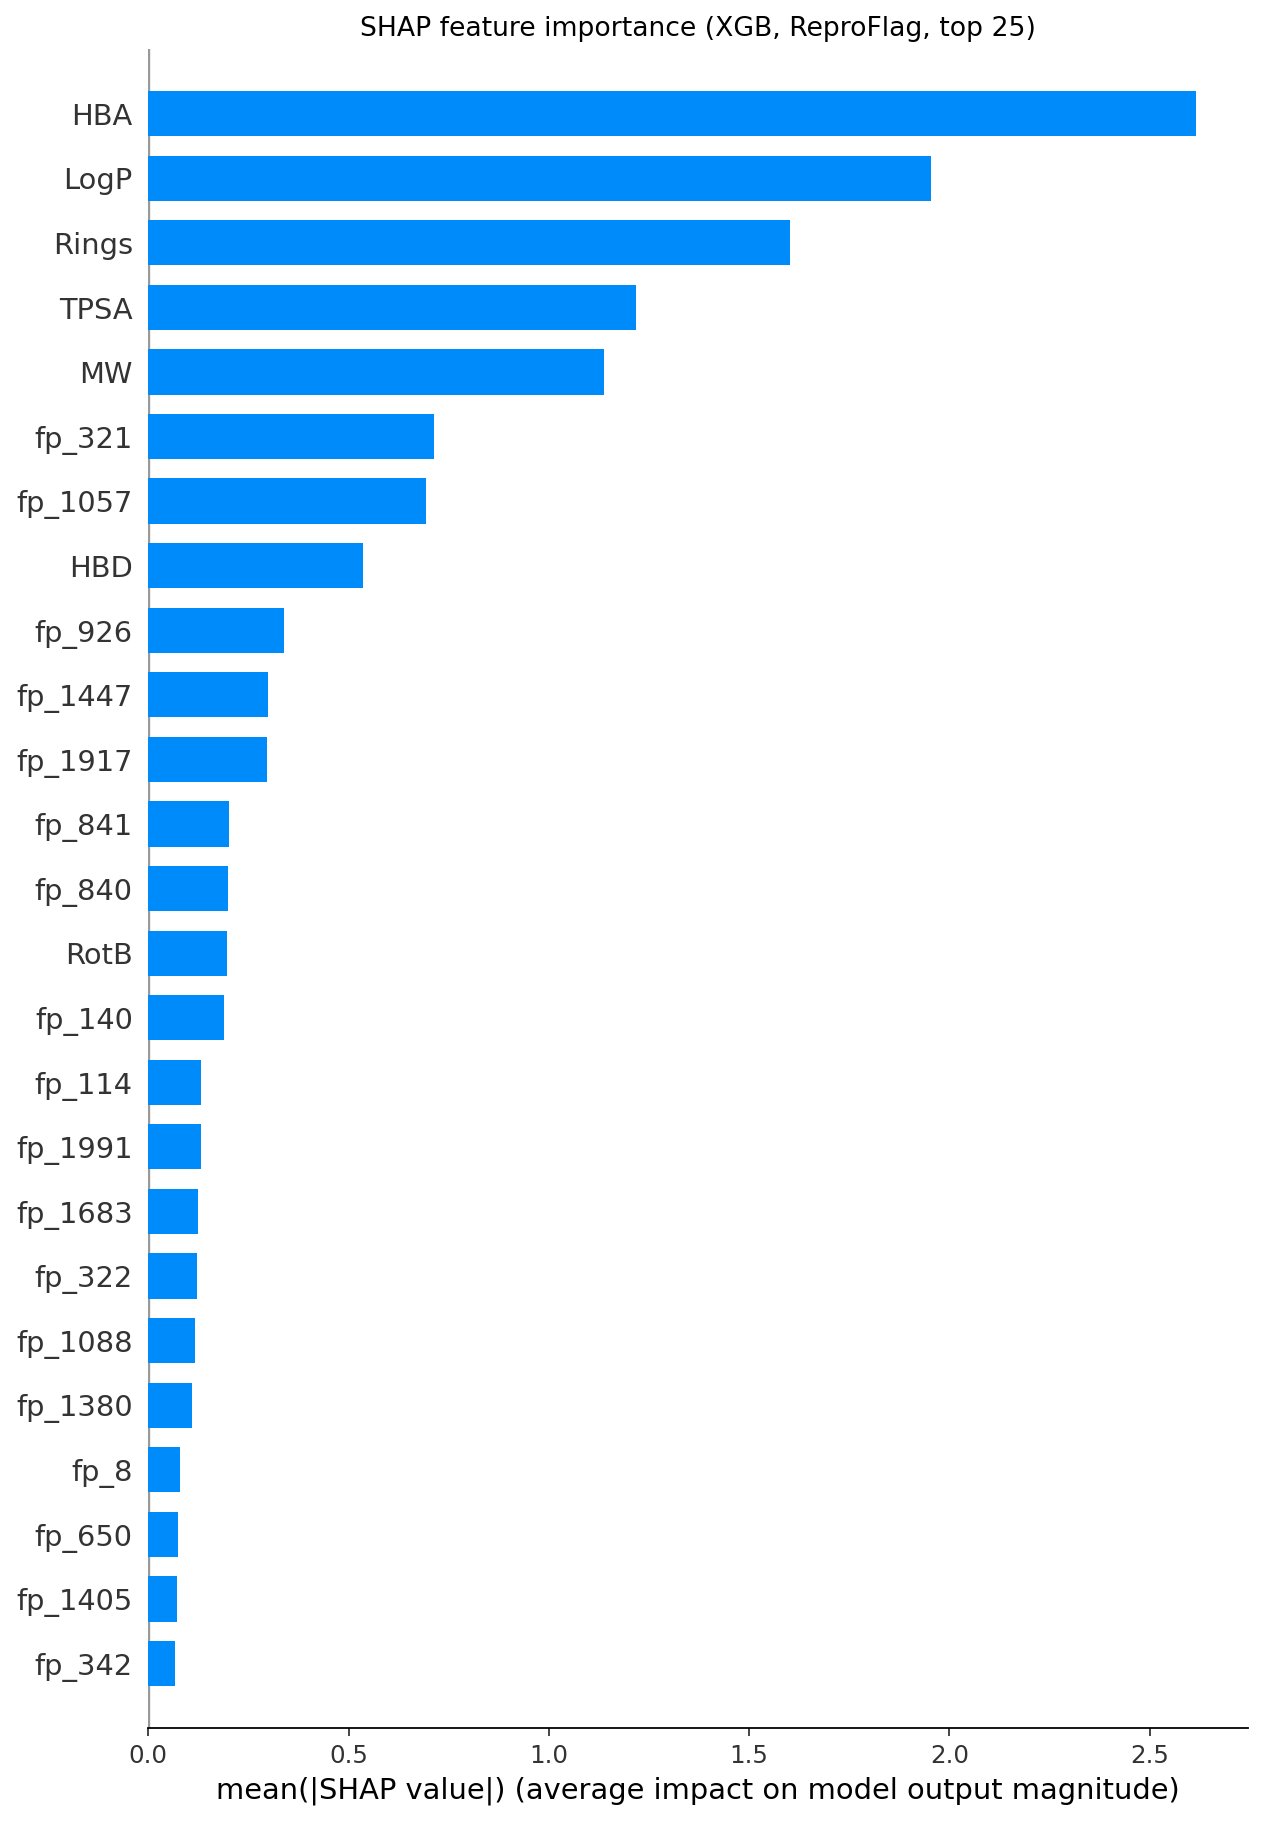

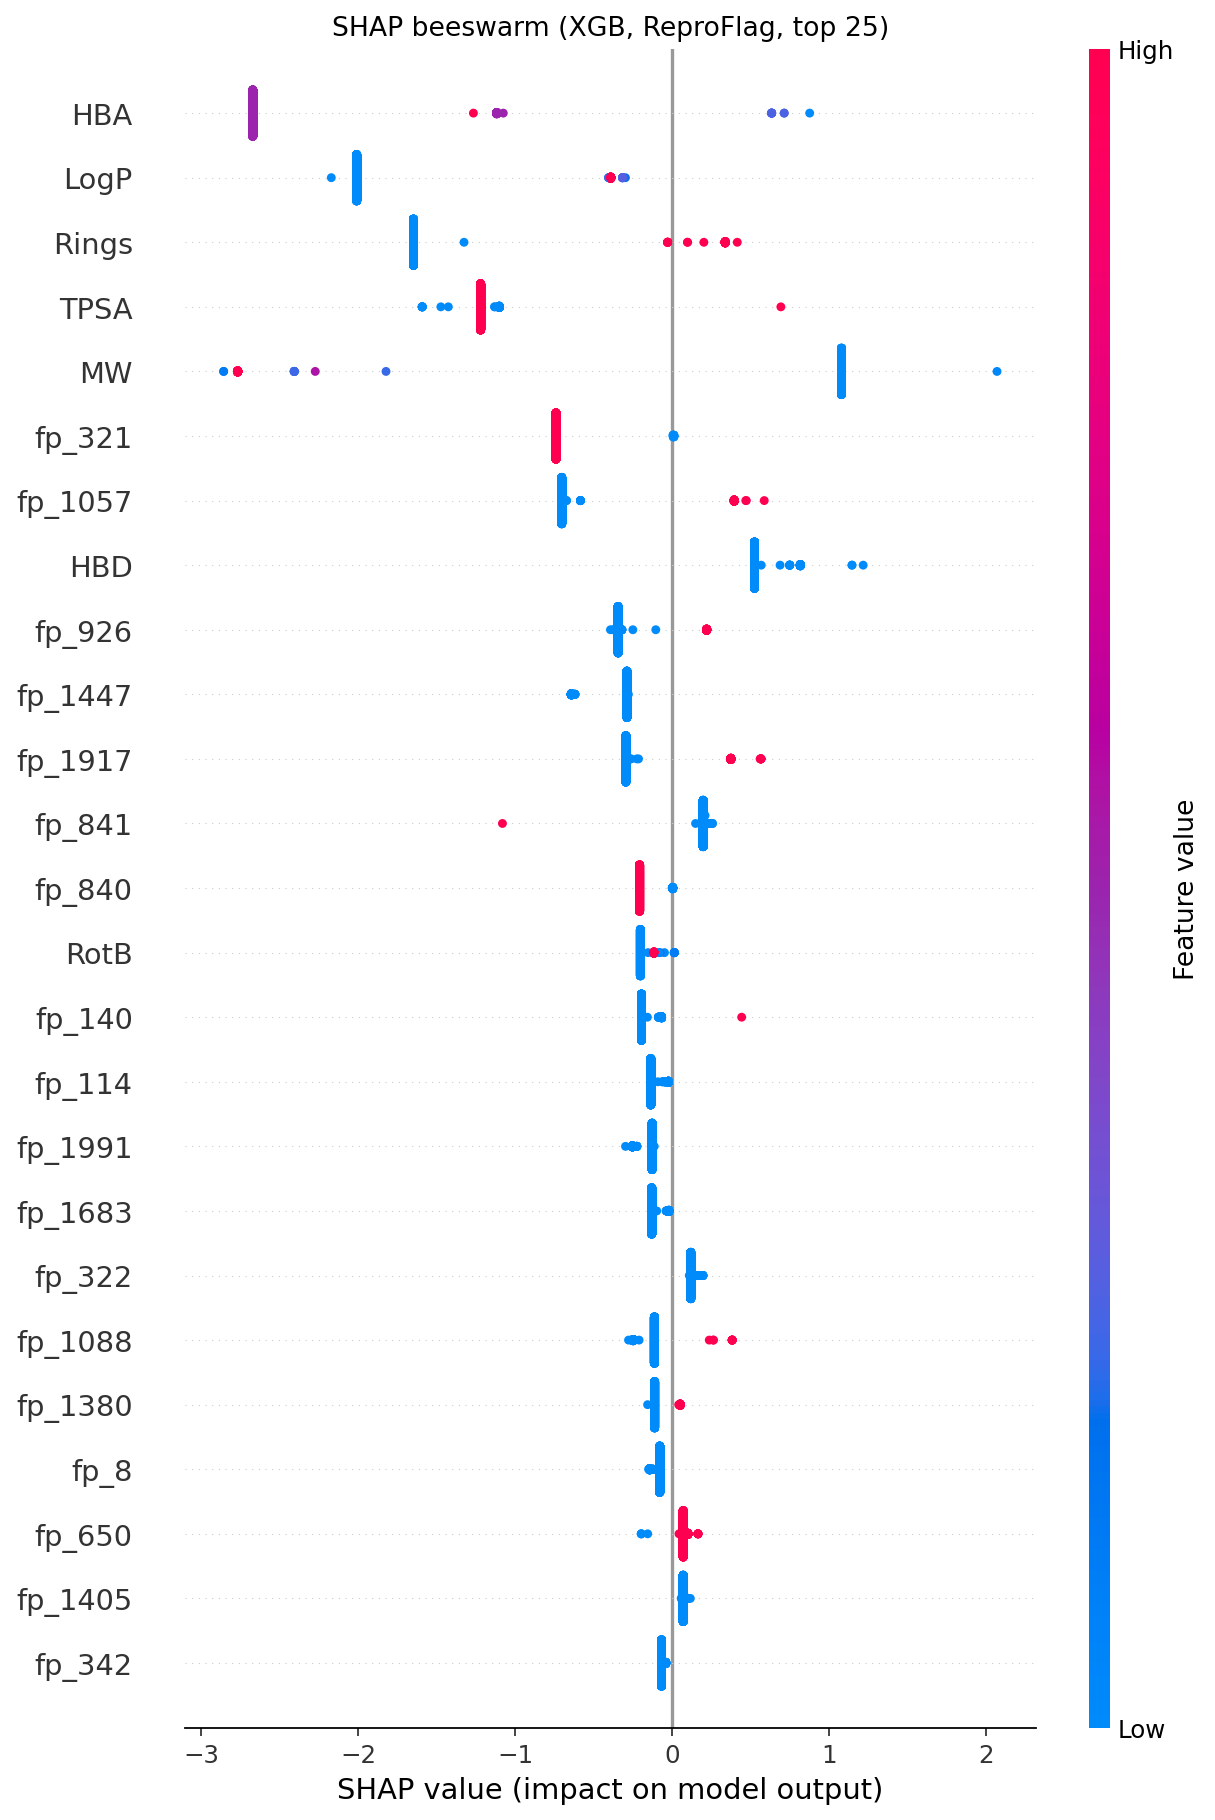

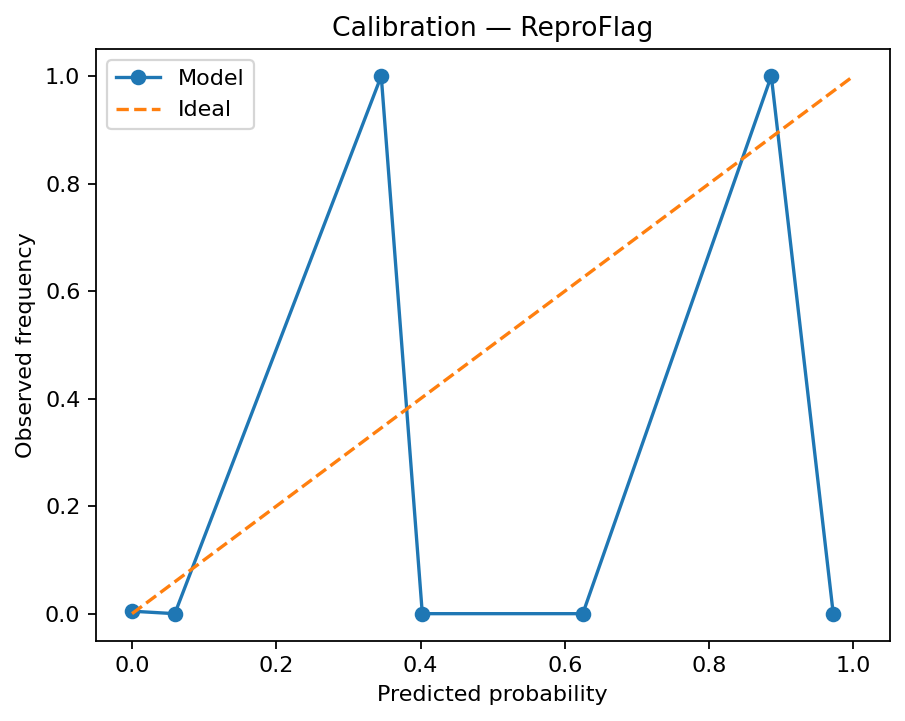

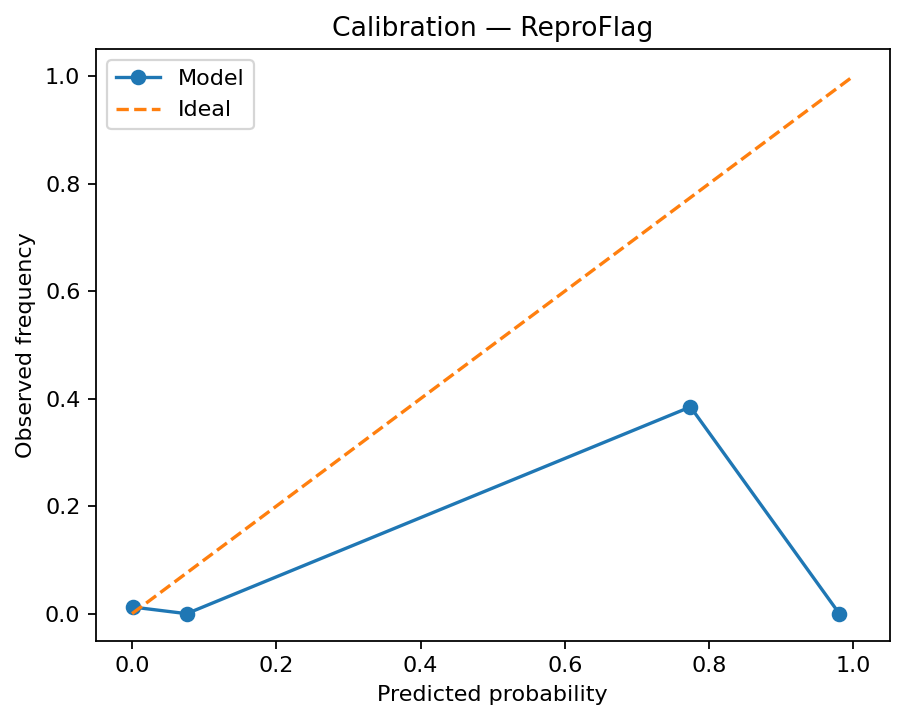

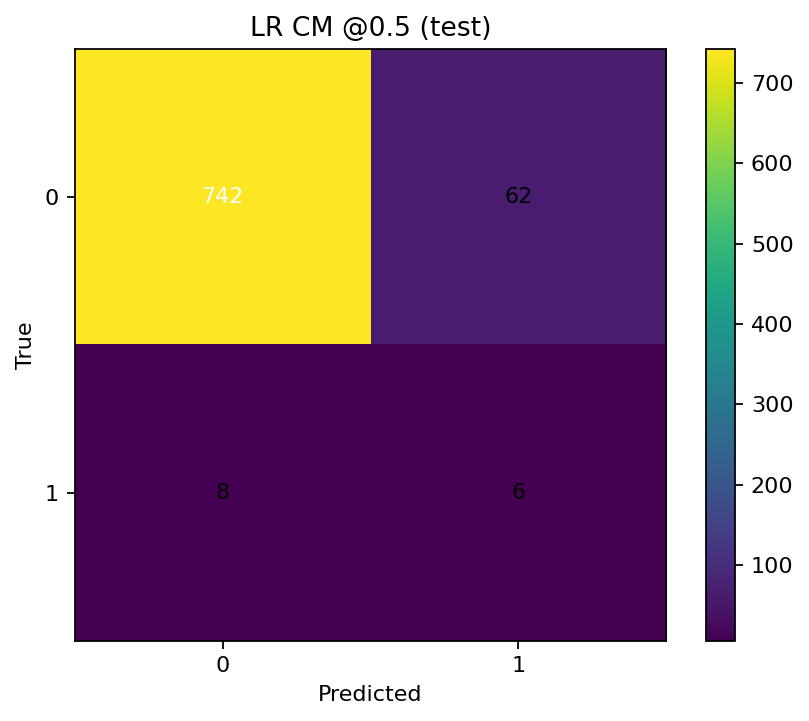

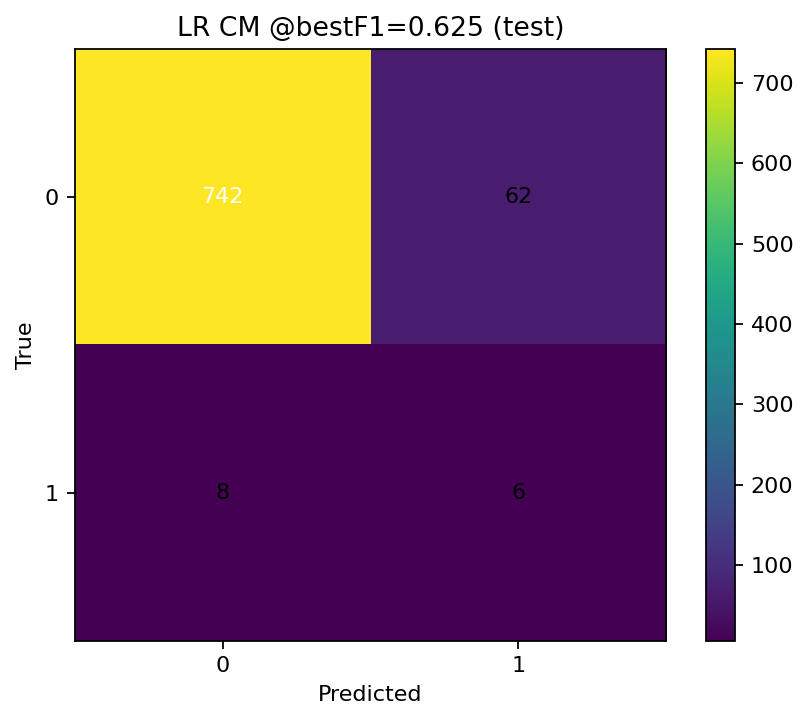

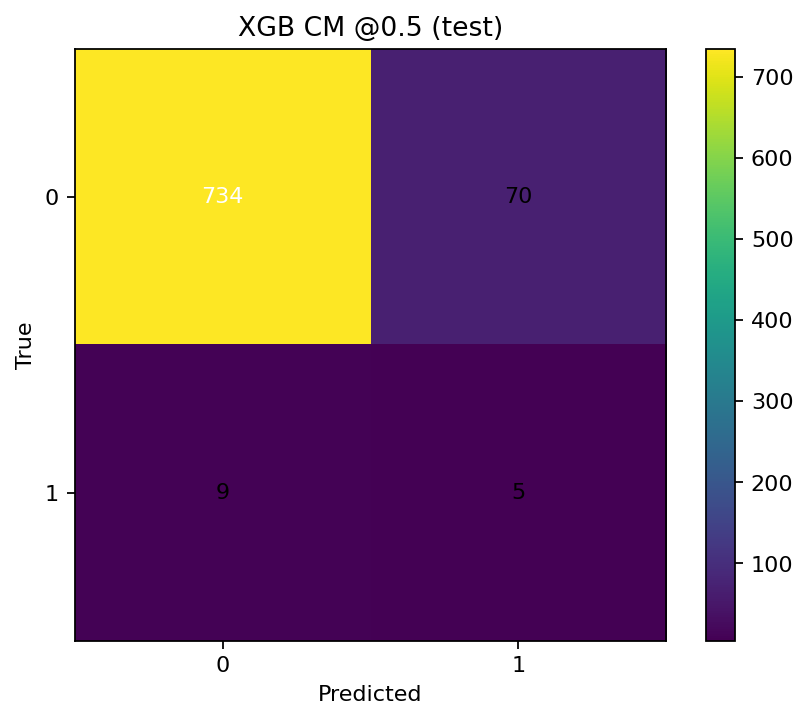

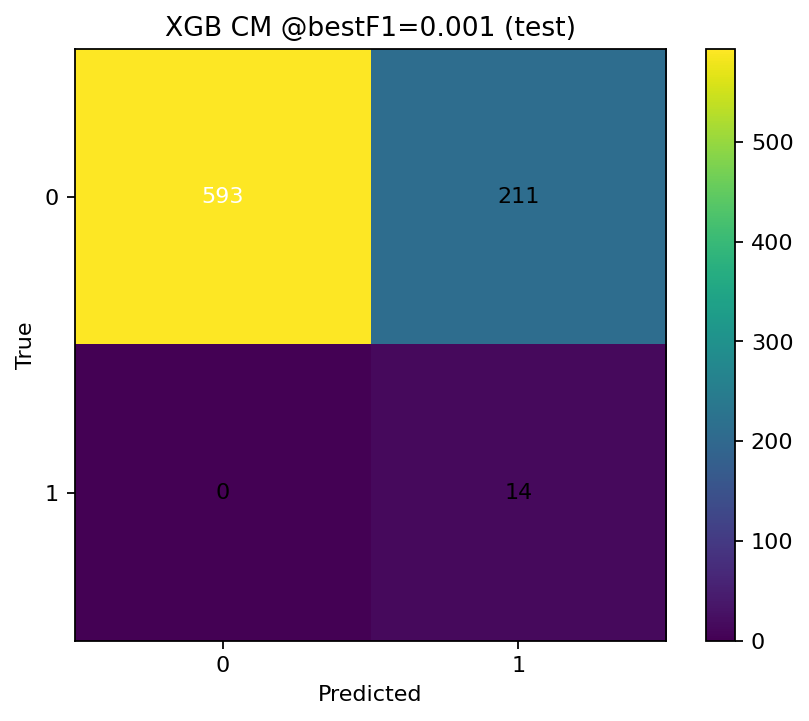

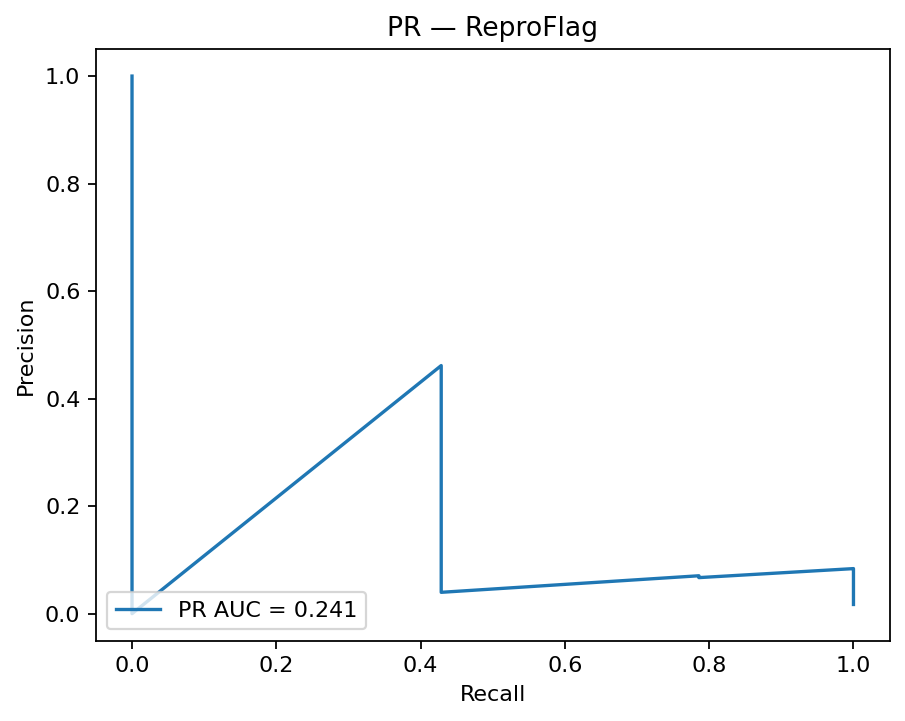

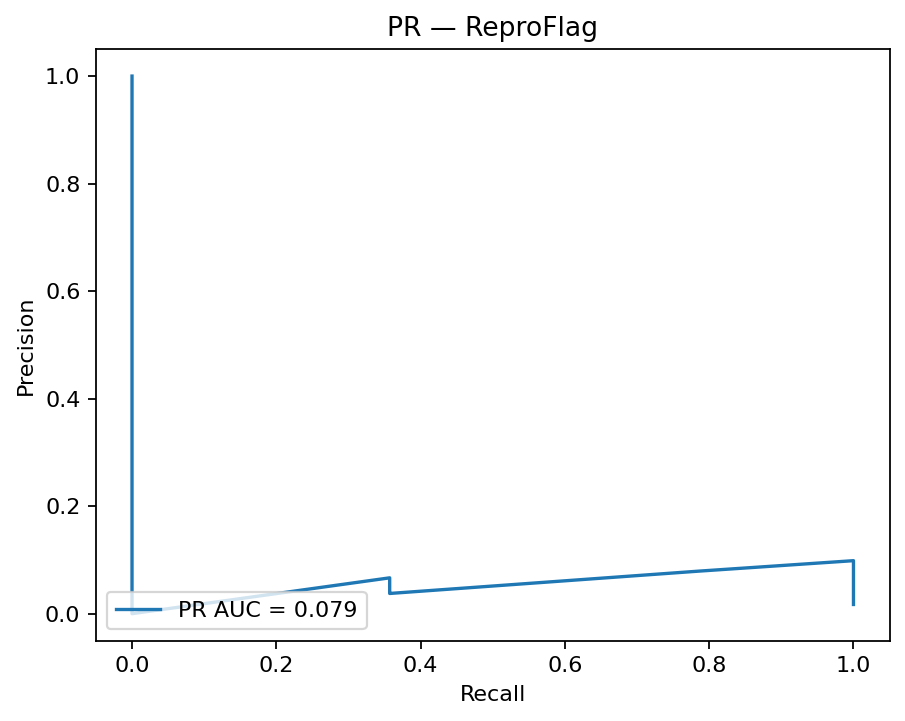

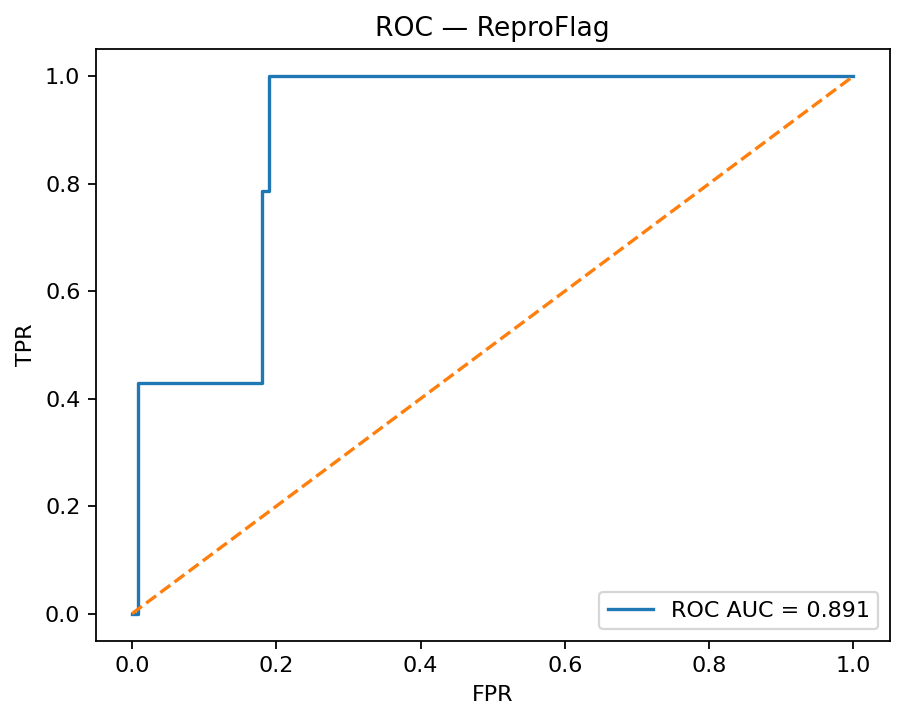

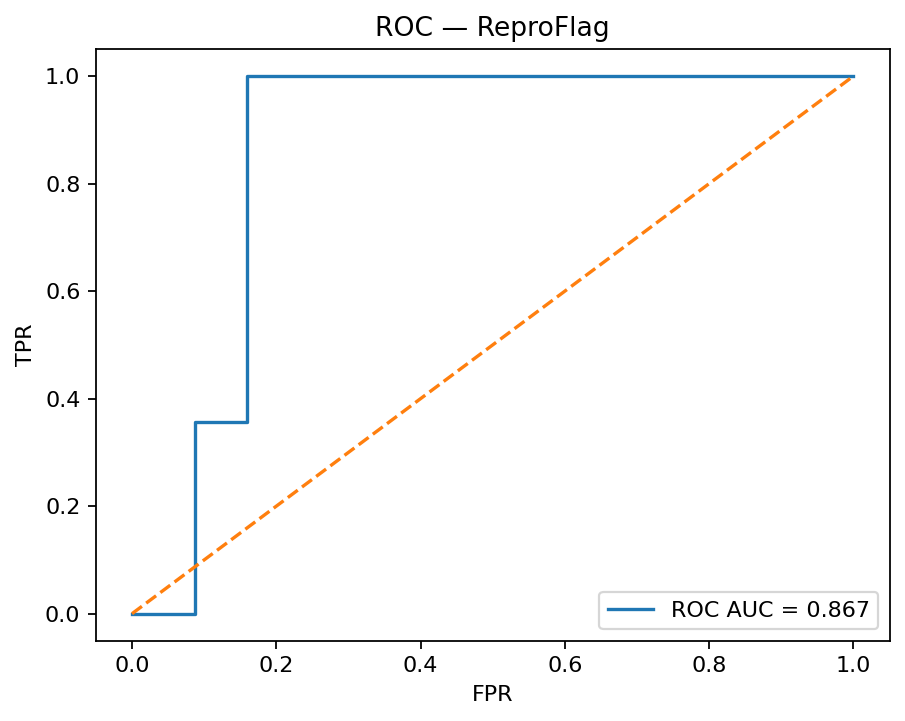

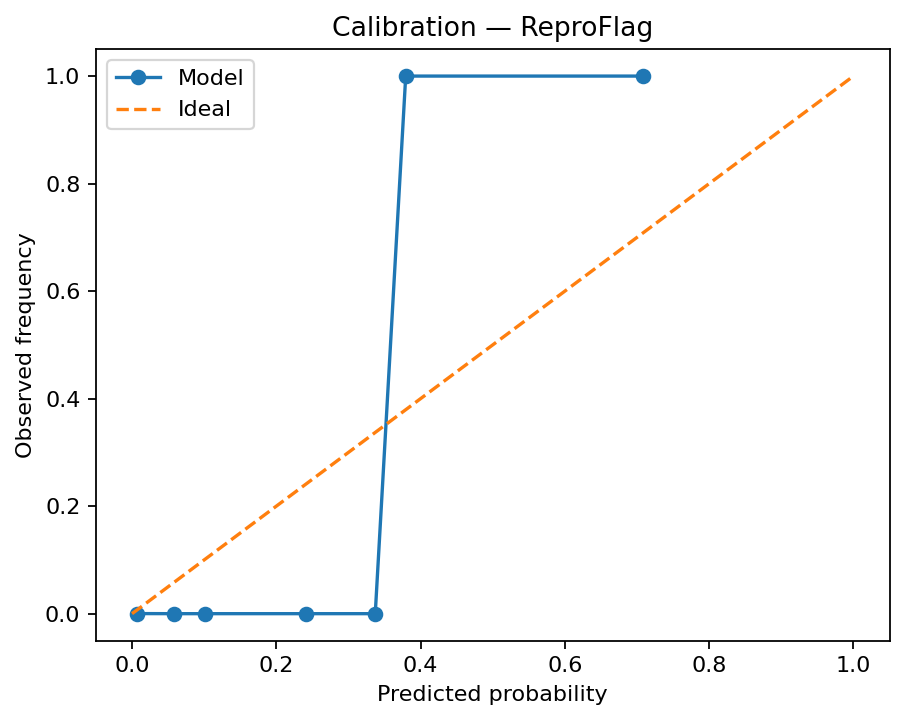

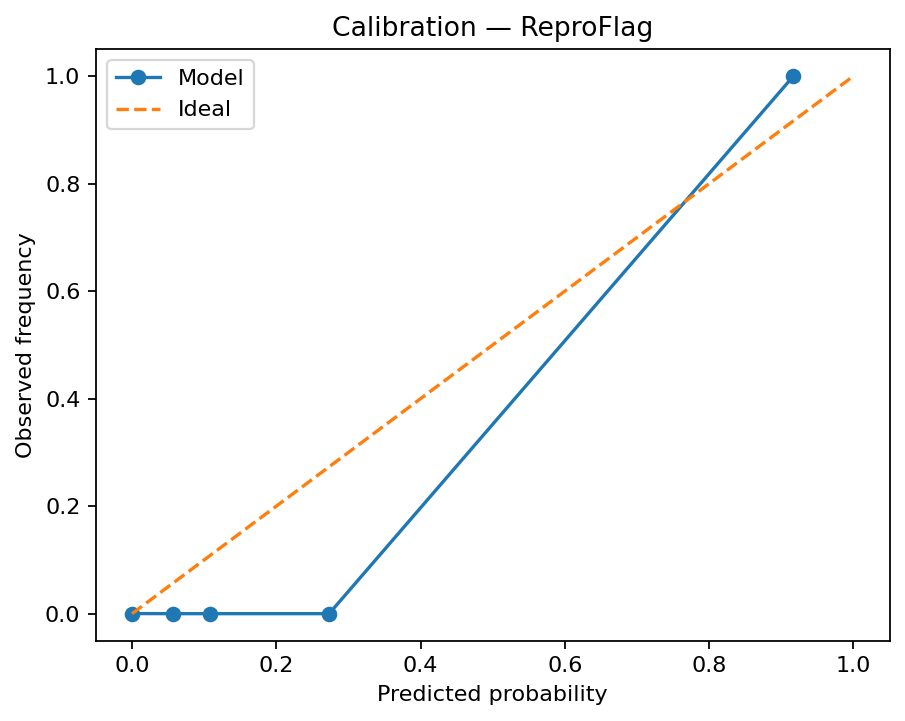

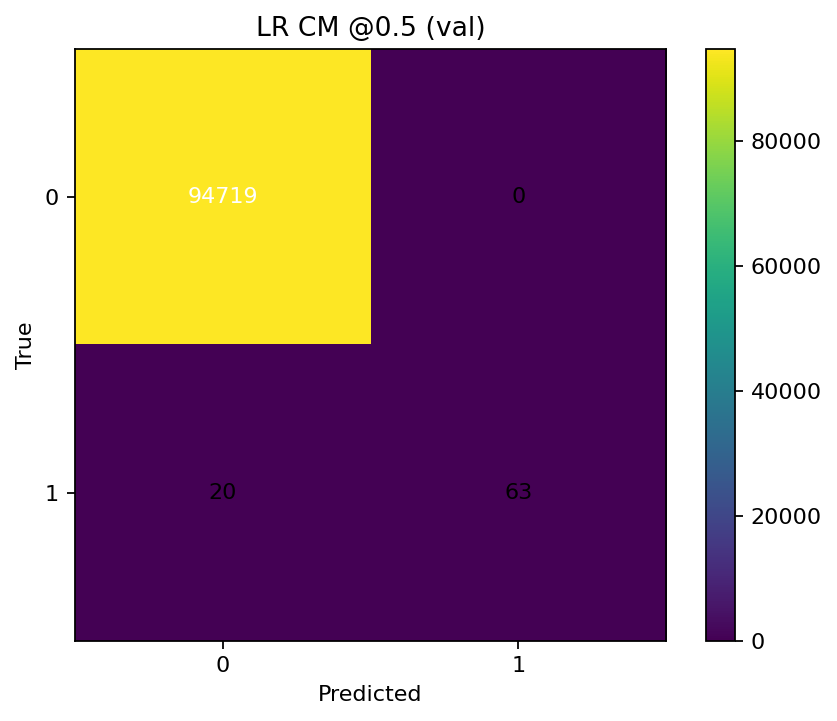

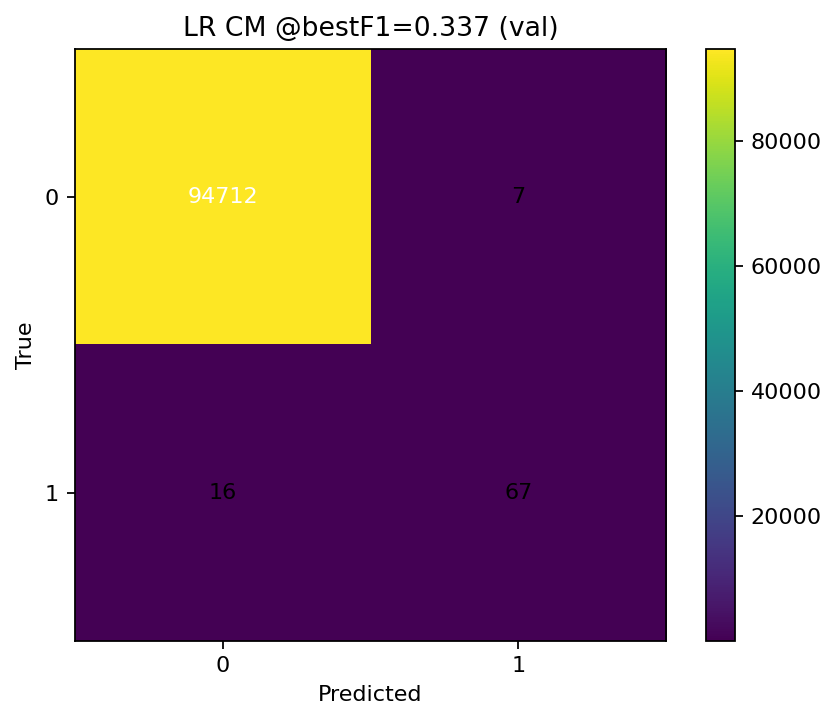

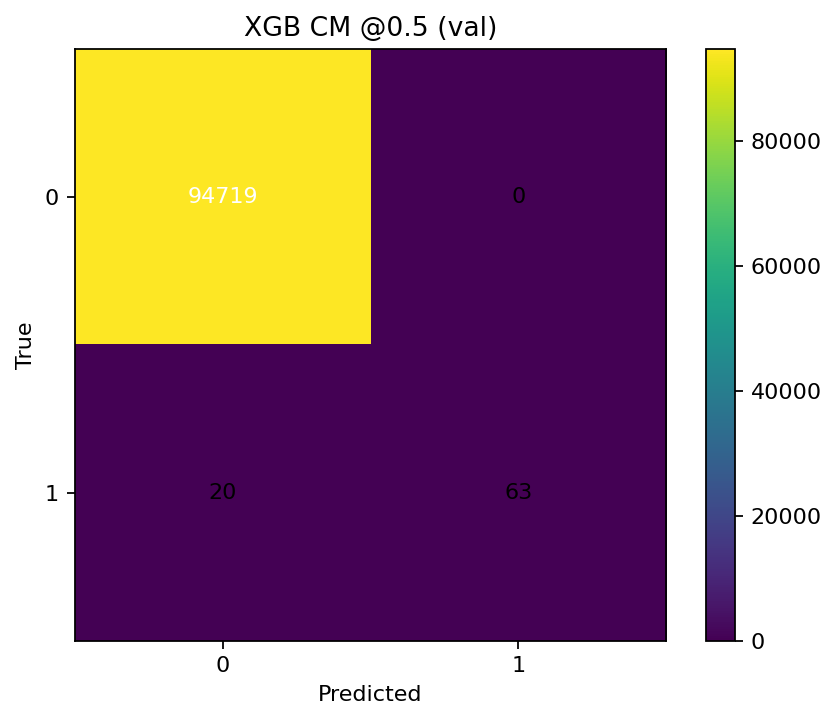

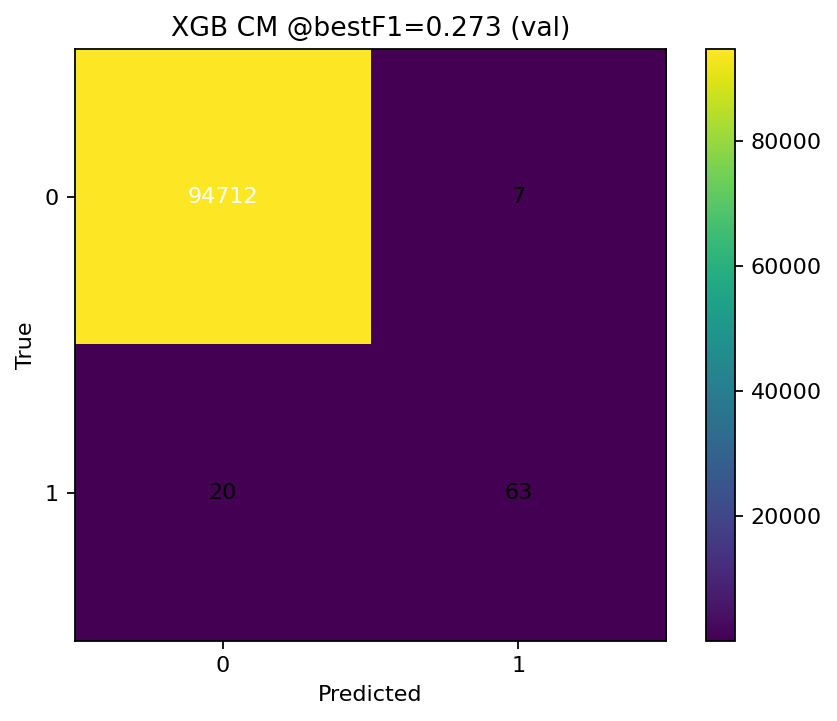

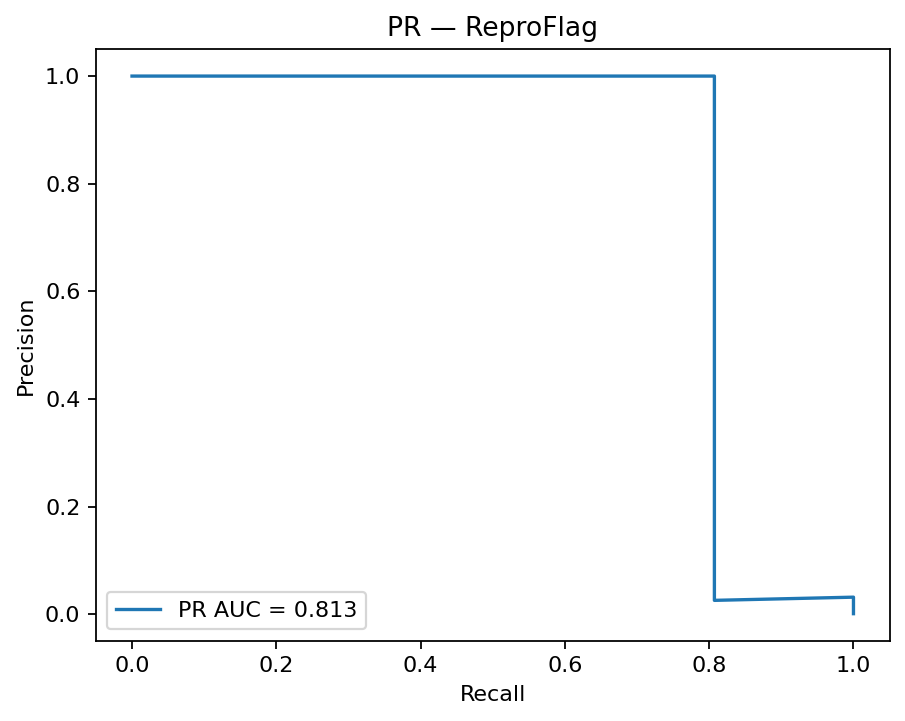

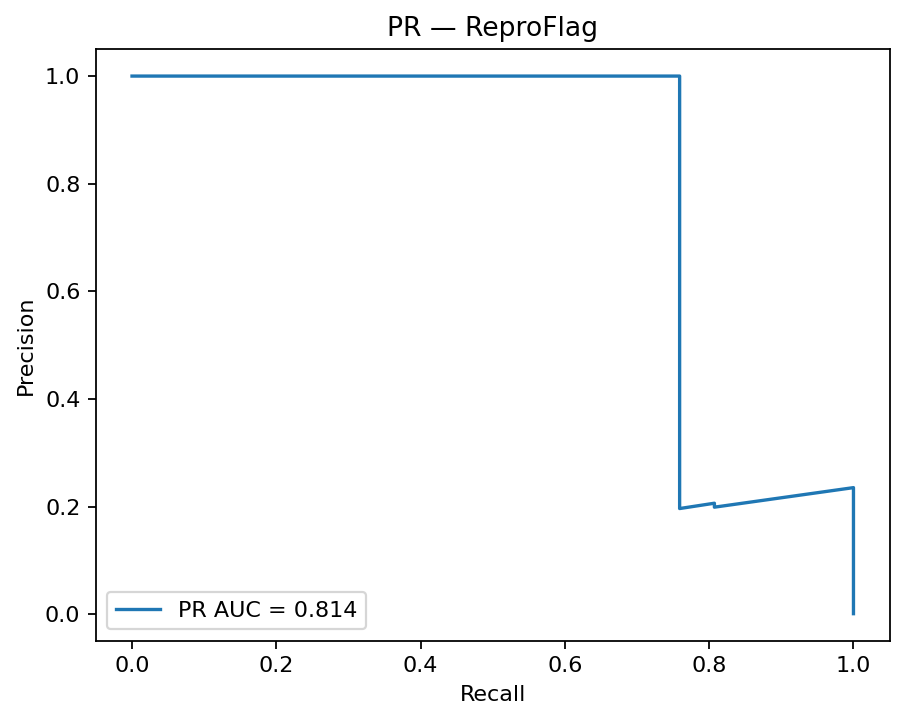

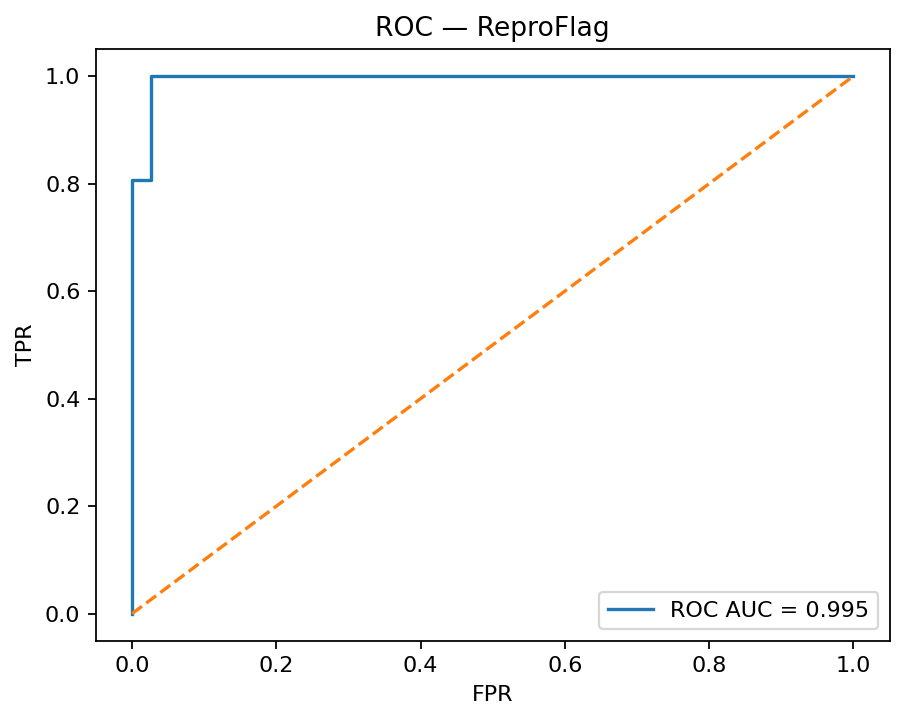

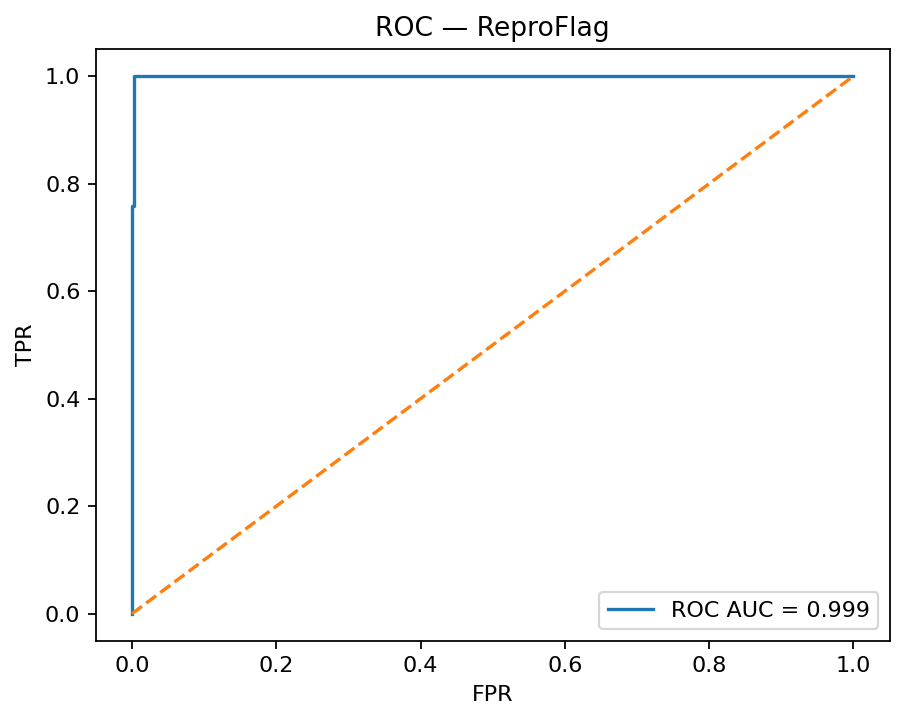

In [32]:
# Viewer cell: show all saved figures inline (ROC/PR/CM/Calibration/SHAP)

from pathlib import Path
from IPython.display import display, Image, HTML

BASE = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
RPT  = BASE / "analysis_reports"

pngs = sorted([p for p in RPT.glob("repro_*.png")] +
              [RPT/"repro_shap_bar_xgb.png", RPT/"repro_shap_beeswarm_xgb.png"])

# De-duplicate while keeping order
seen, ordered = set(), []
for p in pngs:
    if p.exists() and p not in seen:
        seen.add(p); ordered.append(p)

display(HTML("<h3>ReproFlag visualizations</h3>"))
for p in ordered:
    display(HTML(f"<b>{p.name}</b>"))
    display(Image(filename=str(p)))

In [35]:
# Rebuild models & probability arrays for ReproFlag (so Cell B can run)
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
import xgboost as xgb

BASE = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
RPT  = BASE / "analysis_reports"

# --- load labeled data & CAS-group splits ---
df = pd.read_parquet(RPT / "main_with_labels.parquet")
cas_train = set(pd.read_csv(RPT / "repro_split_train_cas.txt", header=None)[0].astype(str))
cas_val   = set(pd.read_csv(RPT / "repro_split_val_cas.txt",   header=None)[0].astype(str))
cas_test  = set(pd.read_csv(RPT / "repro_split_test_cas.txt",  header=None)[0].astype(str))

# keep rows with SMILES & FP
df = df[df["smiles"].notna()].copy()

# --- features ---
desc_cols = ["MW","LogP","TPSA","HBD","HBA","RotB","Rings"]

def hex_to_bits(hexstr, n_bits=2048):
    if not isinstance(hexstr, str) or len(hexstr.strip()) == 0:
        return np.zeros(n_bits, dtype=np.uint8)
    try:
        b = bytes.fromhex(hexstr)
        bits = np.unpackbits(np.frombuffer(b, dtype=np.uint8))
        if bits.size < n_bits:
            bits = np.pad(bits, (0, n_bits - bits.size))
        elif bits.size > n_bits:
            bits = bits[:n_bits]
        return bits.astype(np.uint8)
    except Exception:
        return np.zeros(n_bits, dtype=np.uint8)

# build FP matrix once for speed
uniq_fp = df["FP_hex"].astype(str).fillna("").unique()
fp_map = {h: hex_to_bits(h, 2048) for h in uniq_fp}
FP = np.vstack(df["FP_hex"].astype(str).map(fp_map).values)

X_desc = df[desc_cols].fillna(0).astype(float).values
X_all  = np.hstack([X_desc, FP])   # shape: (N, 7 + 2048) = (N, 2055)
y_all  = df["ReproFlag"].astype(int).values

# --- split by canonical_cas groups ---
cas = df["canonical_cas"].astype(str)
idx_train = cas.isin(cas_train).values
idx_val   = cas.isin(cas_val).values
idx_test  = cas.isin(cas_test).values

X_train, y_train = X_all[idx_train], y_all[idx_train]
X_val,   y_val   = X_all[idx_val],   y_all[idx_val]
X_test,  y_test  = X_all[idx_test],  y_all[idx_test]

# keep df_test for ranking/inspection in Cell B
df_test = df[idx_test].copy()

# --- fit LR (with scaling on descriptors+FP) ---
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = float(neg / max(pos, 1))

lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # sparse-friendly; X is dense but high-dim
    ("clf", LogisticRegression(
        penalty="l2", solver="liblinear", class_weight={0:1, 1:spw},
        max_iter=2000, random_state=42))
])
lr.fit(X_train, y_train)

# --- fit XGB ---
xgb_clf = xgb.XGBClassifier(
    n_estimators=600, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.7,
    reg_lambda=1.0, reg_alpha=0.0,
    objective="binary:logistic", eval_metric="aucpr",
    scale_pos_weight=spw, tree_method="hist", random_state=42
)
xgb_clf.fit(X_train, y_train)

# --- probabilities for VAL/TEST (globals for Cell B) ---
y_val_prob_lr  = lr.predict_proba(X_val)[:,1]
y_test_prob_lr = lr.predict_proba(X_test)[:,1]
y_val_prob_xgb  = xgb_clf.predict_proba(X_val)[:,1]
y_test_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]

# quick sanity prints
def brief(y_true, y_prob, tag):
    try:
        roc = roc_auc_score(y_true, y_prob)
        pr  = average_precision_score(y_true, y_prob)
        print(f"{tag}: ROC AUC={roc:.3f} | PR AUC={pr:.3f}")
    except ValueError:
        print(f"{tag}: not enough label variety for AUC")

print(f"Shapes — X_train: {X_train.shape} X_val: {X_val.shape} X_test: {X_test.shape}")
print(f"Positives — train: {int(y_train.sum())} val: {int(y_val.sum())} test: {int(y_test.sum())}")
print(f"scale_pos_weight used: {spw:.2f}")
brief(y_val,  y_val_prob_lr,  "VAL  LR")
brief(y_val,  y_val_prob_xgb, "VAL  XGB")
brief(y_test, y_test_prob_lr, "TEST LR")
brief(y_test, y_test_prob_xgb,"TEST XGB")

# keep important names in globals for Cell B
globals().update({
    "y_val": y_val, "y_test": y_test,
    "y_val_prob_lr": y_val_prob_lr, "y_val_prob_xgb": y_val_prob_xgb,
    "y_test_prob_lr": y_test_prob_lr, "y_test_prob_xgb": y_test_prob_xgb,
    "df_test": df_test
})
print("\nReady: arrays & df_test are in memory. Now re-run the threshold/plots cell (Cell B).")

Shapes — X_train: (4523, 2055) X_val: (94802, 2055) X_test: (818, 2055)
Positives — train: 91 val: 83 test: 14
scale_pos_weight used: 48.70
VAL  LR: ROC AUC=1.000 | PR AUC=1.000
VAL  XGB: ROC AUC=0.995 | PR AUC=0.775
TEST LR: ROC AUC=0.726 | PR AUC=0.095
TEST XGB: ROC AUC=0.869 | PR AUC=0.081

Ready: arrays & df_test are in memory. Now re-run the threshold/plots cell (Cell B).


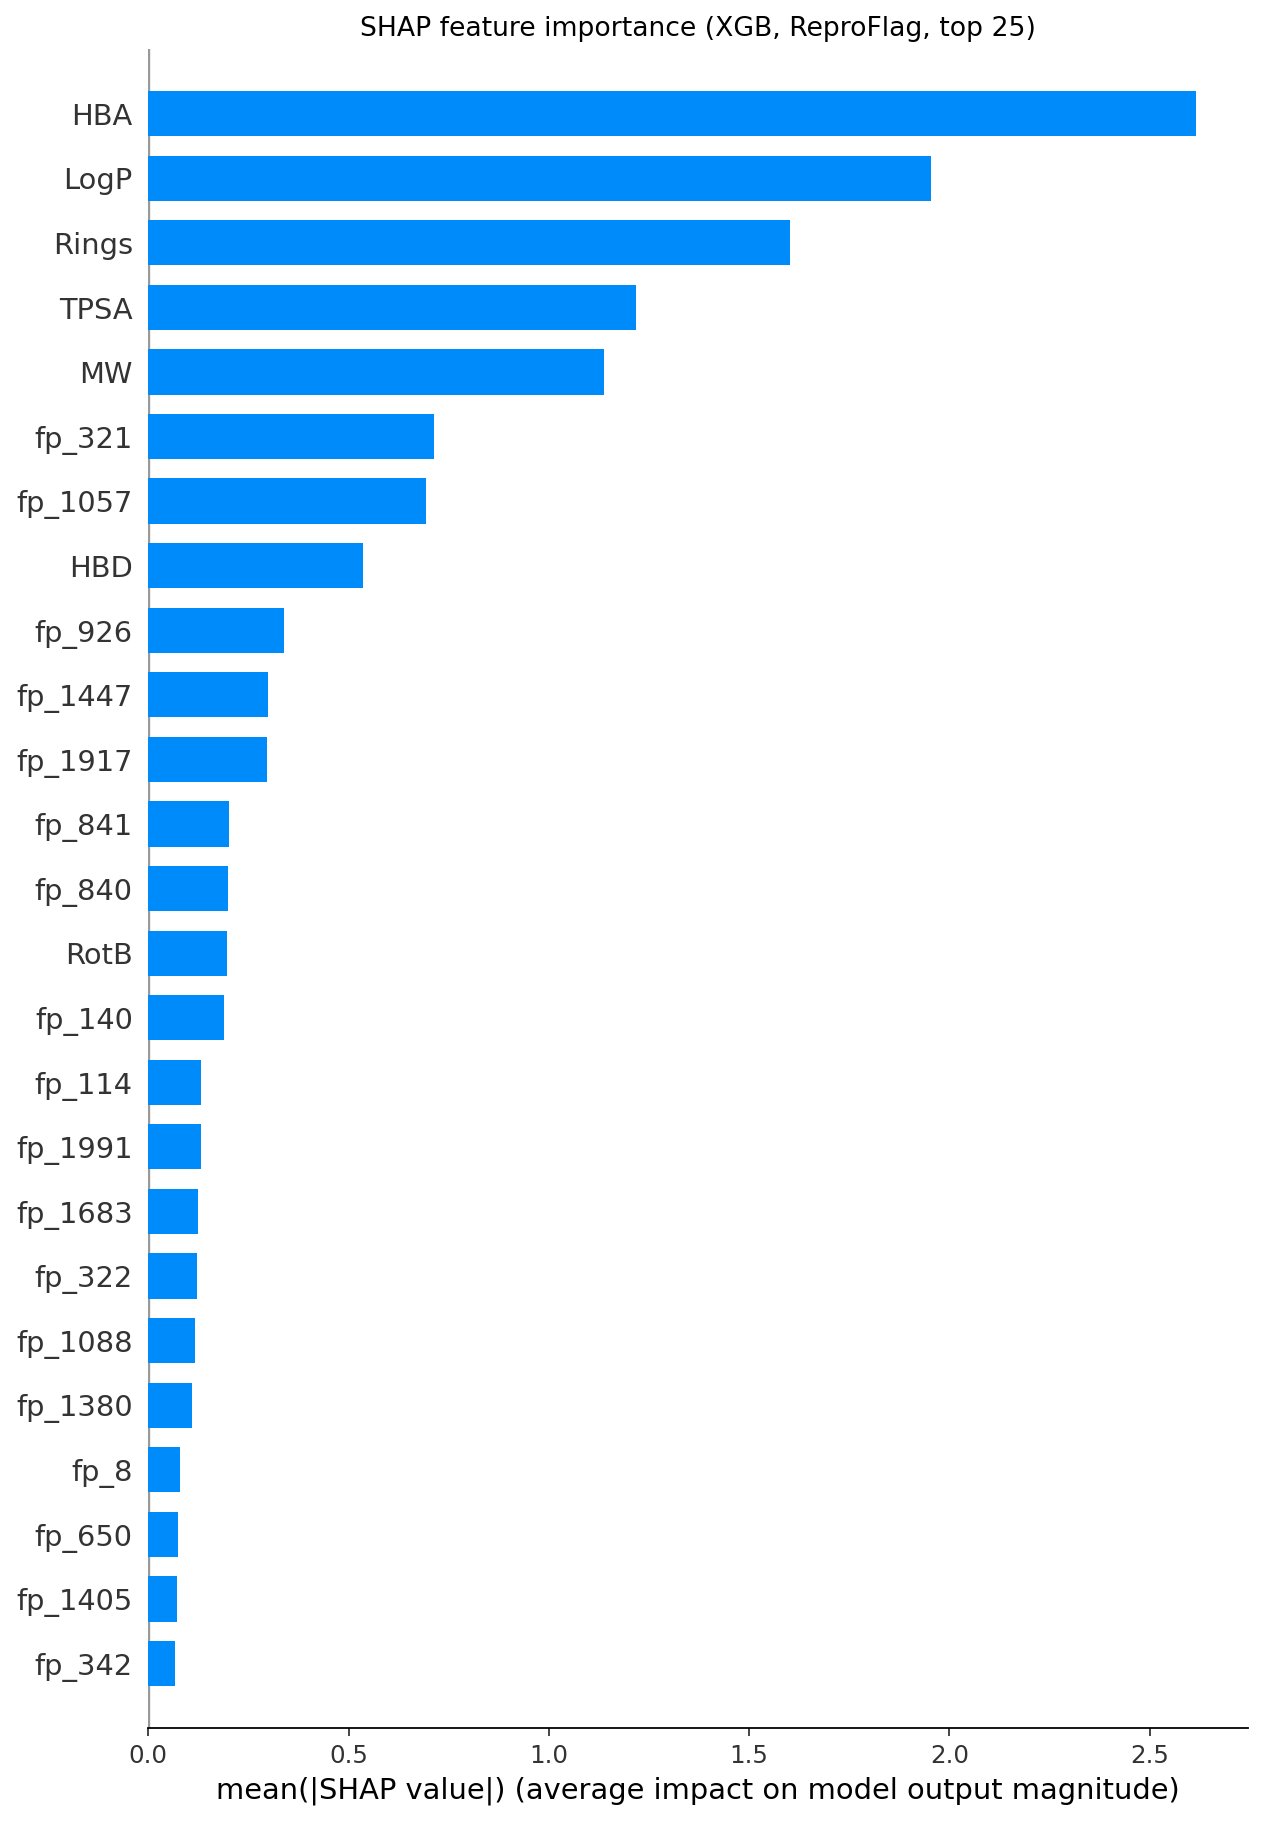

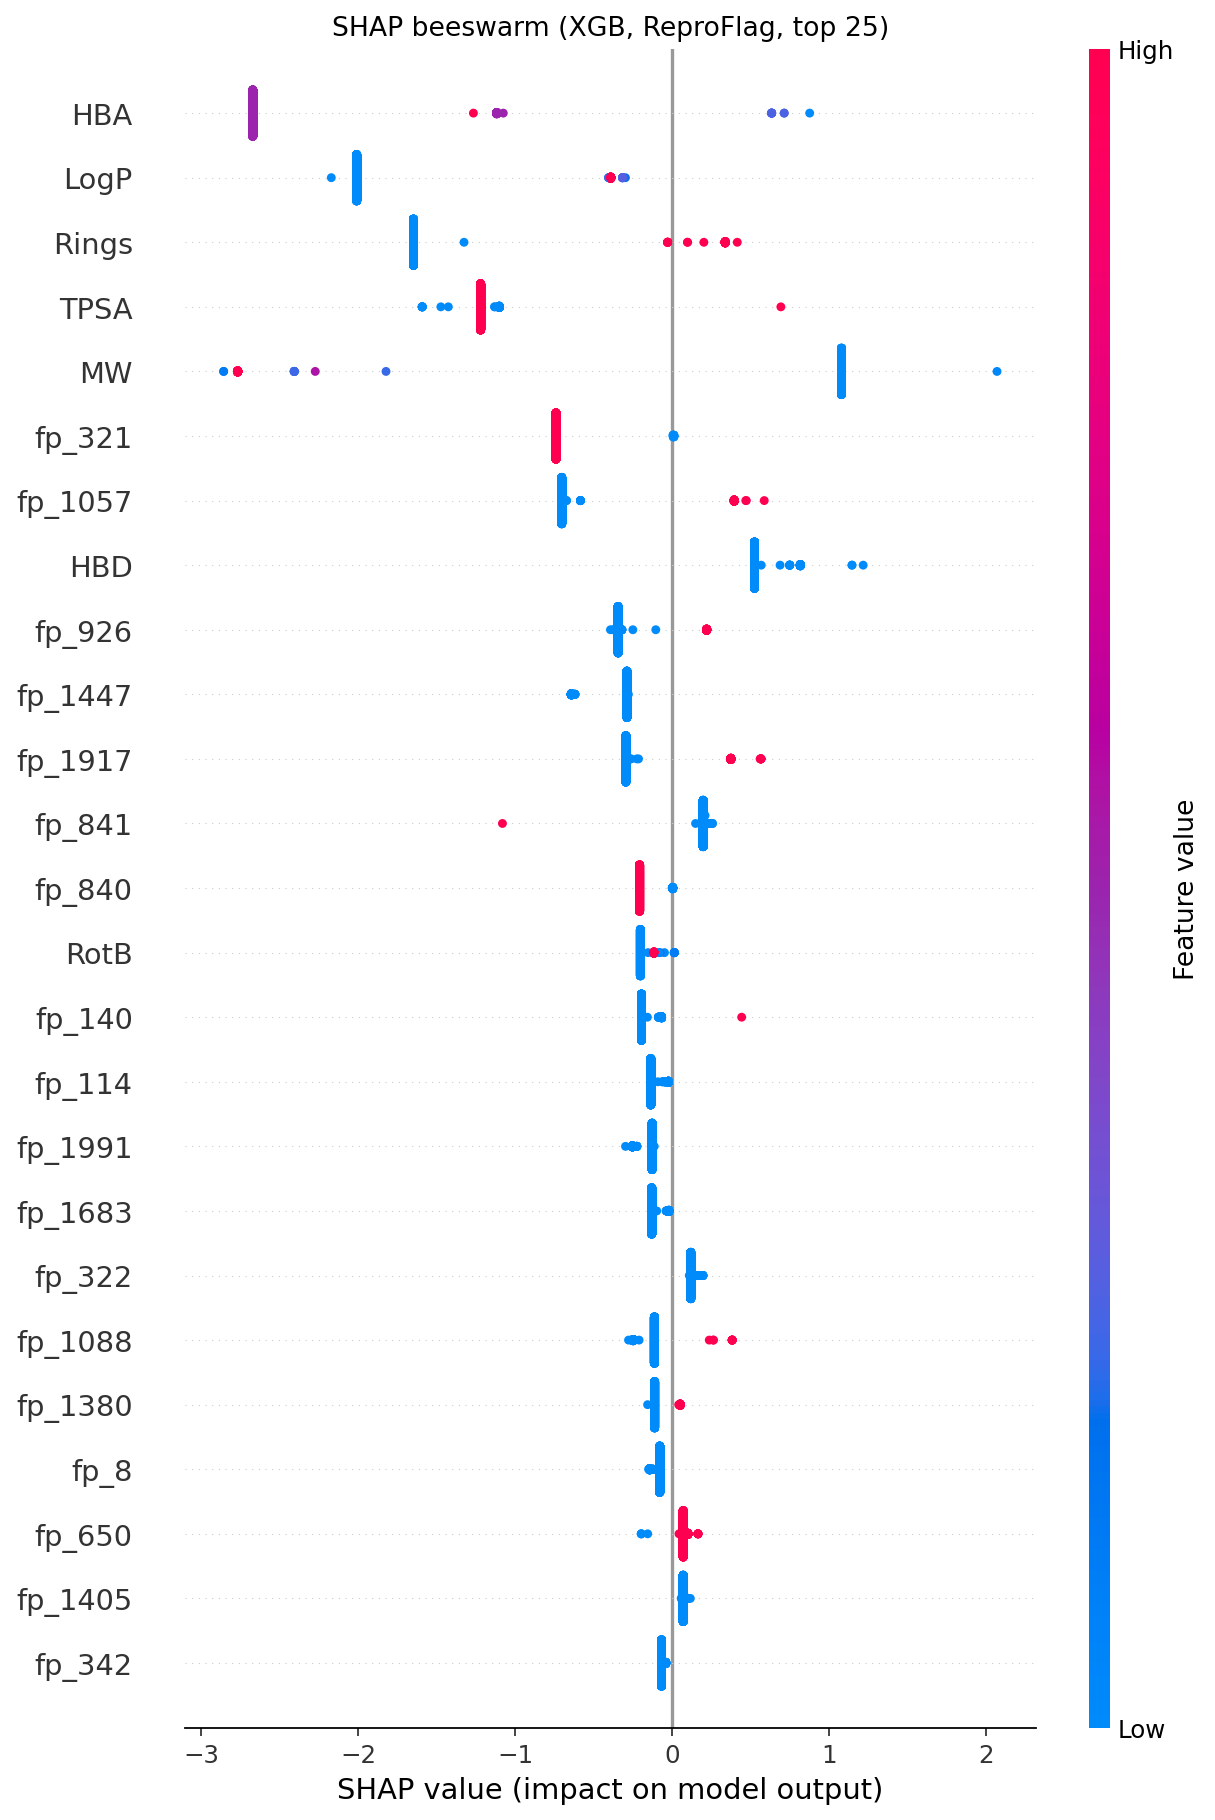

In [36]:
# Show saved ReproFlag figures inline
from pathlib import Path
from IPython.display import display, Image, HTML

BASE = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
RPT  = BASE / "analysis_reports"

# Add anything that matches what your pipeline saved
patterns = [
    "repro_roc_lr.png", "repro_pr_lr.png", "repro_cm_lr@0.50.png", "repro_cm_lr@bestF1.png",
    "repro_roc_xgb.png","repro_pr_xgb.png","repro_cm_xgb@0.50.png","repro_cm_xgb@bestF1.png",
    "repro_calibration_lr.png", "repro_calibration_xgb.png",
    "repro_shap_bar_xgb.png", "repro_shap_beeswarm_xgb.png"
]
pngs = [RPT/p for p in patterns if (RPT/p).exists()]

display(HTML("<h3>ReproFlag visualizations (inline)</h3>"))
for p in pngs:
    display(HTML(f"<b>{p.name}</b>"))
    display(Image(filename=str(p)))

Test rows: (818, 36) | positives: 14

Chosen thresholds from VAL:
  LR  — F2-opt thr=0.0135 (val F2≈1.000, P=1.000, R=1.000);  recall90 thr=0.0135
  XGB — F2-opt thr=0.9218 (val F2≈0.797, P=1.000, R=0.759); recall90 thr=0.0021

=== Evaluate TEST at VAL F2 thresholds ===

LR (F2) @ thr=0.0135
Confusion matrix [[TN, FP],[FN, TP]]:
[[596, 208], [3, 11]]
              precision    recall  f1-score   support

           0      0.995     0.741     0.850       804
           1      0.050     0.786     0.094        14

    accuracy                          0.742       818
   macro avg      0.523     0.764     0.472       818
weighted avg      0.979     0.742     0.837       818


XGB (F2) @ thr=0.9218
Confusion matrix [[TN, FP],[FN, TP]]:
[[742, 62], [14, 0]]
              precision    recall  f1-score   support

           0      0.981     0.923     0.951       804
           1      0.000     0.000     0.000        14

    accuracy                          0.907       818
   macro avg      0.

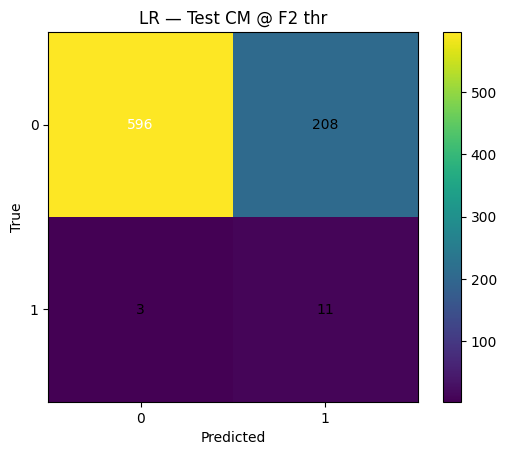

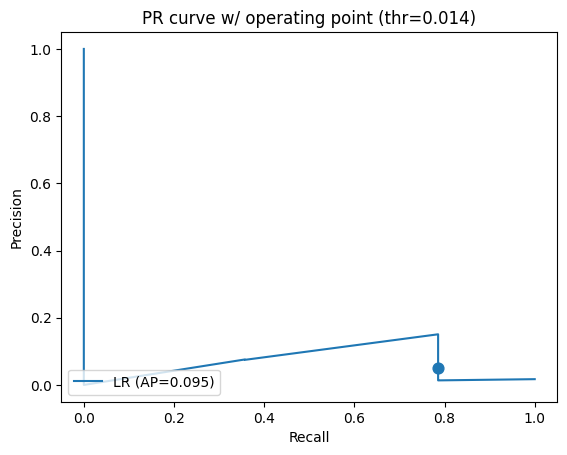

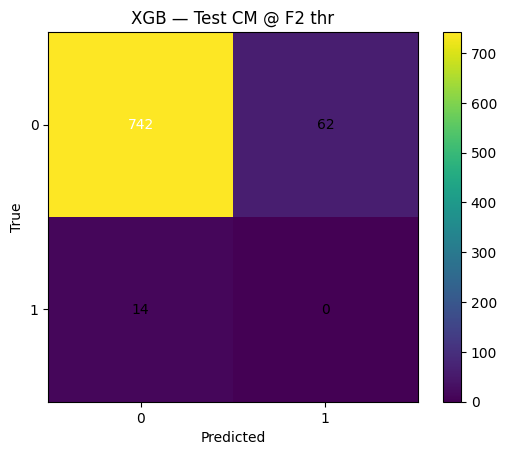

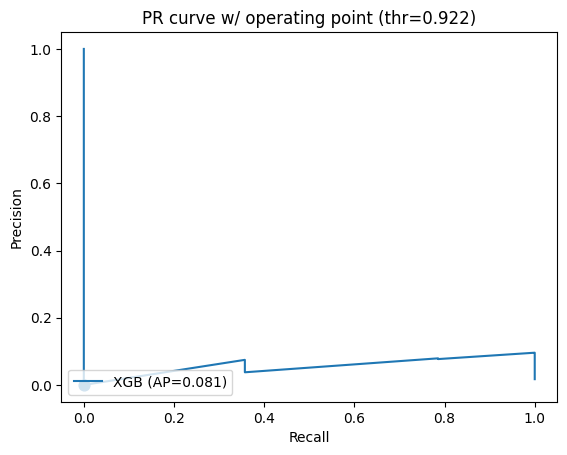


Saved top‑ranked test predictions to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/repro_test_top_predictions.csv


,ChemicalName,CasNumber,canonical_cas,proba_xgb,proba_lr
15752,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
15669,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
15718,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
17626,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
15661,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
15695,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
15690,Propylene oxide,75-56-9,75-56-9,0.999865,0.768985
15227,Acetaldehyde,75-07-0,75-07-0,0.972715,0.060984
15746,Acetaldehyde,75-07-0,75-07-0,0.972715,0.060984
16433,Acetaldehyde,75-07-0,75-07-0,0.972715,0.060984


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

BASE = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics")
RPT  = BASE / "analysis_reports"

# --- helpers ---
def choose_threshold_by_fbeta(y_true, y_prob, beta=2.0):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # thr has len = len(prec)-1
    fbeta = (1+beta**2) * (prec*rec) / (beta**2 * prec + rec + 1e-12)
    i = np.nanargmax(fbeta[:-1])  # align with thresholds
    return float(thr[i]), float(fbeta[i]), float(prec[i]), float(rec[i])

def choose_threshold_for_recall(y_true, y_prob, target_recall=0.90):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # Find first threshold reaching the target recall (or closest below)
    idx = np.where(rec[:-1] >= target_recall)[0]
    if len(idx)==0:
        # fallback: take the max recall point
        j = np.argmax(rec[:-1])
    else:
        j = idx[-1]  # largest threshold achieving target recall
    return float(thr[j]), float(prec[j]), float(rec[j])

def show_cm(y_true, y_prob, thr, title, out_png: Path = None):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["0","1"]); plt.yticks(ticks, ["0","1"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center",
                 color="white" if v>cm.max()/2 else "black")
    plt.xlabel("Predicted"); plt.ylabel("True")
    if out_png: plt.savefig(out_png, dpi=160, bbox_inches="tight")
    plt.show()
    return cm, y_pred

def pr_with_point(y_true, y_prob, thr, label, out_png: Path = None):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure()
    plt.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
    # mark operating point
    y_pred = (y_prob >= thr).astype(int)
    TP = ((y_true==1)&(y_pred==1)).sum()
    FP = ((y_true==0)&(y_pred==1)).sum()
    P  = (y_true==1).sum()
    r  = TP / max(P,1)
    pr = TP / max((TP+FP),1)
    plt.scatter([r], [pr], s=60)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(loc="lower left")
    plt.title(f"PR curve w/ operating point (thr={thr:.3f})")
    if out_png: plt.savefig(out_png, dpi=160, bbox_inches="tight")
    plt.show()

# --- get arrays & test dataframe ---

# These should already exist from your training cell; if not, raise helpful error.
missing = [n for n in ["y_val","y_val_prob_lr","y_val_prob_xgb",
                       "y_test","y_test_prob_lr","y_test_prob_xgb"]
           if n not in globals()]
if missing:
    raise RuntimeError(f"Missing variables from training cell: {missing}. "
                       f"Re-run your training cell so these arrays exist.")

# Try to reuse df_test from memory; otherwise reconstruct it from saved test CAS list
if "df_test" not in globals():
    main = pd.read_parquet(RPT / "main_with_labels.parquet")
    test_cas = set(pd.read_csv(RPT / "repro_split_test_cas.txt", header=None)[0].astype(str))
    df_test = main[main["canonical_cas"].astype(str).isin(test_cas)].copy()

print("Test rows:", df_test.shape, "| positives:", int((y_test==1).sum()))

# --- pick thresholds from validation ---

# Option 1: F2 (more recall-weighted)
thr_lr_f2, f2_lr, p_lr, r_lr = choose_threshold_by_fbeta(y_val, y_val_prob_lr, beta=2.0)
thr_xgb_f2, f2_xgb, p_xgb, r_xgb = choose_threshold_by_fbeta(y_val, y_val_prob_xgb, beta=2.0)

# Option 2: target recall = 0.90 on VAL
thr_lr_r90, p_lr_r90, r_lr_r90 = choose_threshold_for_recall(y_val, y_val_prob_lr, target_recall=0.90)
thr_xgb_r90, p_xgb_r90, r_xgb_r90 = choose_threshold_for_recall(y_val, y_val_prob_xgb, target_recall=0.90)

print("\nChosen thresholds from VAL:")
print(f"  LR  — F2-opt thr={thr_lr_f2:.4f} (val F2≈{f2_lr:.3f}, P={p_lr:.3f}, R={r_lr:.3f});  recall90 thr={thr_lr_r90:.4f}")
print(f"  XGB — F2-opt thr={thr_xgb_f2:.4f} (val F2≈{f2_xgb:.3f}, P={p_xgb:.3f}, R={r_xgb:.3f}); recall90 thr={thr_xgb_r90:.4f}")

# --- evaluate on TEST with those thresholds ---
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

def eval_on_test(name, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    print(f"\n{name} @ thr={thr:.4f}")
    print("Confusion matrix [[TN, FP],[FN, TP]]:")
    print(cm.tolist())
    print(classification_report(y_test, y_pred, digits=3))

print("\n=== Evaluate TEST at VAL F2 thresholds ===")
eval_on_test("LR (F2)",  y_test_prob_lr,  thr_lr_f2)
eval_on_test("XGB (F2)", y_test_prob_xgb, thr_xgb_f2)

print("\n=== Evaluate TEST at VAL recall≈0.90 thresholds ===")
eval_on_test("LR (R≈0.90)",  y_test_prob_lr,  thr_lr_r90)
eval_on_test("XGB (R≈0.90)", y_test_prob_xgb, thr_xgb_r90)

# --- plots on TEST ---
show_cm(y_test, y_test_prob_lr,  thr_lr_f2,   "LR — Test CM @ F2 thr",   RPT/"repro_cm_lr@test_F2.png")
pr_with_point(y_test, y_test_prob_lr, thr_lr_f2, "LR", RPT/"repro_pr_lr@test_F2.png")

show_cm(y_test, y_test_prob_xgb, thr_xgb_f2, "XGB — Test CM @ F2 thr",  RPT/"repro_cm_xgb@test_F2.png")
pr_with_point(y_test, y_test_prob_xgb, thr_xgb_f2, "XGB", RPT/"repro_pr_xgb@test_F2.png")

# --- rank top predicted positives on TEST (XGB by default) ---
thr_use = thr_xgb_f2  # or thr_xgb_r90 if you prefer higher recall
df_rank = df_test.copy()
df_rank["proba_xgb"] = y_test_prob_xgb
df_rank["proba_lr"]  = y_test_prob_lr
df_rank = df_rank.sort_values("proba_xgb", ascending=False)

top_path = RPT / "repro_test_top_predictions.csv"
df_rank[["ChemicalName","CasNumber","canonical_cas","smiles","proba_xgb","proba_lr"]].head(200).to_csv(top_path, index=False)
print("\nSaved top‑ranked test predictions to:", top_path)
df_rank.head(10)[["ChemicalName","CasNumber","canonical_cas","proba_xgb","proba_lr"]]

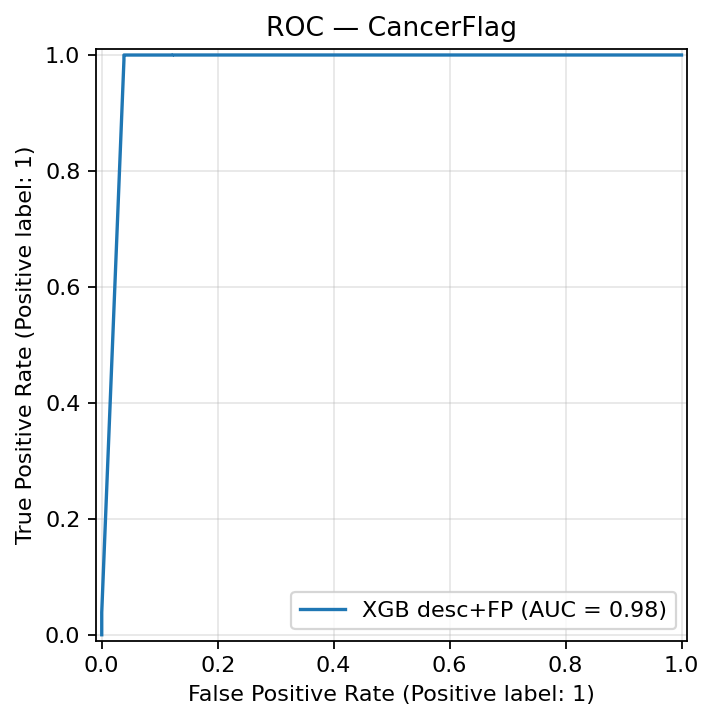

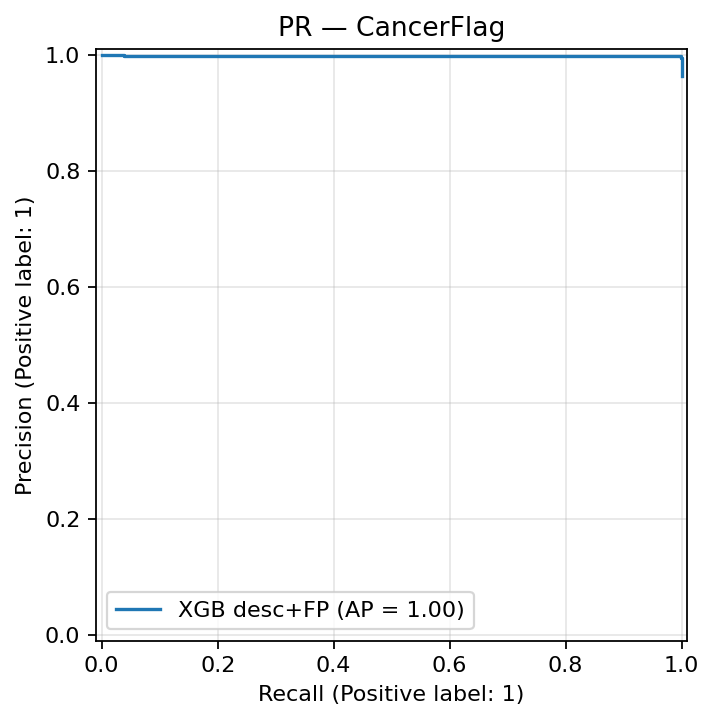

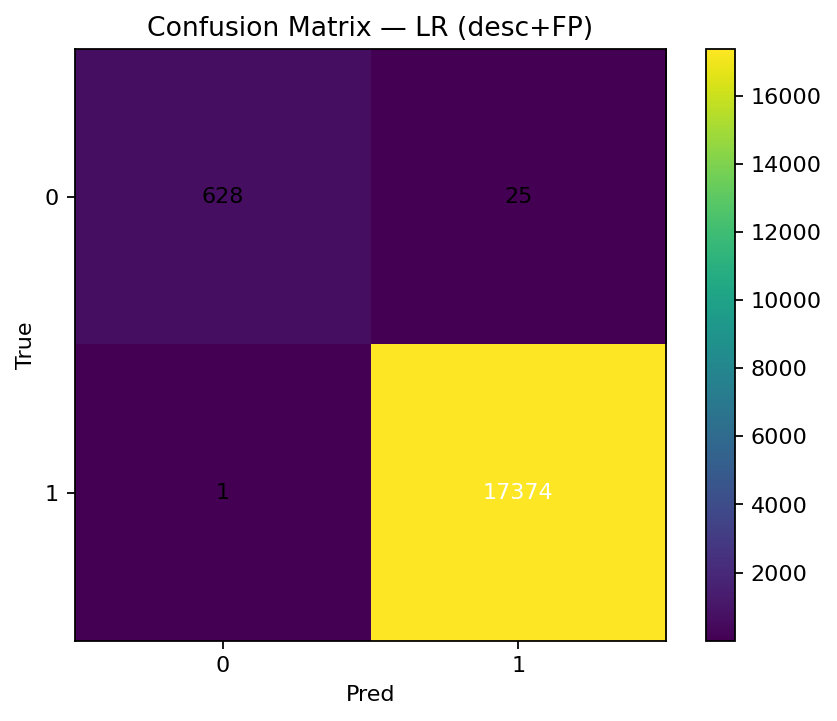

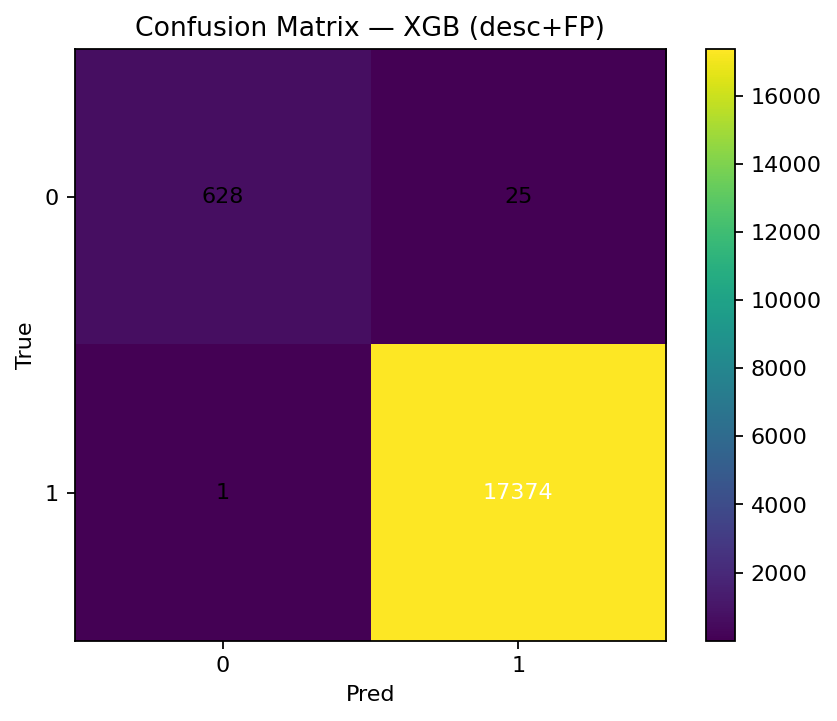

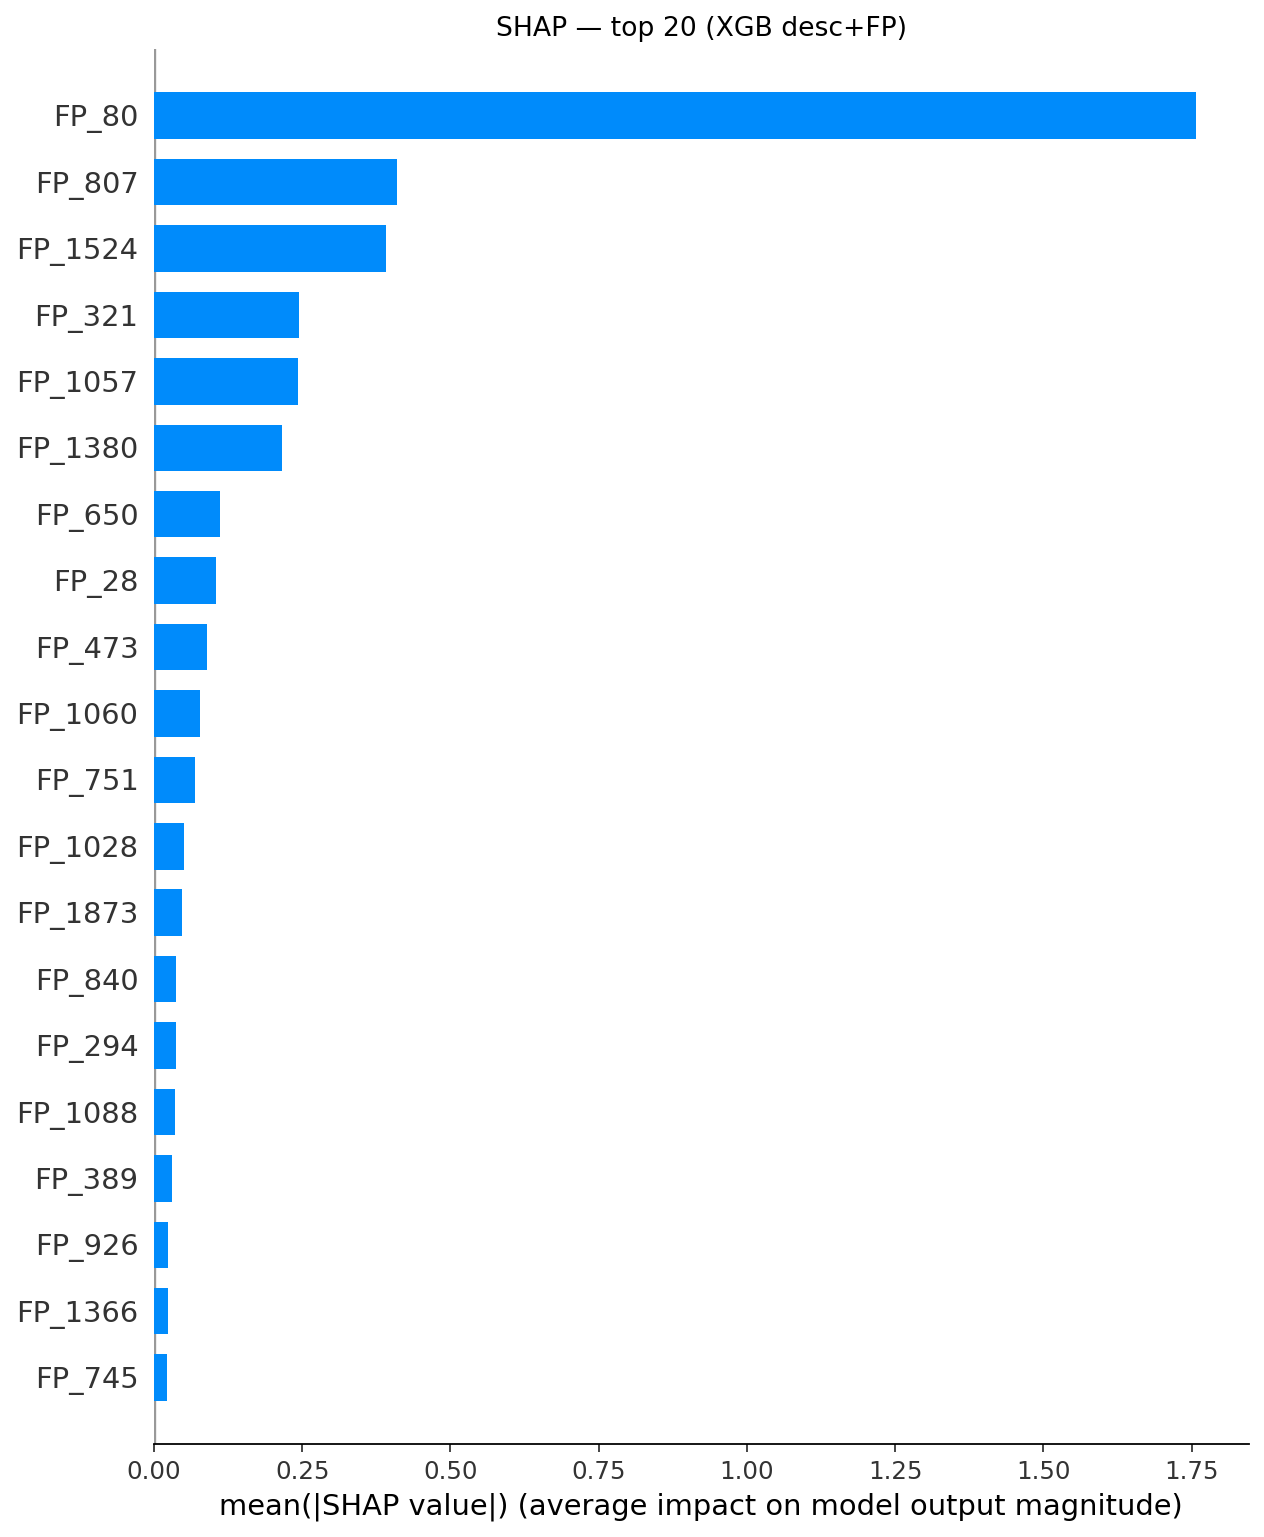

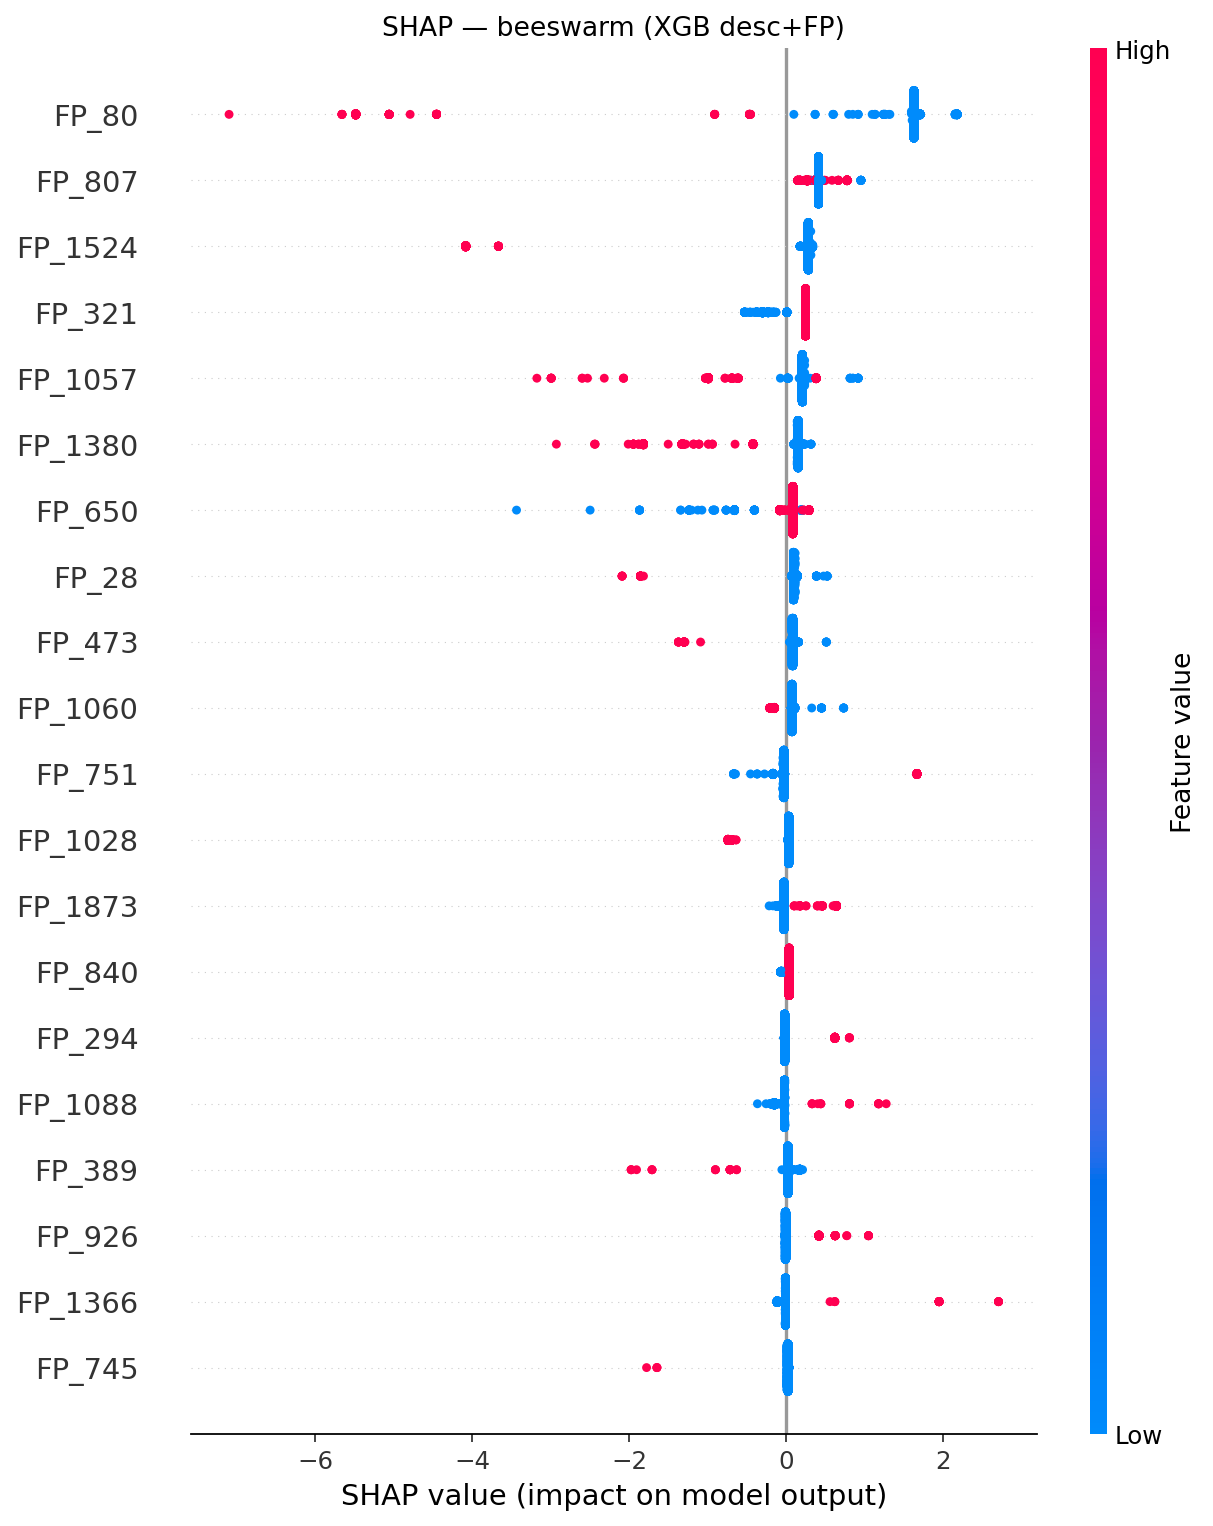

In [38]:
# Show the saved figures inline
from IPython.display import display, Image
from pathlib import Path

BASE = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports")
imgs = [
    "roc_desc_fp.png",
    "pr_desc_fp.png",
    "cm_lr_desc_fp.png",
    "cm_xgb_desc_fp.png",
    "shap_bar_xgb_desc_fp.png",
    "shap_beeswarm_xgb_desc_fp.png",
]
for f in imgs:
    p = BASE / f
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print("Missing:", p)

In [39]:
# Calibrate XGB probabilities with Isotonic on VAL, then re-evaluate TEST
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# Reuse xgb_clf, X_train, y_train, X_val, y_val, X_test, y_test (from your rebuild cell)
cal = CalibratedClassifierCV(xgb_clf, method="isotonic", cv="prefit")
cal.fit(X_val, y_val)

y_val_prob_xgb_cal  = cal.predict_proba(X_val)[:,1]
y_test_prob_xgb_cal = cal.predict_proba(X_test)[:,1]

def summarize(y_true, y_prob, tag):
    try:
        roc = roc_auc_score(y_true, y_prob)
        pr  = average_precision_score(y_true, y_prob)
        print(f"{tag}: ROC AUC={roc:.3f} | PR AUC={pr:.3f}")
    except ValueError:
        print(f"{tag}: not enough label variety")

summarize(y_val,  y_val_prob_xgb_cal,  "VAL  XGB (cal)")
summarize(y_test, y_test_prob_xgb_cal, "TEST XGB (cal)")

# Evaluate on TEST at the same recall≈0.90 threshold picked before (0.0021),
# and also at a val-F2-like threshold recomputed on calibrated VAL probs.
thr_recall90 = 0.0021

# pick F2-opt thr on calibrated VAL
ps = y_val_prob_xgb_cal
ys = y_val
ths = np.unique(np.round(ps, 6))
bestF2, bestThr = -1.0, 0.5
for t in ths[::max(1, len(ths)//2000)]:
    yhat = (ps >= t).astype(int)
    tp = ((yhat==1)&(ys==1)).sum(); fp = ((yhat==1)&(ys==0)).sum()
    fn = ((yhat==0)&(ys==1)).sum()
    prec = tp / (tp+fp) if tp+fp else 0.0
    rec  = tp / (tp+fn) if tp+fn else 0.0
    f2 = (5*prec*rec)/(4*prec+rec) if (4*prec+rec)>0 else 0.0
    if f2 > bestF2:
        bestF2, bestThr = f2, t

for tag, thr in [("cal-XGB @ recall≈0.90 thr", thr_recall90),
                 ("cal-XGB @ val F2 thr", bestThr)]:
    yhat = (y_test_prob_xgb_cal >= thr).astype(int)
    print(f"\n{tag} = {thr:.4g}")
    print("Confusion matrix [[TN, FP],[FN, TP]]:")
    print(confusion_matrix(y_test, yhat).tolist())
    print(classification_report(y_test, yhat, digits=3))

VAL  XGB (cal): ROC AUC=0.997 | PR AUC=0.775
TEST XGB (cal): ROC AUC=0.881 | PR AUC=0.080

cal-XGB @ recall≈0.90 thr = 0.0021
Confusion matrix [[TN, FP],[FN, TP]]:
[[672, 132], [0, 14]]
              precision    recall  f1-score   support

           0      1.000     0.836     0.911       804
           1      0.096     1.000     0.175        14

    accuracy                          0.839       818
   macro avg      0.548     0.918     0.543       818
weighted avg      0.985     0.839     0.898       818


cal-XGB @ val F2 thr = 1
Confusion matrix [[TN, FP],[FN, TP]]:
[[742, 62], [14, 0]]
              precision    recall  f1-score   support

           0      0.981     0.923     0.951       804
           1      0.000     0.000     0.000        14

    accuracy                          0.907       818
   macro avg      0.491     0.461     0.476       818
weighted avg      0.965     0.907     0.935       818



In [40]:
# Aggregate test predictions by CAS for quick review
import pandas as pd
from pathlib import Path

RPT = Path("/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports")

# df_test + y_test_prob_xgb exist from your rebuild/plots workflow
df_test_ag = (df_test.assign(
                proba_xgb=y_test_prob_xgb,
                proba_lr =y_test_prob_lr,
                y_true   =y_test)
              .groupby(["canonical_cas","ChemicalName","CasNumber"], as_index=False)
              .agg(n_rows=("y_true","size"),
                   n_pos =("y_true","sum"),
                   p95_xgb=("proba_xgb", lambda s: float(np.percentile(s,95))),
                   mean_xgb=("proba_xgb","mean"),
                   p95_lr =("proba_lr",  lambda s: float(np.percentile(s,95))),
                   mean_lr=("proba_lr","mean"))
              .sort_values(["p95_xgb","mean_xgb"], ascending=False))

df_test_ag.head(20)
out = RPT / "repro_test_ag_by_cas.csv"
df_test_ag.to_csv(out, index=False)
print("Saved CAS-level aggregation to:", out)

Saved CAS-level aggregation to: /content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/analysis_reports/repro_test_ag_by_cas.csv
